# Przetwarzanie danych

In [1]:
from sklearn.preprocessing import StandardScaler
from skfuzzy.cluster import cmeans, cmeans_predict
from sklearn.metrics import pairwise_distances_argmin_min
from sktime.datasets import load_basic_motions, load_arrow_head

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
import math
import sys

### Parametry startowe programu

In [2]:
chunk_length_train = 300
chunk_length_test = 300
std_div = 0
n_clusters = 8
n_classes = 4
dim = 6
injection = 1.0
m = 2
g_error = 0.05
stratify_percantage = 0.2

## Dane

In [3]:
%cd ..

C:\Users\kubak\Desktop\github\FuzzyClusteringAlgorithms


C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Pobieranie danych z bibliotek

In [4]:
from tslearn.datasets import UCR_UEA_datasets

def convert_to_dataframe(X, y):
    # Tworzenie DataFrame, gdzie każda kolumna to szereg czasowy (w formie listy)
    X_df = pd.DataFrame({i: [pd.Series(X[j, :, i]) for j in range(X.shape[0])] for i in range(X.shape[2])})
    y_df = pd.Series(y)
    return X_df, y_df

# Inicjalizacja obiektu odpowiedzialnego za zbiory danych
ucr_uea = UCR_UEA_datasets()

# Pobieranie zbioru danych 'AbnormalHeartbeat'
#X_train_heartbeat, y_train_heartbeat, X_test_heartbeat, y_test_heartbeat = ucr_uea.load_dataset('AbnormalHeartbeat')

# Pobieranie zbioru danych 'BasicMotions'
#X_train_motions, y_train_motions, X_test_motions, y_test_motions = ucr_uea.load_dataset('BasicMotions')

# Pobieranie zbioru danych 'ACSF1'
#X_train_ASCF, y_train_ASCF, X_test_ASCF, y_test_ASCF = ucr_uea.load_dataset('ACSF1')

# Pobieranie zbioru danych 'PhonemeSpectra'
#X_train_PhonemeSpectra, y_train_PhonemeSpectra, X_test_PhonemeSpectra, y_test_PhonemeSpectra = ucr_uea.load_dataset('PhonemeSpectra')

# Pobieranie zbioru danych 'EigenWorms'
#X_train_EigenWorms, y_train_EigenWorms, X_test_EigenWorms, y_test_EigenWorms = ucr_uea.load_dataset('EigenWorms')

## Basic Motions
#X_train, y_train = convert_to_dataframe(X_train_motions, y_train_motions)
#X_test, y_test = convert_to_dataframe(X_test_motions, y_test_motions)
#
## HeartBeat
#X_train, y_train = convert_to_dataframe(X_train_heartbeat, y_train_heartbeat)
#X_test, y_test = convert_to_dataframe(X_test_heartbeat, y_test_heartbeat)
#
## ACSF1
#X_train, y_train = convert_to_dataframe(X_train_ASCF, y_train_ASCF)
#X_test, y_test = convert_to_dataframe(X_test_ASCF, y_test_ASCF)
#
## PhonemeSpectra
#X_train, y_train = convert_to_dataframe(X_train_PhonemeSpectra, y_train_PhonemeSpectra)
#X_test, y_test = convert_to_dataframe(X_test_PhonemeSpectra, y_test_PhonemeSpectra)

# EigenWorms
#X_train, y_train = convert_to_dataframe(X_train_EigenWorms, y_train_EigenWorms)
#X_test, y_test = convert_to_dataframe(X_test_EigenWorms, y_test_EigenWorms)


C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [5]:
# Pobieranie zbioru danych 'EigenWorms'
X_train_, y_train_, X_test_, y_test_ = ucr_uea.load_dataset('BasicMotions')

X_train, y_train = convert_to_dataframe(X_train_, y_train_)
X_test, y_test = convert_to_dataframe(X_test_, y_test_)

sample_size = X_train.shape[1]

In [6]:
def reshape_data(X, y, n_features):
    n_length, m_length = X.shape

    y_reshaped = np.hstack([np.repeat(y[i], len(X.loc[i, 0])) for i in range(n_length)])  

    columns = []
    for column_id in range(m_length):

        column = []
        for row_id in range(n_length):
            list_length = len(X.loc[row_id, column_id])
            column += list(X.loc[row_id, column_id])
            
        column = np.array(column)
        columns.append(column)
        
    X_reshaped = np.column_stack(columns)
    return X_reshaped, y_reshaped

In [7]:
X_train, y_train = reshape_data(X_train, y_train, sample_size)
X_test, y_test = reshape_data(X_test, y_test, sample_size)

### Stratyfikacja

In [8]:
from sklearn.model_selection import train_test_split

def stratify_data(X, y, percentage):
    # Usuwamy wiersze z NaN w X lub odpowiadające etykiety w y
    mask = ~np.isnan(X).any(axis=1)
    X_clean = X[mask]
    y_clean = y[mask]
    
    # Obliczamy ile próbek chcemy zachować
    strat_size = percentage
    
    # Używamy metody train_test_split z argumentem 'stratify', który zapewnia stratyfikację
    X_stratified, _, y_stratified, _ = train_test_split(X_clean, y_clean, train_size=strat_size, stratify=y_clean)
    
    return X_stratified, y_stratified

In [9]:
if stratify_percantage < 1.0:
    X_train, y_train = stratify_data(X_train, y_train, stratify_percantage)
    X_test, y_test = stratify_data(X_train, y_train, stratify_percantage)

### Importowanie danych z dysku

In [10]:
from libraries.load import load_dataset_to_dataframe

filepath_train_basicmotions = './datasets/BasicMotions/BasicMotions_TRAIN.arff'
filepath_test_basicmotions = './datasets/BasicMotions/BasicMotions_TEST.arff'

#df_train = load_dataset_to_dataframe(filepath_train_basicmotions)
#df_test = load_dataset_to_dataframe(filepath_test_basicmotions)

In [11]:
from libraries.segmentation import stack_time_series, stack_time_series_randomly

#stacked_train, _ , y_train = stack_time_series_randomly(df_train)
#stacked_test, _ , y_test = stack_time_series_randomly(df_test)
#stacked_train, y_train = stack_time_series(df_train)
#stacked_test, y_test = stack_time_series(df_test)

In [12]:
def stack_columns(stacked_train):
    result = stacked_train.loc[0,0]
    
    for i in range(1,stacked_train.shape[0]):
        result = np.column_stack((result, stacked_train.loc[i,0]))
    return result

#X_train = stack_columns(stacked_train)
#X_test = stack_columns(stacked_test)

### Mapowanie labeli

In [13]:
# Jeżeli label odnosi sie do odcinka (nie do punktu czasowego) to rozszerz go.
# Jeżeli labele sa stringami, to zamien je na inty (0, 1, 2, ...)

def extend_list(lista, n):
    wynik = []
    for element in lista:
        wynik.extend([element] * n)
    return wynik

#y_test_extended = extend_list(y_test,  sample_size)
#y_train_extended = extend_list(y_train, sample_size)

In [14]:
# Zamienianie stringów na inty
def map_strings_to_ints(strings):
    # Utwórz słownik do mapowania stringów na inty
    string_to_int = {}
    current_int = 0
    
    # Wynikowa lista z intami
    result = []
    
    # Przejdź przez listę stringów
    for string in strings:
        # Jeśli string nie jest jeszcze w słowniku, dodaj go
        if string not in string_to_int:
            string_to_int[string] = current_int
            current_int += 1
        # Dodaj odpowiadający int do wynikowej listy
        result.append(string_to_int[string])
    
    return result

y_train = map_strings_to_ints(y_train)
y_test = map_strings_to_ints(y_test)

In [15]:
print(X_train.shape)
print(np.unique(y_train))

(800, 6)
[0 1 2 3]


### Genrowanie syntetycznych danych

#### Generowanie danych syntetycznych sinusoidalnych

In [16]:
from libraries.generate_datasets import generate_multidimensional_sine_data, generate_dataset_blobs

# Parametry
num_dimensions = 6  # liczba wymiarów 
frequency = 1  # częstotliwość
amplitude = 1  # amplituda
phase = [0, np.pi/4, np.pi/2, 0, 0, 0]  # fazy początkowe dla każdego wymiaru
duration = 50  # czas trwania sygnału
sampling_rate = 100  # liczba próbek na jednostkę czasu
noise_std = 0.2  # odchylenie standardowe szumu
num_classes = n_clusters

In [17]:
# Generowanie danych
#t_train, X_train, y_train_extended_list = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)
#t_test, X_test, y_test_extended = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)

#### Generowanie plam

In [18]:
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_blobs(n=3000,c=dim,k=n_clusters,seed=42)

#### Generowanie prostych

In [19]:
from libraries.generate_datasets import generate_dataset_lines

# Parametry linii prostych
a_values = [2, 2, 2]  # Współczynniki a dla różnych składowych
b_values = [1, 10, 20]      # Współczynniki b dla różnych składowych
num_points = 5000           # Liczba punktów danych
std_dev = 0.1     # Odchylenie standardowe dla szumu

In [20]:
#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_lines(a_values, b_values, num_points = num_points, std_dev = std_dev, n_clusters = n_clusters)

## Processing danych

### Tasowanie danych

In [21]:
# Zwykłe tasowanie punktów.
def shuffle_data(X, y):
    
    # Sprawdzenie czy liczba wierszy w X odpowiada liczbie elementów w y
    assert X.shape[0] == len(y), "Liczba wierszy w X musi odpowiadać liczbie elementów w y"
    
    # Losowanie indeksów
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    # Przemieszanie X i y zgodnie z wylosowanymi indeksami
    X_shuffled = X[indices]
    y_shuffled = np.array(y)[indices].tolist()
    
    return X_shuffled, y_shuffled

def sort_by_class(X, y):
    # Sortowanie według etykiet w y
    sorted_indices = np.argsort(y)
    
    # Zastosowanie posortowanych indeksów do X i y
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]
    
    return X_sorted, y_sorted

# Dzieli dane dla każdej klasy na odcinki średniej długości mean  z odchyleniem standardowym std_var. Następnie tasuje tak stworzone segmenty.
def shuffle_dataset_with_chunk_sizes(X, y, mean, std_var, seed=42):
    # Ustawiamy seed
    np.random.seed(seed)
    
    # Liczba klas
    num_classes = np.unique(y).size
    y = np.array(y)
    # Listy do przechowywania chunków i etykiet
    X_chunks = []
    y_chunks = []
    chunk_sizes_list = []

    # Ustalanie rozmiaru chunków i mieszanie w obrębie każdej klasy
    start = 0
    for i in range(num_classes):
        # Wyodrębnij dane dla danej klasy
        class_indices = np.where(y == i)[0]
        class_size = len(class_indices)
        
        # Losowanie chunków
        chunk_sizes = []
        while sum(chunk_sizes) < class_size:
            chunk_size = int(np.abs(np.random.normal(mean, std_var)))
            if sum(chunk_sizes) + chunk_size > class_size:
                chunk_size = class_size - sum(chunk_sizes)
            chunk_sizes.append(chunk_size)
        
        # Dzielenie i mieszanie chunków
        class_X_chunks = np.array_split(X[class_indices], np.cumsum(chunk_sizes[:-1]))
        class_y_chunks = np.array_split(y[class_indices], np.cumsum(chunk_sizes[:-1]))
        
        X_chunks.extend(class_X_chunks)
        y_chunks.extend(class_y_chunks)
        chunk_sizes_list.extend(chunk_sizes)

    # Mieszanie w skali całego datasetu
    combined = list(zip(X_chunks, y_chunks, chunk_sizes_list))
    np.random.shuffle(combined)
    
    # Rozdzielenie pomieszanych chunków
    X_shuffled, y_shuffled, shuffled_chunk_sizes = zip(*combined)
    
    # Spłaszczenie listy chunków
    X_shuffled = np.concatenate(X_shuffled)
    y_shuffled = np.concatenate(y_shuffled)

    return X_shuffled, y_shuffled, list(shuffled_chunk_sizes)


In [22]:
# Dziele punkty na segmenty średniej weilkości chunk_length_train z odchyleniem standardowym std_div. Segmenty są jednej klasy
# Następnie tasuje w ten sposób utworzone segmenty

#chunk_train_sizes = [chunk_length_train for i in range(0,int(X_train.shape[0]/chunk_length_train))]
#chunk_test_sizes = [chunk_length_test for i in range(0,int(X_train.shape[0]/chunk_length_test))]

#X_train, y_train = shuffle_data(X_train, y_train)
#X_test, y_test = shuffle_data(X_test, y_test)

X_train, y_train, chunk_train_sizes = shuffle_dataset_with_chunk_sizes(X_train, y_train, chunk_length_train, std_div)
X_test, y_test, chunk_test_sizes = shuffle_dataset_with_chunk_sizes(X_test, y_test, chunk_length_test, std_div)

### Wizualizacja danych

Dane podzielone i potasowane we wcześniejszym kroku, pokolorowane ze względu na klase

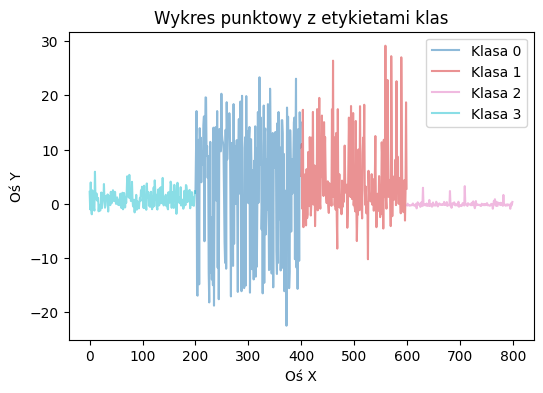

In [23]:
def show_labels_of_dataset(X, y):
  # Ustalamy unikalne etykiety
    unique_labels = np.unique(y)
    
    # Wybieramy kolory dla każdej klasy
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    # Tworzenie wykresu punktowego
    plt.figure(figsize=(6, 4))
    
    for i, label in enumerate(unique_labels):
        # Wybieranie punktów dla danej klasy
        ix = np.array(np.where(label == y)).reshape(-1)
        mask = (y == label)
        plt.plot(ix, X[mask, 0], color=colors[i], label=f'Klasa {label}', alpha=0.5)
    
    # Dodanie tytułu i etykiet osi
    plt.title('Wykres punktowy z etykietami klas')
    plt.xlabel('Oś X')
    plt.ylabel('Oś Y')
    
    # Dodanie legendy
    plt.legend()
    
    # Wyświetlenie wykresu
    plt.show()

show_labels_of_dataset(X_train, y_train)

In [24]:
# Visualise Loaded Data
def visualise_loaded_data(data):
    # Create a 2x3 grid of subplots
    c = data.shape[1]
    fig, axs = plt.subplots(4, 3, figsize=(15, 10))

    for i in range(c):
        # Plot different data on each subplot
        axs[int(i/3), i%3].plot(data[:,i])
        axs[int(i/3), i%3].set_title(f'param {i}')
        
    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()

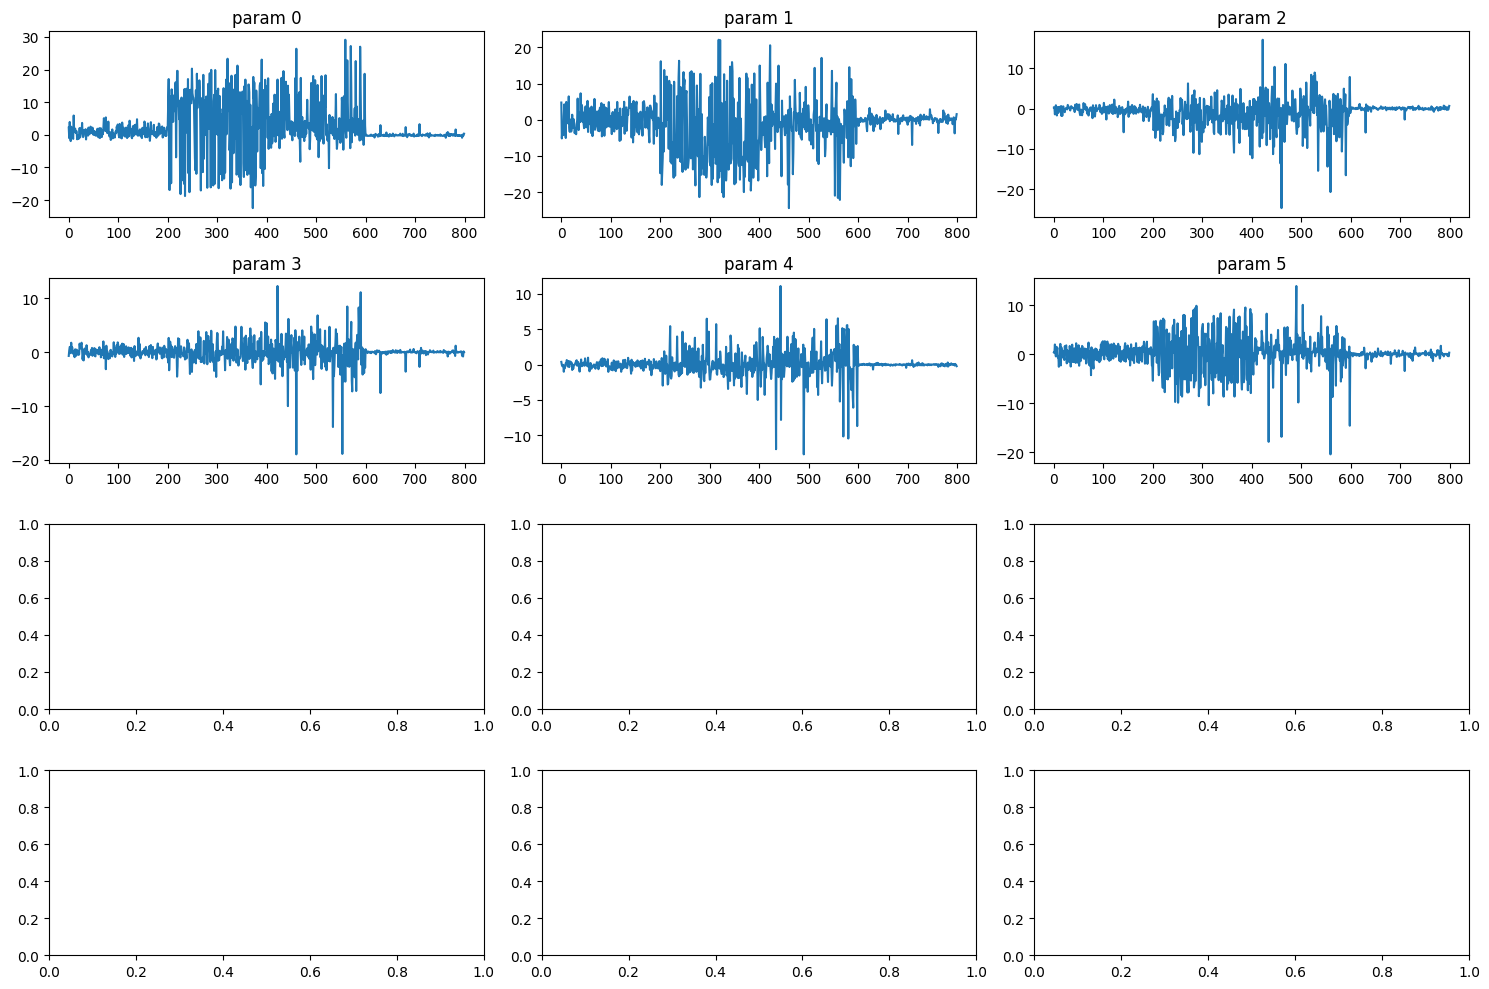

In [25]:
# Wizualizacja każdego wymiaru danych z osobna po potasowaniu.
visualise_loaded_data(X_train)

### Tasowanie danych


In [26]:
# Tworzymy chunki z całkowicie potasowanymi danymi. Segmenty posiadają różne elementy z różnych klas

from sklearn.utils import shuffle

def shuffle_dataset(X_train, y_train):
    # Losowo przetasowujemy X_train i y_train w sposób spójny
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)
    return X_train_shuffled, y_train_shuffled

In [27]:
X_train_shuffled, y_train_shuffled = shuffle_dataset(X_train, y_train)
X_test_shuffled, y_test_shuffled = shuffle_dataset(X_test, y_test)

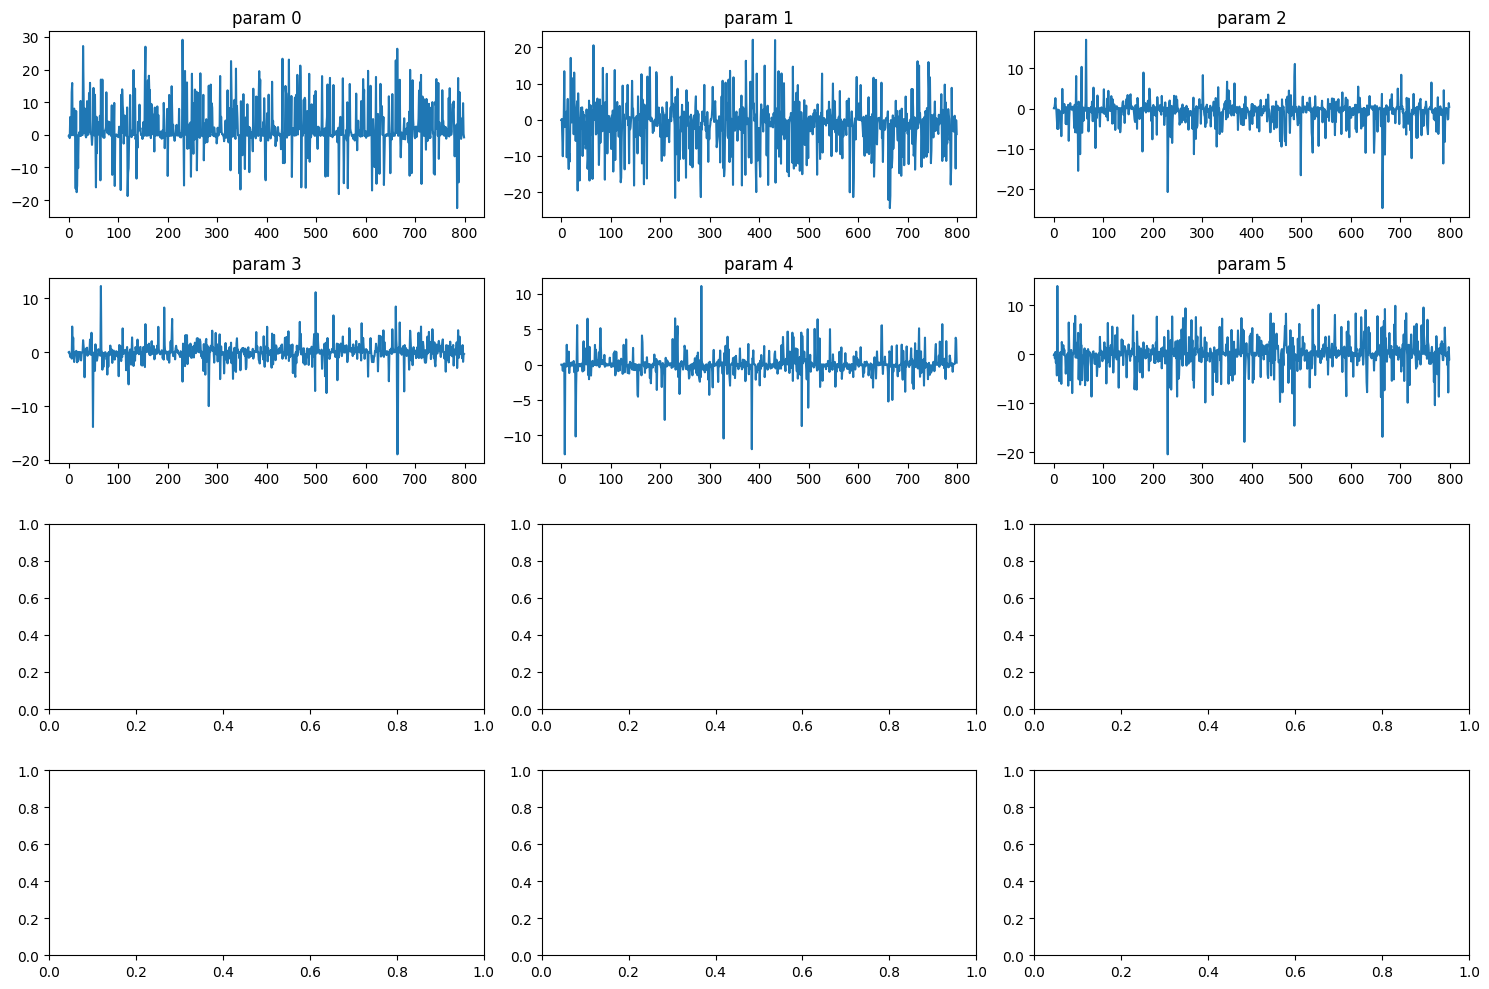

In [28]:
# Wizualizacja każdego wymiaru danych z osobna po potasowaniu.
visualise_loaded_data(X_train_shuffled)

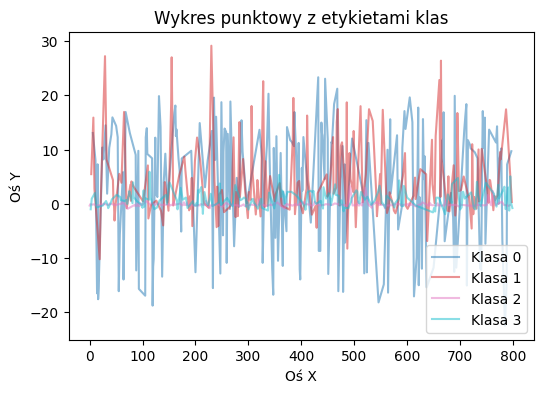

In [29]:
show_labels_of_dataset(X_train_shuffled, y_train_shuffled)

### Punkty inicjalizacyjne i macierze semi_supervised

In [30]:
# Dla każdej klasy znajdź punkt średni.
def average_by_class(X, y):
    # Unikalne klasy w y
    classes = np.unique(y)
    
    # Słownik do przechowywania średnich dla każdej klasy
    class_averages = {}
    
    for cls in classes:
        # Wybieramy indeksy odpowiadające danej klasie
        indices = np.where(y == cls)
        
        # Wybieramy punkty z X odpowiadające danej klasie
        class_points = X[indices]
        
        # Obliczamy średnią dla danej klasy
        class_avg = np.mean(class_points, axis=0)
        
        # Dodajemy średnią do słownika
        class_averages[cls] = class_avg
    
    return class_averages


In [31]:
# Tworzy clustry na podstawie średnich punktów dla każdej klasy. Dla każdej klasy generuje kilka punktów z lekkim odchyleniem od średniego punktu dla danej klasy.
# Punkty wygenerowane sumują się do n_clusters.
def generate_clusters_proportional(average_points, n_clusters, deviation=0.1):
    """
    average_points: słownik zawierający średnie punkty dla każdej klasy
    n_clusters: łączna liczba punktów do wygenerowania dla wszystkich klas
    deviation: maksymalne odchylenie od średniej, domyślnie 0.1 (10%)
    
    Zwraca: słownik zawierający generowane punkty dla każdej klasy
    """
    # Liczba klas
    num_classes = len(average_points)
    
    # Początkowy przydział punktów do klas (podział równomierny)
    points_per_class = [n_clusters // num_classes] * num_classes
    
    # Jeśli n_clusters nie jest podzielne przez num_classes, rozdysponuj pozostałe punkty
    remainder = n_clusters % num_classes
    for i in range(remainder):
        points_per_class[i] += 1
    
    # Generowanie punktów dla każdej klasy
    generated_points = []

    # Dla każdego centroida przyporządkowana informacja o klasie
    class_of_centroid = []

    # Dla każdej klasy zwraca listę centroidów (jeden bądź wiele punktów)
    clusters_for_each_class = {}
    indicies_start = 0
    
    for i, (cls, avg_point) in enumerate(average_points.items()):
        # Liczba punktów do wygenerowania dla danej klasy
        points_count = points_per_class[i]
        
        # Tworzymy losowe odchylenie dla każdego wymiaru
        deviations = np.random.randn(points_count, avg_point.size) * deviation
        
        # Generujemy punkty z lekkim odchyleniem od średniej
        points = avg_point + deviations

        clusters_for_each_class[cls] = range(indicies_start,indicies_start + points_per_class[i])
        
        indicies_start += points_per_class[i]
        # Przechowujemy wygenerowane punkty w słowniku
        for point in points:
            generated_points.append(point)
            class_of_centroid.append(cls)
    
    return np.array(generated_points), np.array(class_of_centroid), clusters_for_each_class


In [32]:
# Metoda tworząca z wektora labelów tablicę labelów potrzebną do implementacji algorytmu SSFCM.
def label_vector_to_semi_supervised_matrix(y, n_clusters, clusters_for_each_class,  procent_of_data=0.5):
    array = np.zeros((len(y), n_clusters))

    for i, label in enumerate(y):
        
        if(i >= len(y)*procent_of_data):
            break

        injection_power = 1 / len(clusters_for_each_class[label]) - 0.05
        for element in clusters_for_each_class[label]:
            array[i, element] = injection_power
            
    return array

# Tworzy macierz do uczenia nadzorowanego. Przydziela kilka klastrów do danej klasy.
# Injection to procent danych jakie labelujemy
# Zwraca punkty stworzone przez funkcje generate_clusters_proportional.
def create_semi_supervised_matrix(X, y, n_clusters, injection=injection):

    average_classes = average_by_class(X, y)

    init_centroids, class_of_centroid, clusters_for_each_class = generate_clusters_proportional(average_classes, n_clusters, deviation=0.1)

    y_matrix = label_vector_to_semi_supervised_matrix(y_train, n_clusters, clusters_for_each_class, injection)

    return y_matrix, init_centroids, clusters_for_each_class

def upload_semi_supervised_matrix(y, new_cluster_id, clusters_for_each_class, n_clusters):

    idx = len(clusters_for_each_class)
    
    for i in range(len(clusters_for_each_class)):
        k = clusters_for_each_class[i].stop 
        n = clusters_for_each_class[i].start
        if new_cluster_id in clusters_for_each_class[i]:
            clusters_for_each_class[i] = range(n, k+1)
            idx = i
        if i > idx:
            clusters_for_each_class[i] = range(n+1,k+1)
    
    y_matrix = label_vector_to_semi_supervised_matrix(y, n_clusters, clusters_for_each_class, injection)
    
    return y_matrix, clusters_for_each_class



In [33]:
# Inicjalizacja centroidów oraz stworzenie y_matrix_label dla odmian algorytmu semi-supervised.
y_train_matrix, init_centroids, clusters_for_each_class = create_semi_supervised_matrix(X_train, y_train, n_clusters)

y_train_matrix_shuffled, init_centroids_shuffled, clusters_for_each_class_shuffled = create_semi_supervised_matrix(X_train_shuffled, y_train_shuffled, n_clusters, injection=injection)

### Tworzenie chunków

In [34]:
from libraries.chunks import create_chunks, create_dataset_chunks

In [35]:
# Dzielimy dane oraz labele na chunki długości elementów listy chunk_train_sizes (ew. test)
chunks, chunks_y, chunks_y_matrix = create_dataset_chunks(chunk_train_sizes, X_train, y_train, y_train_matrix)
chunks_test, chunks_test_y, _ = create_dataset_chunks(chunk_test_sizes, X_test, y_test)

In [36]:
from collections import Counter

def find_most_common_class(chunks):
    most_common_classes = []
    for chunk in chunks:
        if chunk is not None:  # Sprawdź, czy chunk nie jest pusty
            # Liczymy wystąpienia elementów w chunku
            counter = Counter(chunk)
            # Znajdujemy najczęściej występujący element
            most_common = counter.most_common(1)[0][0]
            most_common_classes.append(int(most_common))
        else:
            most_common_classes.append(None)  # Jeśli chunk jest pusty, zwracamy None
    return most_common_classes

In [37]:
chunks_classification_train = find_most_common_class(chunks_y)
chunks_classification_test = find_most_common_class(chunks_test_y)

In [38]:
# Dzielimy dane oraz labele na chunki długości elementów listy chunk_train_sizes (ew. test)
chunks_shuffled, chunks_y_shuffled, chunks_y_matrix_shuffled = create_dataset_chunks(chunk_train_sizes, X_train_shuffled, y_train_shuffled, y_train_matrix_shuffled)
chunks_test_shuffled, chunks_test_y_shuffled, _ = create_dataset_chunks(chunk_test_sizes, X_test_shuffled, y_test_shuffled)

# Metody klastrujące biblioteczne

### Fuzzy cmeans

In [39]:
# tutaj gotowe algorytmu fcm i odmiany


### KNN

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [41]:
def select_subset(X_train, y_train, p):
    # Obliczamy rozmiar podzbioru (p% danych)
    subset_size = int(p * len(X_train))
    
    # Wybieramy p% danych z X_train i y_train z zachowaniem proporcji klas
    X_subset, _, y_subset, _ = train_test_split(X_train, y_train, 
                                                train_size=subset_size, 
                                                stratify=y_train, 
                                                random_state=42)
    return X_subset, y_subset

In [42]:
def knn_with_library(X_train, y_train, k=3):

    # Tworzymy model k-NN
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Trenujemy model na danych treningowych
    knn.fit(X_train, y_train)
    return  knn

# Algorytm IFCM

Importowanie funkcji bibliotecznych. Implementacja własna

In [43]:
from libraries.IFCM import incremental_fuzzy_cmeans_predict
from libraries.IFCM import incremental_fuzzy_cmeans

# Algorytm ISSFCM

Importowanie funkcji bibliotecznych. Implementacja własna

In [44]:
from libraries.ISSFCM import incremental_semi_supervised_fuzzy_cmeans_predict
from libraries.ISSFCM import incremental_semi_supervised_fuzzy_cmeans

# Algorytm DISSFCM


In [45]:
from scipy.spatial.distance import cdist
from libraries.diagnosis_tools import DiagnosisTools, Multilist
import random
from libraries.DISSFCM import dynamic_incremental_semi_supervised_fuzzy_cmeans_predict
from libraries.DISSFCM import dynamic_incremental_semi_supervised_fuzzy_cmeans
from libraries.DISSFCM import reconstruction_error, split_centroids
from libraries.DISSFCM import dynamic_local_train_incremental_semi_supervised_fuzzy_cmeans
from libraries.DISSFCM import dynamic_train_incremental_semi_supervised_fuzzy_cmeans

# Metody wizualizacji danych

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import random
from tqdm import tqdm

### Wizualizacja danych ze zredukowanymi wymiarami

In [47]:
from libraries.plot_functions import simple_plot, plot_pca, plot_pca_cluster, plot_pca_knn, plot_heatmap, plot_tsne, plot_mds

### Wizualizacja zestawów danych

In [48]:
from libraries.plot_functions import plot_centroids, plot_two, visualize_all, prepare_diagnosis_data_for_plotting, overview_plot, plot_multiple_functions, plot_lists_inside_lists

# Predykcja i Validacja danych

### Validacja

In [49]:
from libraries.valid_data import calculate_statistics, most_frequent_in_segments, classify_data_segment
from libraries.valid_data import valid_data_ifcm, valid_data_issfcm, valid_data_dissfcm, valid_data_fcm, valid_data_knn

### Predykcja

In [50]:
from libraries.DISSFCM import predict_data_dissfcm
from libraries.ISSFCM import predict_data_issfcm
from libraries.IFCM import predict_data_ifcm

# Przypisywanie clustrów do klas

In [51]:
from libraries.classify_segments import validate_segments, validate_segments_knn

### Zliczanie popularności danych clustrów

In [52]:
from libraries.clusters import count_points_for_clusters, sum_probability_for_clusters, popularity_of_clusters

### Knn i głosowanie większościowe

In [53]:
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.spatial.distance import cdist

from collections import Counter
import numpy as np

from libraries.IFCM import create_labels as create_labels_simple
from scipy import stats

def assign_clusters_to_classes(fuzzy_labels, centroids, y, n_classes):
    # Zliczam pierwsze punkty do jakich klas należą, następnie dopiero patrzę na segmenty.
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    count_points = np.zeros((centroids.shape[0], n_classes))
    
    for i, label in enumerate(cluster_membership):
        count_points[label, y[i]] += 1

    # Zwracamy tablicę z przyporządkowanymi klasami dla każdego clustra.
    return np.argmax(count_points, axis=1)


def assign_class_to_points(fuzzy_labels, cluster_to_class):
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    result = np.zeros(len(cluster_membership), dtype=fuzzy_labels.dtype)

    result[:] = cluster_to_class[cluster_membership]
    return result


def classify_points(trained_x, trained_y, validation_x, validation_y, centroids, metric, m, n_classes, classify_whole_segment = False, validation_x_chunked = None):
    # przynależności wszystkich punktów ze zbioru treningowego do centroidów
    fuzzy_labels_trained = create_labels(trained_x, centroids, metric, m)
    
    # przynależność klastrów do klas
    cluster_to_class = assign_clusters_to_classes(fuzzy_labels_trained, centroids, trained_y, n_classes)
    
    # przynależność wszystkich punktów ze zbioru walidacyjnego do centroidów
    fuzzy_labels_val = create_labels(validation_x, validation_y.T ,centroids, metric, m)

    validation_classified = None
    # wyznaczanie klas na podstawie przynależności do centroidów dla zbioru walidacyjnego
    if classify_whole_segment:
        validation_classified = []

        for chunk in validation_x_chunked:
            fuzzy_labels_chunk = create_labels(chunk, centroids, metric, m)
            chunk_classified = assign_class_to_points(fuzzy_labels_chunk, cluster_to_class)
            mode_value, count = stats.mode(chunk_classified)
            
            validation_classified.append(np.full(chunk_classified.shape, mode_value))
        validation_classified = np.concatenate(validation_classified)  
    else:
        validation_classified = assign_class_to_points(fuzzy_labels_val, cluster_to_class)
    
    return validation_classified
    

def majority_vote_with_elimination(class_vectors, n_classes):
    """
    Przeprowadza głosowanie większościowe z eliminacją najmniej popularnych klas.
    
    Args:
    class_vectors (list of list): Lista wektorów indeksów klas uporządkowanych według przynależności
                                  dla każdego punktu walidacyjnego.
    
    Returns:
    int: Ostateczna wybrana klasa po głosowaniu.
    """
    counter = 0
    #print(class_vectors)
    mark_deletion = np.zeros(n_classes)
    while True:
        # Zliczanie pierwszych klas (najbardziej przynależnych) dla wszystkich punktów
        first_choices = [classes[0] for classes in class_vectors if classes.size > 0]
        class_counter = Counter(first_choices)
        
        # Sprawdzenie, czy mamy jedną dominującą klasę
        if len(class_counter) == 1:
            return first_choices  # Zwróć dominującą klasę
        
        # Znajdź najmniej popularną klasę (lub klasy, jeśli są remisowe)
        min_count = min(class_counter.values())
        least_common_classes = [cls for cls, count in class_counter.items() if count == min_count]

        # Dla każdej klasy do usunięcia
        for cls_to_remove in least_common_classes:
            mark_deletion[cls_to_remove] = 1
            #print("Klasa do usuniecia: ", cls_to_remove)
            # Przejdź przez każdy punkt walidacyjny
            for i, classes in enumerate(class_vectors):
                # Jeśli pierwsza klasa jest tą do usunięcia, usuń ją
                if classes.size > 0 and mark_deletion[classes[0]] == 1:
                    #print("Usuwam: ", classes[0])
                    class_vectors[i] = np.delete(classes, 0)

        # Sprawdź, czy wszystkie wektory klas zostały wyeliminowane
        if all(classes.size == 0 for classes in class_vectors):
            return None  # Zwróć None, jeśli wszystkie klasy zostały wyeliminowane

        if counter >= 4:
            # Zwróć pierwszą klasę, która pozostała na końcu eliminacji
            return first_choices
        
        counter += 1
def classify_with_knn_eliminate_minor(train_matrix, val_matrix, k, prototype_to_class, n_classes):
    """
    Klasyfikuje dane walidacyjne na podstawie k najbliższych sąsiadów z użyciem macierzy przynależności.
    
    Args:
    val_matrix (numpy.ndarray): Macierz przynależności danych walidacyjnych, rozmiar [n_val x K].
    train_matrix (numpy.ndarray): Macierz przynależności danych treningowych, rozmiar [n_train x K].
    k (int): Liczba najbliższych sąsiadów do znalezienia.
    prototype_to_class (list): Lista mapująca każdy prototyp na odpowiednią klasę.
    
    Returns:
    list: Lista sklasyfikowanych klas dla każdej serii czasowej z walidacji.
    """

    n_val = val_matrix.shape[1]
    n_train = train_matrix.shape[1]
    
    classified_labels = []
    
    for i in range(n_val):
        val_series = val_matrix[:, i]
        
        # Oblicz odległość euklidesową między i-tym rzędem w val_matrix a każdym rzędem w train_matrix
        v_expanded = val_series[:, np.newaxis]  # Kształt: (8, 1)

        # Oblicz różnicę pomiędzy punktami a wektorem
        diff = train_matrix - v_expanded
        
        # Oblicz dystans Euklidesowy
        distances = np.sqrt(np.sum(diff**2, axis=0))
        
        # Znajdź indeksy k najmniejszych wartości (najbliższych sąsiadów)
        k_nearest_indices = np.argsort(distances)[:k]
        
        class_to_max_prototype = np.zeros(n_classes)
        
        for idx in k_nearest_indices:
            # Sortuj prototypy według wartości przynależności malejąco dla danego sąsiada
            sorted_prototypes = np.argsort(train_matrix[:, idx])[::-1]
            
            for prototype_idx in sorted_prototypes:
                # Mapuj prototyp na odpowiednią klasę
                mapped_class = prototype_to_class[prototype_idx]
                
                # Jeśli klasa nie była jeszcze dodana lub obecny prototyp ma większą przynależność, zaktualizuj
                if class_to_max_prototype[mapped_class] == 0 or class_to_max_prototype[mapped_class] < train_matrix[prototype_idx, idx]:
                    class_to_max_prototype[mapped_class] = train_matrix[prototype_idx, idx]
                else:
                    break  # Ponieważ sortowanie jest malejące, dalsze prototypy będą miały mniejszą przynależność
        
        sorted_class_indices = np.argsort(class_to_max_prototype)[::-1]       
        # Zlicz klasy k najbliższych sąsiadów
        #class_counter = Counter(k_nearest_classes)
        
        # # Zwróć klasy uporządkowane od najczęstszej do najmniej częstej
        # sorted_classes = [cls for cls, count in class_counter.most_common()]
        #print("sorted_class_indices")
        #print(sorted_class_indices)
        classified_labels.append(sorted_class_indices)
    
    # Przeprowadź głosowanie większościowe z eliminacją
    final_class = majority_vote_with_elimination(classified_labels, n_classes)
    
    return final_class


def classify_points_knn_eliminate_minor_class(chunks, chunks_y, chunks_validation_x, chunks_validation_y, centroids, metric, m, n_classes, classify_whole_segment = False, validation_x_chunked = None, validation_y_chunked = None,  k = 7):
    # przynależności wszystkich punktów ze zbioru treningowego do centroidów
    trained_x, trained_y = merge_chunks(chunks, chunks_y)

    validation_x, validation_y = merge_chunks(chunks_validation_x, chunks_validation_y)
    
    #fuzzy_labels_trained = create_labels(trained_x, trained_y.T, centroids, metric, m)
    _, fuzzy_labels_trained = predict_data_dissfcm(trained_x, centroids)

    # przynależność klastrów do klas
    cluster_to_class = assign_clusters_to_classes(fuzzy_labels_trained, centroids, trained_y, n_classes)

    # przynależność wszystkich punktów ze zbioru walidacyjnego do centroidów
    #fuzzy_labels_val = create_labels_simple(validation_x ,centroids, metric, m)
    fuzzy_labels_val = predict_data_dissfcm(validation_x, centroids)


    validation_classified = None
    validation_classified_chunks_before_voting = []
    validation_classified_chunks_majority = []
    # wyznaczanie klas na podstawie przynależności do centroidów dla zbioru walidacyjnego
    #if classify_whole_segment:
    validation_classified_chunks_majority = []

    itr = 0
    for chunk in validation_x_chunked:
        _, fuzzy_labels_chunk = predict_data_dissfcm(chunk, centroids)
        chunk_classified = classify_with_knn_eliminate_minor(fuzzy_labels_trained, fuzzy_labels_chunk, k, cluster_to_class, n_classes)  
        #print("wynik glosowania")
        #print(chunk_classified)

        mode_value, count = stats.mode(chunk_classified)
            
          
        majority = np.full(len(chunk_classified), mode_value)
            
        validation_classified_chunks_majority.append(majority)
        validation_classified_chunks_before_voting.append(chunk_classified)
            
    validation_classified = np.concatenate(validation_classified_chunks_majority)  
    #validation_classified_chunks_before_voting = np.concatenate(validation_classified_chunks_before_voting)  
    #else:
    #    validation_classified = classify_with_knn(fuzzy_labels_trained, fuzzy_labels_val, k ,cluster_to_class, n_classes)
    return validation_classified, validation_classified_chunks_before_voting, validation_classified_chunks_majority, cluster_to_class , fuzzy_labels_val
    


# Testowanie algorytmu FCM i innych algorytmów bez funkcjonalności inkrementacyjnej

In [54]:
def create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, statistics):
    return {
        'Silhouette Score': silhouette_avg,
        #'Davies-Bouldin Score': davies_bouldin_avg,
        'Rand Score': rand,
        'Tested fpc': fpc,
        'Accuracy': statistics['Accuracy'],
        'Precision': statistics['Precision'],
        'Recall': statistics['Recall']
    }

def compare_models_statistics(statistics):
    # Wyciągamy wszystkie nazwy modeli
    models = list(statistics.keys())
    
    # Wyciągamy wszystkie nazwy metryk (przyjmujemy, że wszystkie modele mają te same metryki)
    metrics = list(statistics[models[0]].keys())
    
    # Tworzymy macierz wyników
    results = np.array([[statistics[model][metric] for model in models] for metric in metrics])
    
    # Ustawienia wykresu
    x = np.arange(len(metrics))  # Pozycje na osi X
    width = 0.15  # Szerokość słupków
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Tworzymy słupki dla każdego modelu
    for i, model in enumerate(models):
        ax.bar(x + i * width, results[:, i], width, label=model)
    
    # Dodajemy etykiety i tytuły
    ax.set_xlabel('Metryki')
    ax.set_ylabel('Wartość')
    ax.set_title('Porównanie statystyk różnych modeli')
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    # Wyświetlamy wykres
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Algorytm biblioteczny FCM
Silhouette Score: 0.25354547949345785
Davies-Bouldin Score: 1.168091154576511
Rand Score: 0.7485849056603774
Tested fpc: 0.44869207084430707
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
8


C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


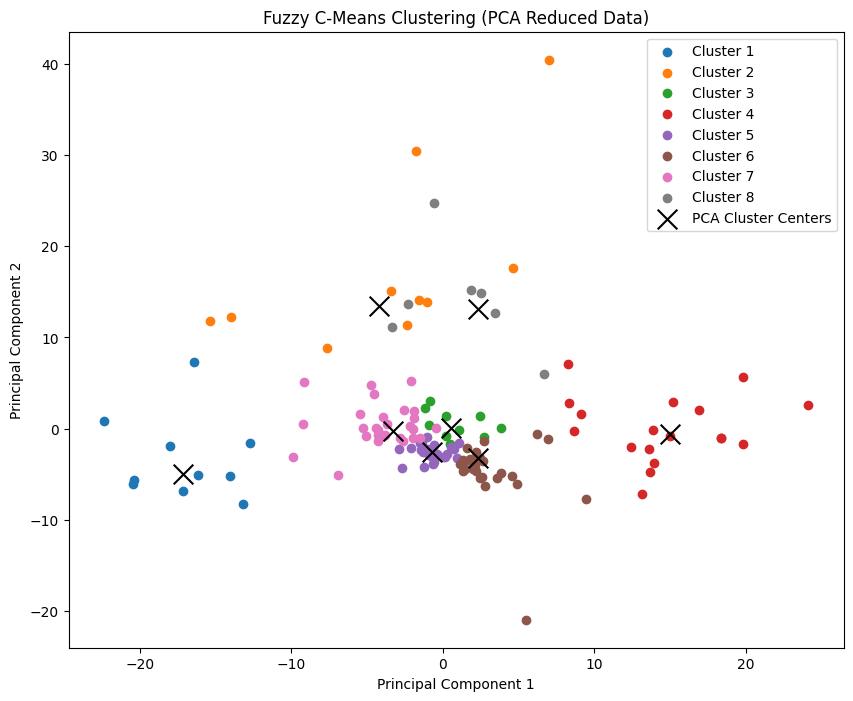

Czas wykonania: 0.2700328826904297 sekund
Własna implementacja FCM
Silhouette Score: 0.2523314134236908
Davies-Bouldin Score: 1.16581161393042
Rand Score: 0.7529874213836478
Tested fpc: 0.4489399958341057
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
8


C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


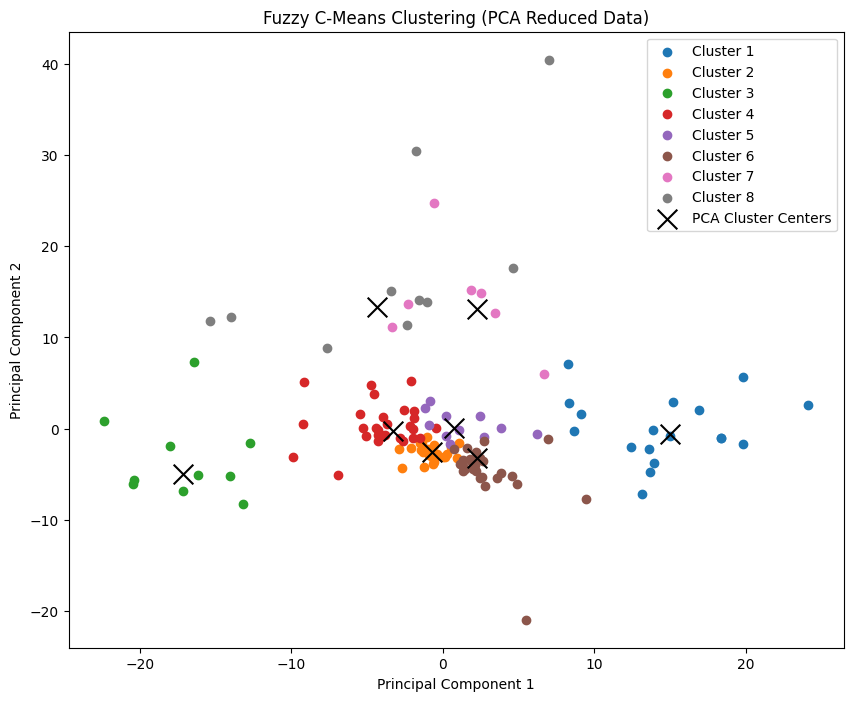

Czas wykonania: 0.32899928092956543 sekund
Algorytm SSFCM
Silhouette Score: 0.24011068927670537
Davies-Bouldin Score: 1.2045213660132974
Rand Score: 0.7506289308176101
Tested fpc: 0.45805439692607824
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
8


C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


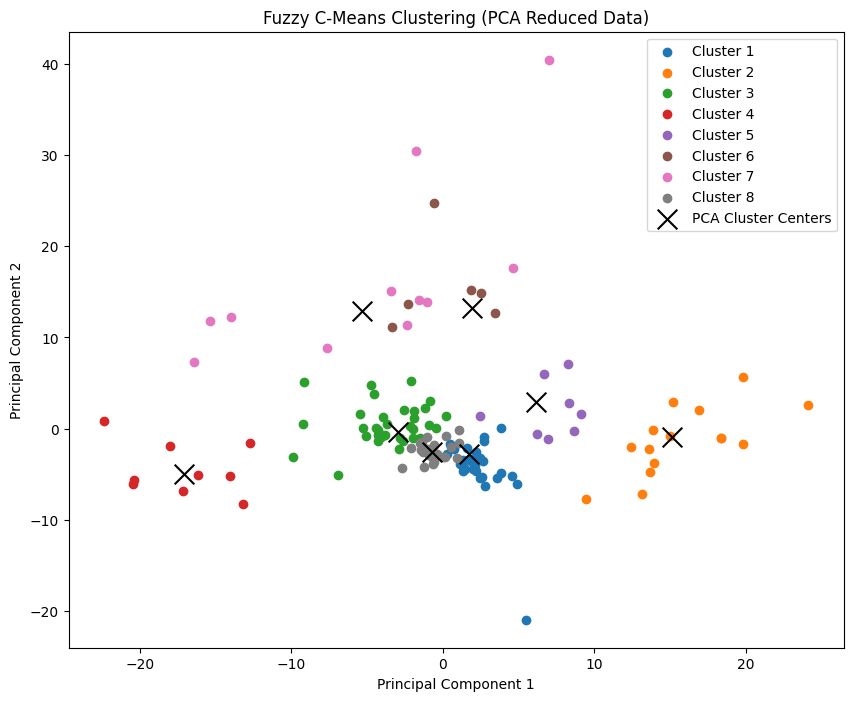

Czas wykonania: 0.24398112297058105 sekund


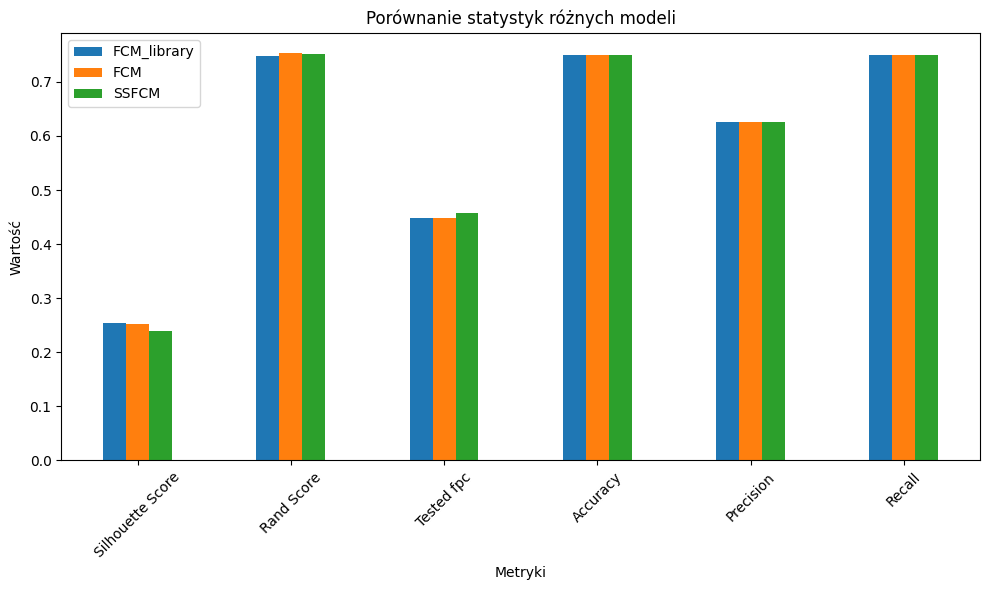

In [55]:
import time
models = {}
plot_func = plot_pca
metric = 'euclidean'

###########################################################################################################
# Początek pomiaru czasu
start_time = time.time()

# Testowanie bibliotecznego modelu fcm
print('Algorytm biblioteczny FCM')
centroids, fuzzy_labels, u0, d, jm, p, fpc = cmeans(X_train.T, c=n_clusters, m=m, error=g_error, maxiter=1000, init=None)

silhouette_avg, davies_bouldin_avg, rand, fpc, stats, cluster_to_class, fuzzy_labels = valid_data_fcm(chunks_test, centroids, chunks_test_y, m, g_error)

plot_func(X_test, centroids, fuzzy_labels)

models['FCM_library'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, stats)

# Koniec pomiaru czasu
end_time = time.time()

# Wyświetlenie czasu wykonania
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

###########################################################################################################
from libraries.IFCM import cmeans0

# Początek pomiaru czasu
start_time = time.time()

# Testowanie własnej implementacji fcm
print('Własna implementacja FCM')
centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(X_train, c=n_clusters, m=m, error=g_error, maxiter=1000, metric = metric, init_centroid=None)

silhouette_avg, davies_bouldin_avg, rand, fpc, stats, cluster_to_class, fuzzy_labels = valid_data_ifcm(chunks_test, centroids, chunks_test_y, m, g_error)

plot_func(X_test, centroids, fuzzy_labels)

models['FCM'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, stats)

# Koniec pomiaru czasu
end_time = time.time()

# Wyświetlenie czasu wykonania
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

###########################################################################################################
# Testowanie własnej implementacji semi-supervised fcm

# Początek pomiaru czasu
start_time = time.time()

print('Algorytm SSFCM')
centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_semi_supervised_fuzzy_cmeans(X_train, y_train_matrix, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=None)

silhouette_avg, davies_bouldin_avg, rand, fpc, stats, cluster_to_class, fuzzy_labels = valid_data_issfcm(chunks_test, centroids, chunks_test_y, m, g_error)

plot_func(X_test, centroids, fuzzy_labels)

models['SSFCM'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, stats)

# Koniec pomiaru czasu
end_time = time.time()

# Wyświetlenie czasu wykonania
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

###########################################################################################################
## Testiwabeu knn 
#
## Początek pomiaru czasu
#start_time = time.time()
#
#k = 5
#print(f'KNN   k = {k}')
#knn_model = knn_with_library(X_train, y_train, k)
#
#silhouette_avg, davies_bouldin_avg, rand, fpc, statistics = valid_data_knn(chunks_test, chunks_test_y, knn_model, m=m, error=g_error)
#
#models['KNN'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, statistics)
#
## Koniec pomiaru czasu
#end_time = time.time()
#
## Wyświetlenie czasu wykonania
#execution_time = end_time - start_time
#print(f"Czas wykonania: {execution_time} sekund")
#
############################################################################################################
## Testowanie knn 
#
## Początek pomiaru czasu
#start_time = time.time()
#
#print(f'KNN z 40% danymi treningowymi, k = {k}')
#
#X_train_subset, y_train_subset = select_subset(X_train, y_train, p=0.3)
#
#knn_model_p = knn_with_library(X_train_subset, y_train_subset, k)
#
#silhouette_avg, davies_bouldin_avg, rand, fpc, statistics = valid_data_knn(chunks_test, chunks_test_y, knn_model_p, m=m, error=g_error)
#
#models['KNN p%'] = create_set_for_stats(silhouette_avg, davies_bouldin_avg, rand, fpc, statistics)
#
## Koniec pomiaru czasu
#end_time = time.time()
#
## Wyświetlenie czasu wykonania
#execution_time = end_time - start_time
#print(f"Czas wykonania: {execution_time} sekund")
#
############################################################################################################
## porównanie wyników
compare_models_statistics(models)

# Testowanie algorytmu DISSFCM

### Trenowanie Local DISSFCM 

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.10744346322727145
Davies-Bouldin Score: 2.498273996752662
Rand Score: 0.7240566037735849
Tested fpc: 0.19151733312255087
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
8


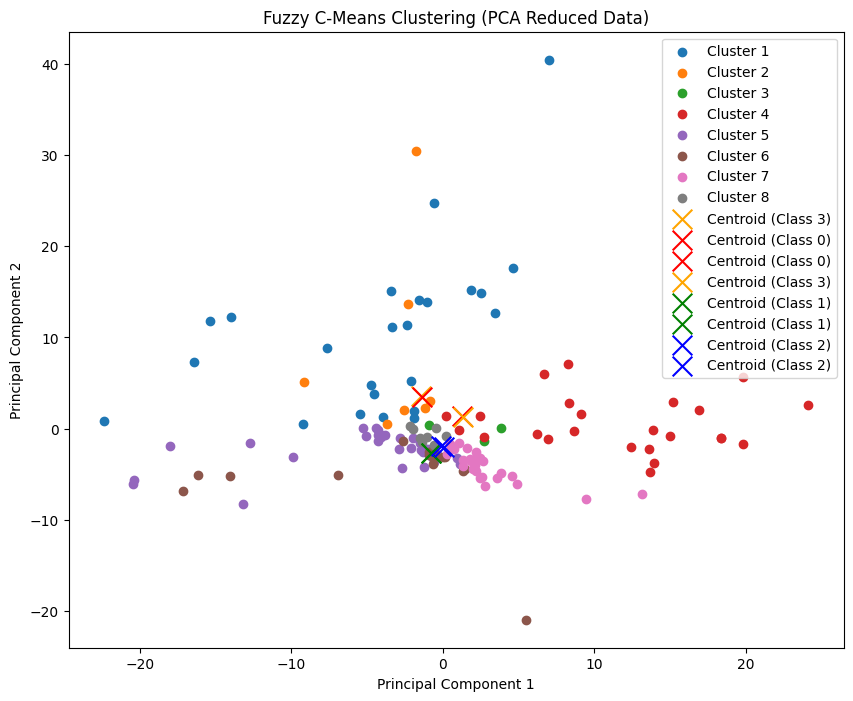

8


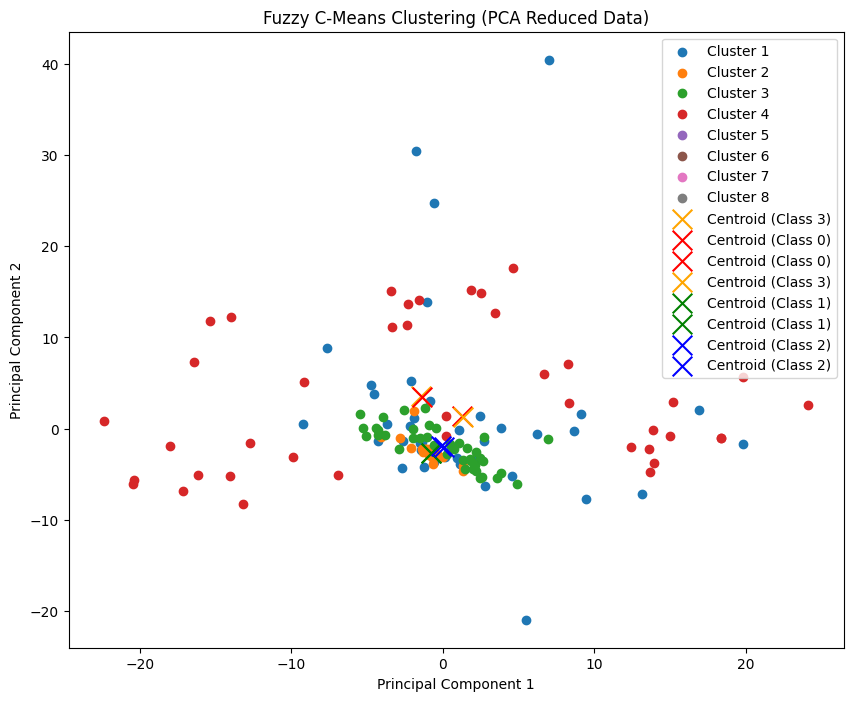

V_max 47.20425508445627
V_prevmax [0, 0, 0, 0]
{np.int64(0): range(0, 2), np.int64(1): range(2, 4), np.int64(2): range(4, 6), np.int64(3): range(6, 8)}
Rozważamy obecnie chunk numer:  0
Liczba klastrów:  8


Processing:  25%|█████████▊                             | 1/4 [00:00<?, ?it/s]

Silhouette Score: -0.09994363641917935
Davies-Bouldin Score: 2.17014295165026
Rand Score: 0.7234276729559749
Tested fpc: 0.191411348879217
Accuracy: 1.0
Precision:  1.0
Recall:  1.0
8


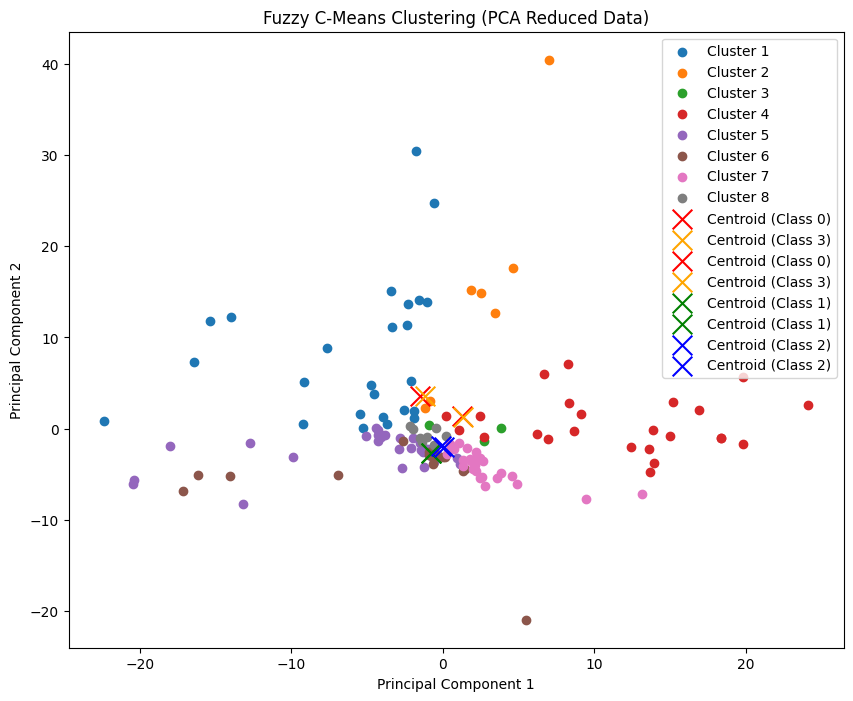

8


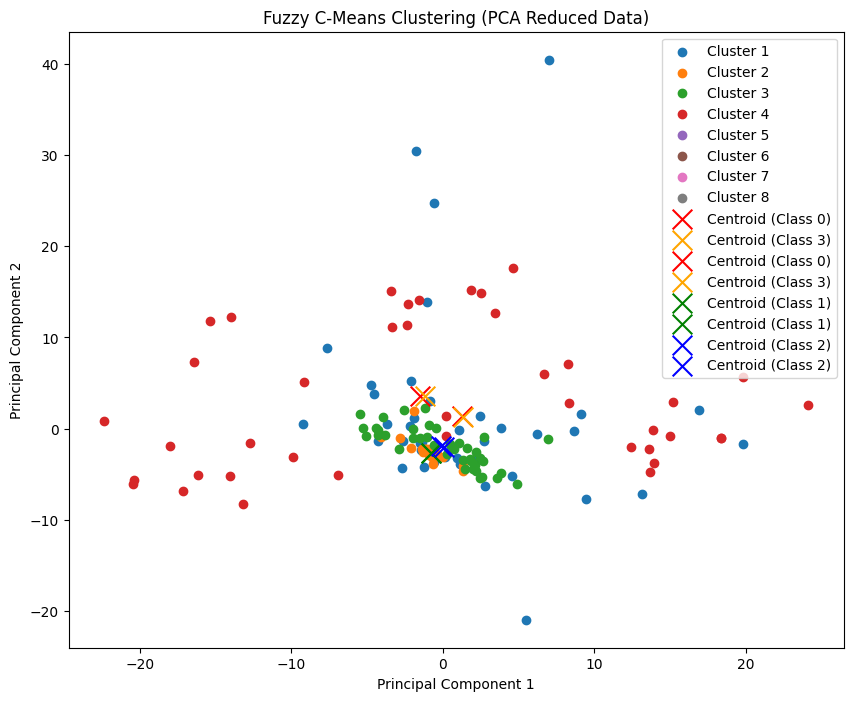

V_max 35.065489448941804
V_prevmax [0, 0, 0, np.float64(47.20425508445627)]
{np.int64(0): range(0, 2), np.int64(1): range(2, 4), np.int64(2): range(4, 6), np.int64(3): range(6, 8)}
class 0: cluster: 0
V_max 33.77941557992315
class 0: cluster: 2
V_max 55.043744422154916
class 1: cluster: 4
V_max 72.91316898608162
class 3: cluster: 10
V_max 30.847569588703617
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  12


Processing:  50%|███████████████████▌                   | 2/4 [00:00<?, ?it/s]

Silhouette Score: -0.03359689015733834
Davies-Bouldin Score: 2.1030127417977242
Rand Score: 0.754874213836478
Tested fpc: 0.16308907540960657
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
12



C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


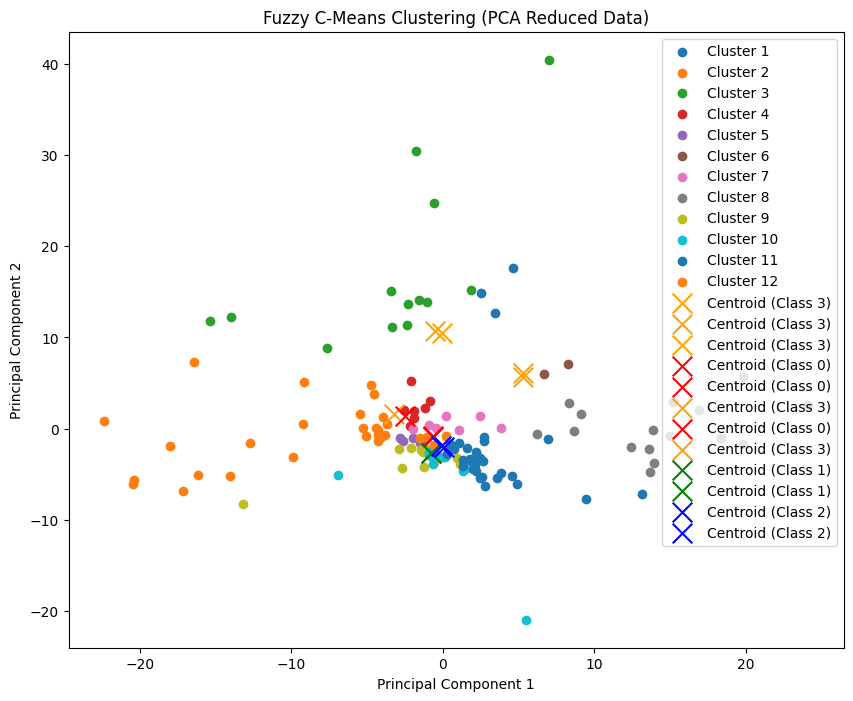

12


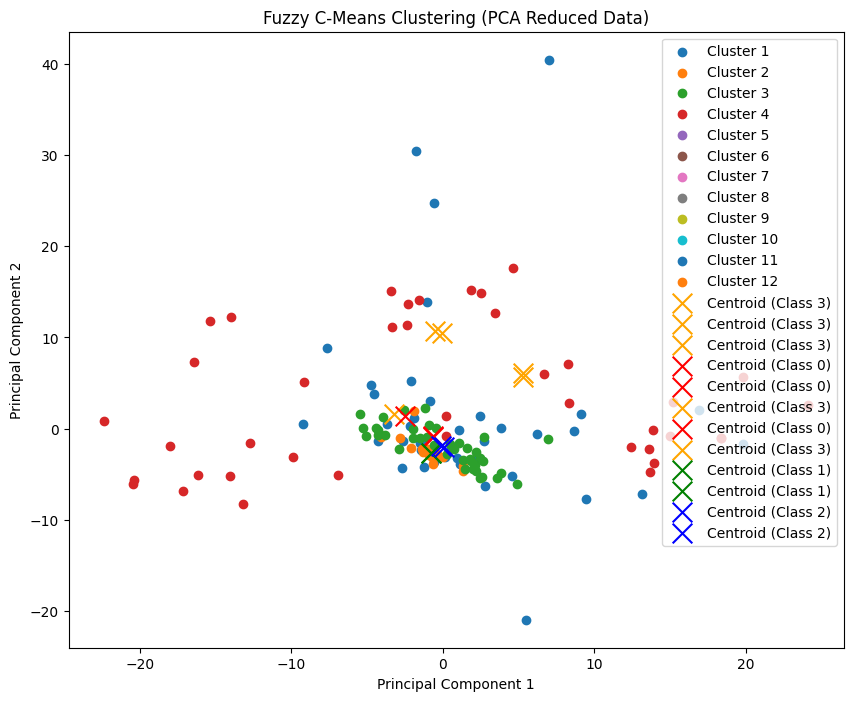

V_max 29.69566126821273
V_prevmax [0, 0, 0, np.float64(30.847569588703617)]
{np.int64(0): range(0, 4), np.int64(1): range(4, 8), np.int64(2): range(8, 10), np.int64(3): range(10, 12)}
class 0: cluster: 0
V_max 34.712471143786935
class 0: cluster: 2
V_max 28.904434719121454
class 0: cluster: 6
V_max 29.753645390268364
class 1: cluster: 9
V_max 28.415766076461733
class 1: cluster: 12
V_max 51.15457856220888
class 1: cluster: 11
V_max 22.046374379544858
class 1: cluster: 8
V_max 22.97670435266621
class 2: cluster: 16
V_max 17.516510153080162
class 2: cluster: 18
V_max 27.01139272187332
class 3: cluster: 21
V_max 38.67770307007528
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  22


Processing:  75%|█████████████████████████████▎         | 3/4 [00:00<?, ?it/s]

Silhouette Score: 0.011356571119243061
Davies-Bouldin Score: 1.630731198944638
Rand Score: 0.7688679245283019
Tested fpc: 0.16110939799688412
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
22



C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


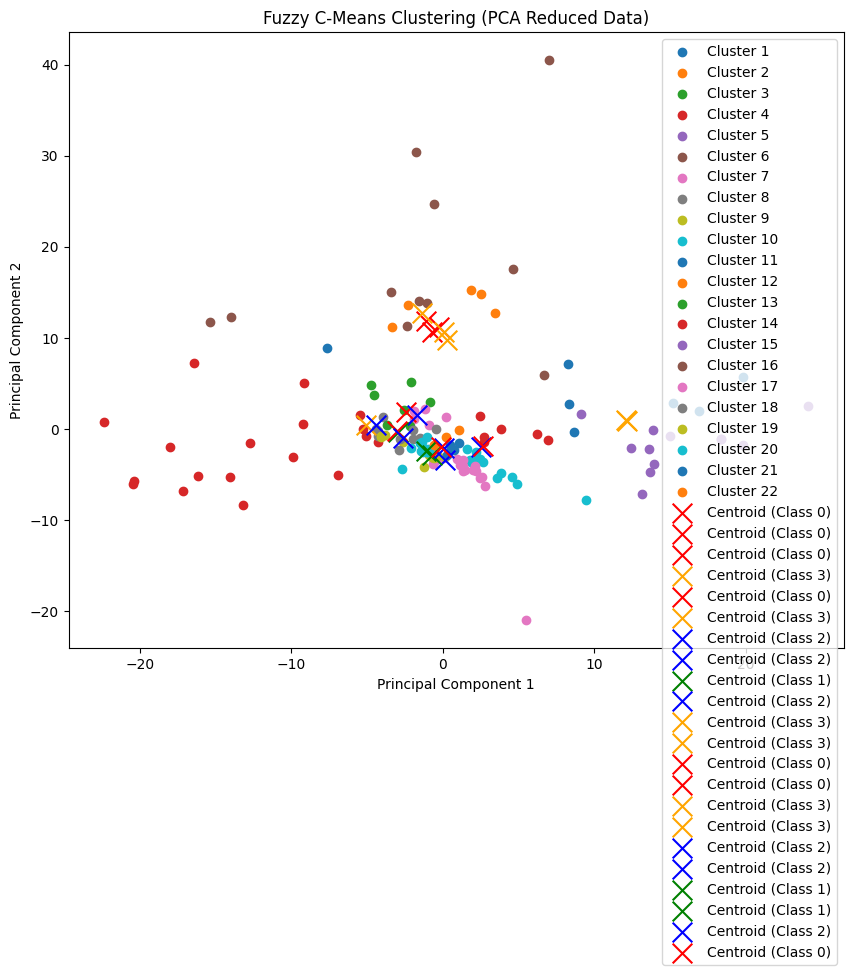

22


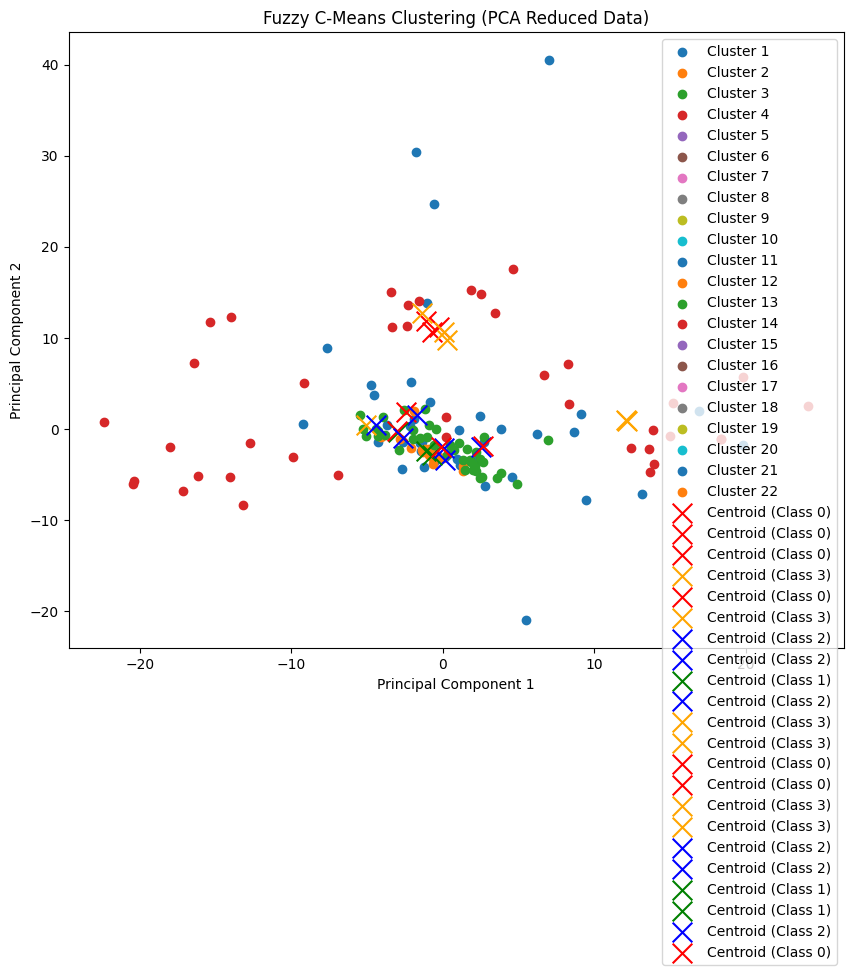

V_max 24.679091941552997
V_prevmax [0, 0, 0, np.float64(38.67770307007528)]
{np.int64(0): range(0, 8), np.int64(1): range(8, 16), np.int64(2): range(16, 20), np.int64(3): range(20, 22)}
class 0: cluster: 0
V_max 25.53973124299666
class 0: cluster: 4
V_max 22.54439525636943
class 0: cluster: 10
V_max 22.094366884970988
class 0: cluster: 2
V_max 19.4223064080663
class 0: cluster: 7
V_max 23.13971344417855
class 1: cluster: 17
V_max 25.854351514188398
class 1: cluster: 22
V_max 23.976550372421872
class 1: cluster: 16
V_max 15.554620869505532
class 1: cluster: 22
V_max 23.870862346292082
class 0: cluster: 4
V_max 19.234382960527192
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  32


Processing: 100%|███████████████████████████████████████| 4/4 [00:00<?, ?it/s]

Silhouette Score: 0.0024466787853079583
Davies-Bouldin Score: 1.5070188964876767
Rand Score: 0.7704402515723271
Tested fpc: 0.1532560688123355
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
32



C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


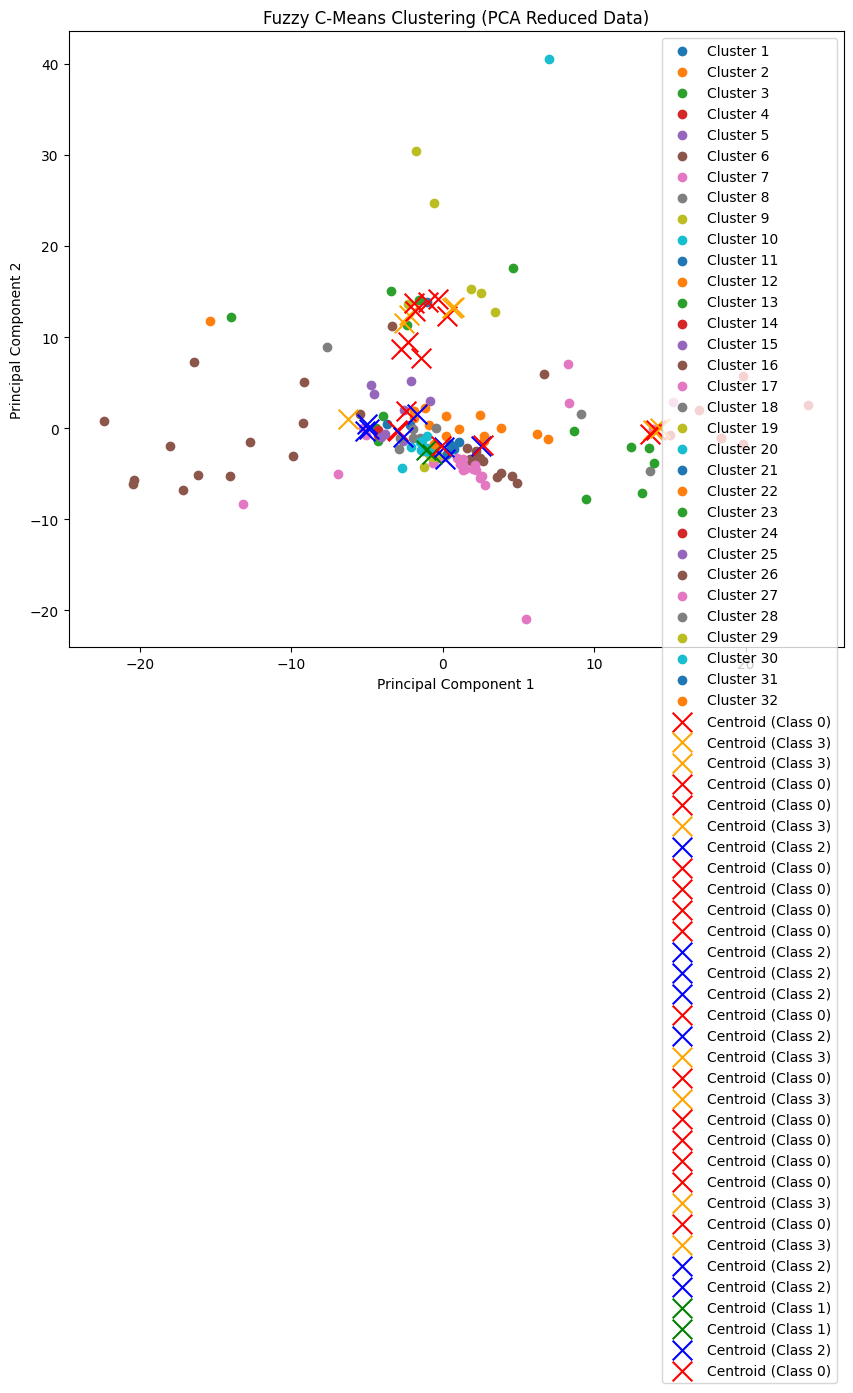

Cluster 0: counts = 1, summed_labels = 1.753114665619415, fcm per point 1.753114665619415 
Cluster 1: counts = 1, summed_labels = 1.9413230465236166, fcm per point 1.9413230465236166 
Cluster 2: counts = 5, summed_labels = 2.3175551749141188, fcm per point 0.46351103498282376 
Cluster 3: counts = 0, summed_labels = 1.862672564659659, fcm per point inf 
Cluster 4: counts = 4, summed_labels = 4.529849576495111, fcm per point 1.1324623941237777 
Cluster 5: counts = 13, summed_labels = 3.653479554730287, fcm per point 0.28103688882540667 
Cluster 6: counts = 4, summed_labels = 5.231754831665994, fcm per point 1.3079387079164986 
Cluster 7: counts = 1, summed_labels = 2.1925904177596895, fcm per point 2.1925904177596895 
Cluster 8: counts = 2, summed_labels = 1.6862395457941843, fcm per point 0.8431197728970922 
Cluster 9: counts = 1, summed_labels = 1.804135756297169, fcm per point 1.804135756297169 
Cluster 10: counts = 0, summed_labels = 1.8433849033087542, fcm per point inf 
Cluster 11:

C:\Users\kubak\Desktop\github\FuzzyClusteringAlgorithms\libraries\clusters.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Cluster {cluster}: counts = {counts[cluster]}, summed_labels = {summed_labels[cluster]}, fcm per point {summed_labels[cluster]/counts[cluster]} ")


In [56]:
diagnosis_chunk, diagnosis_iterations = dynamic_local_train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, n_classes, chunks, chunks_y, chunks_y_matrix, chunks_classification_train, chunks_test, chunks_test_y, clusters_for_each_class.copy(), injection, m=m, visualise_data=True, init_centroids=init_centroids.copy())

Historia danych ze względu na kolejne chunki


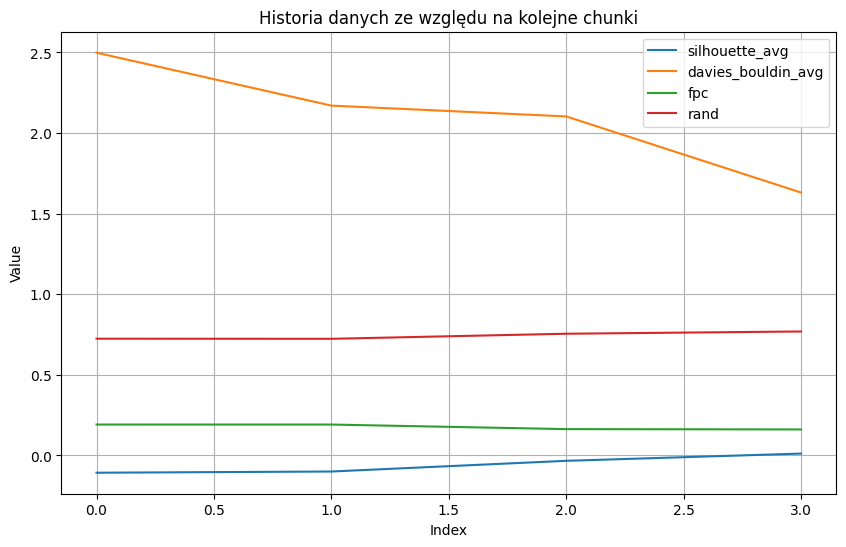

Historia statystyk ze względu na kolejne chunki


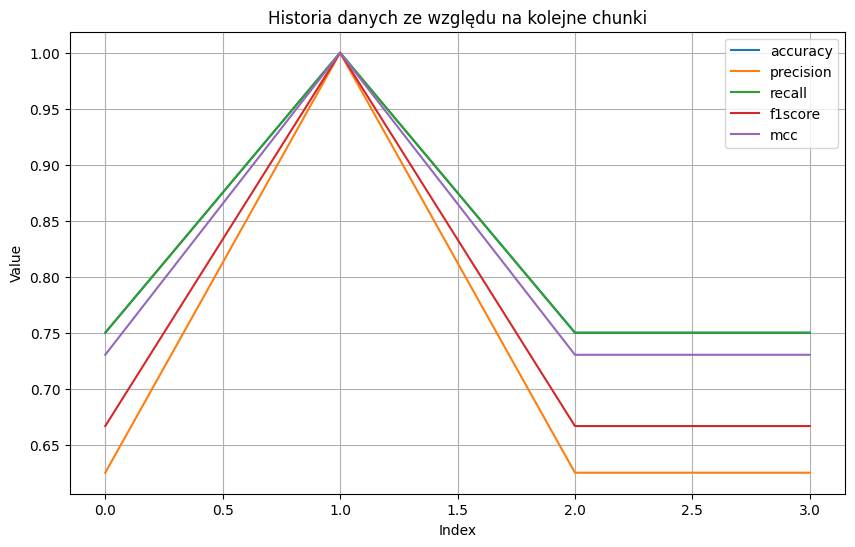

Historia danych wewnatrz iteracji dla pierwszego chunka


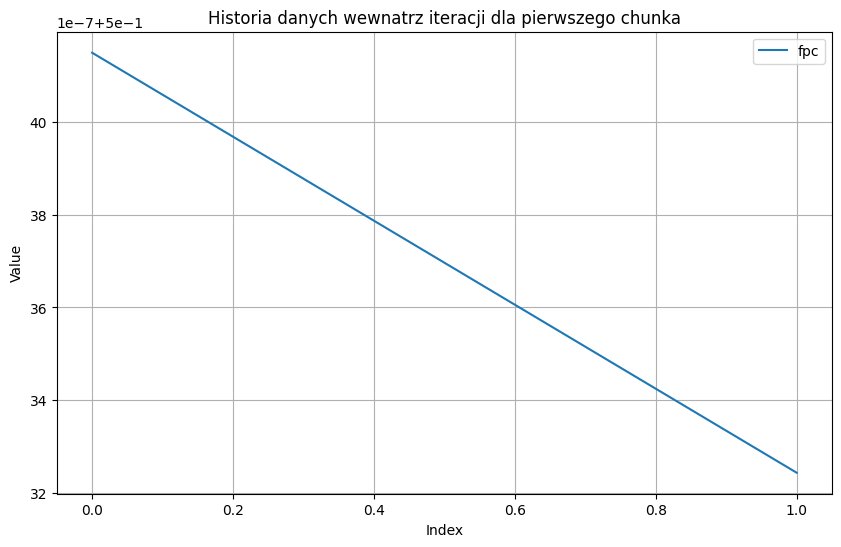

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


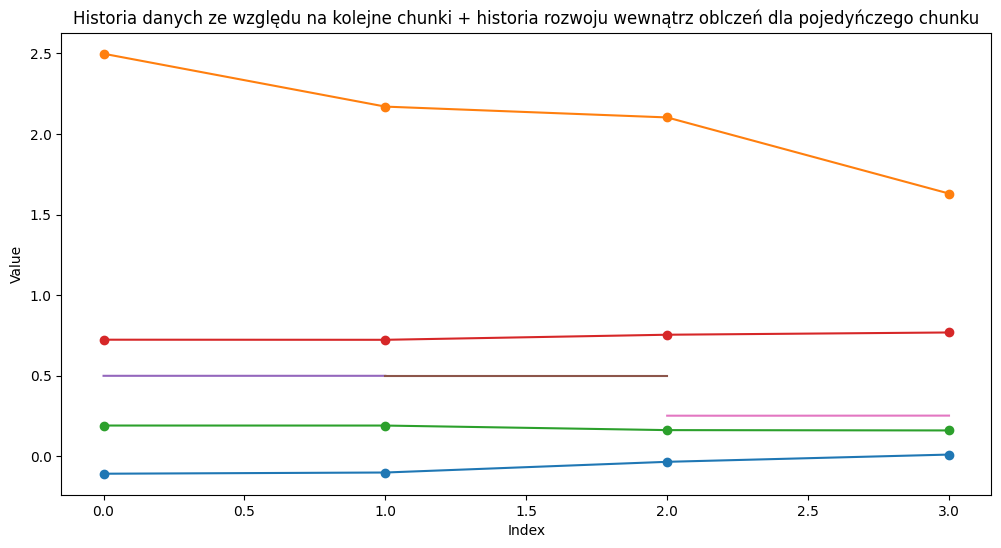

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


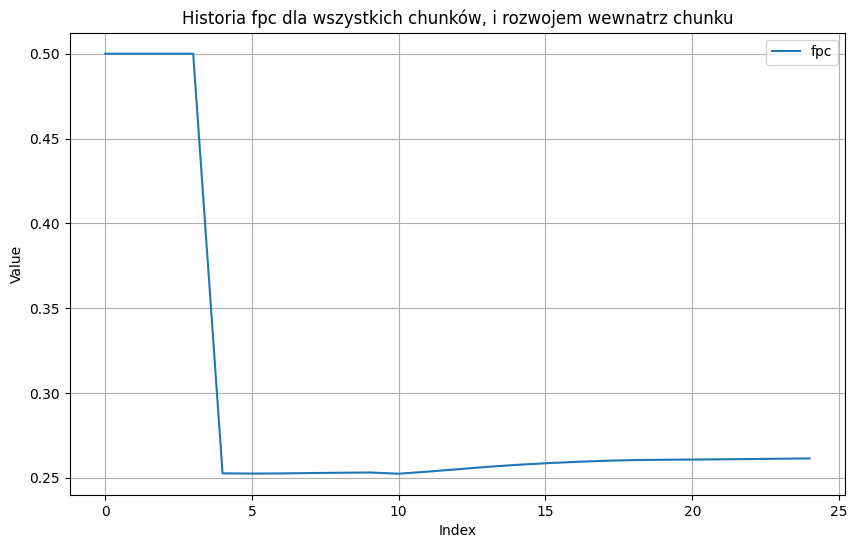

Historia centroidów ze względu na chunki


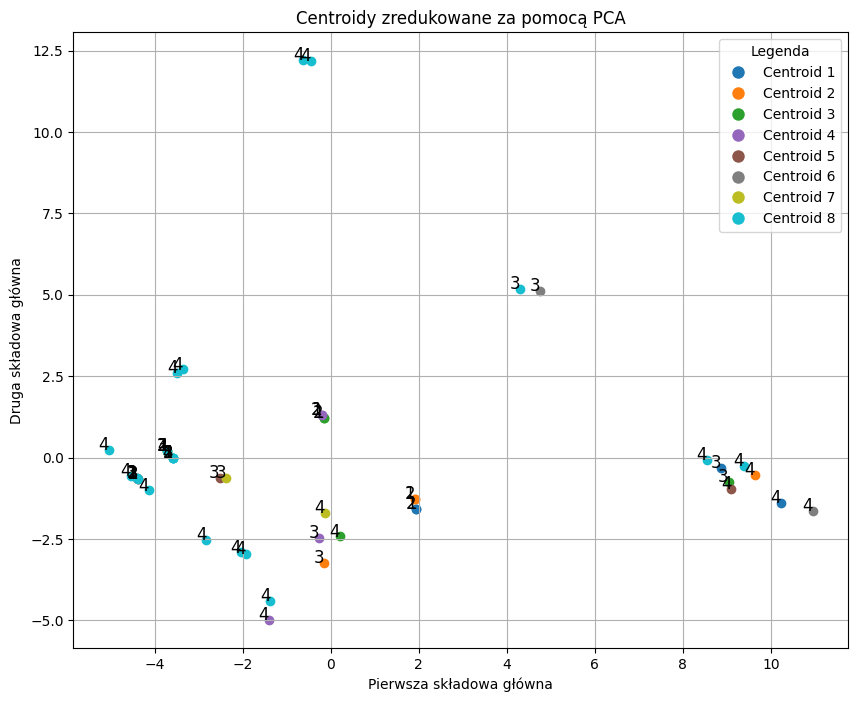

fpc last 0.16110939799688412
rand last 0.7688679245283019


In [57]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie DISSFCM

8


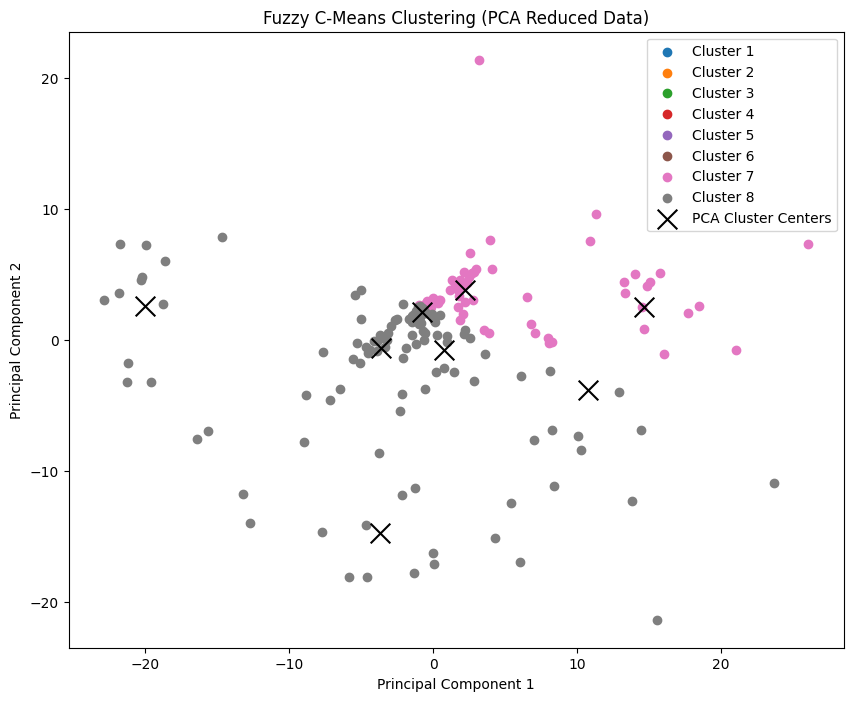

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.23853103028504669
Davies-Bouldin Score: 1.3075101631920654
Rand Score: 0.7465408805031446
Tested fpc: 0.4413936864233027
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  0
Liczba klastrów:  8


Processing:  25%|█████████▊                             | 1/4 [00:00<?, ?it/s]


8


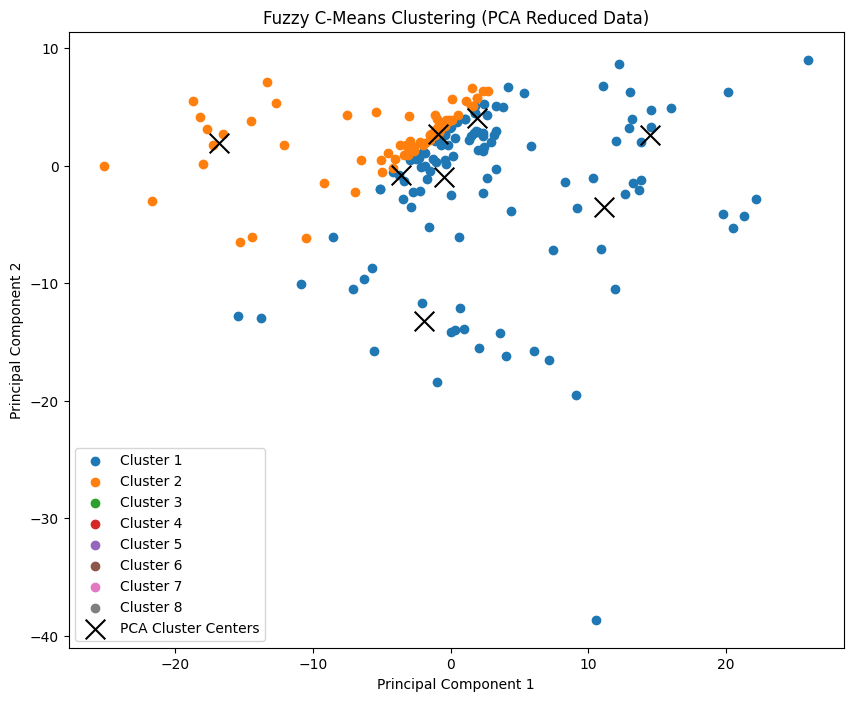

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.08799574017127396
Davies-Bouldin Score: 1.5961694126164268
Rand Score: 0.7647798742138365
Tested fpc: 0.27372183767769737
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  10


Processing:  50%|███████████████████▌                   | 2/4 [00:00<?, ?it/s]


10


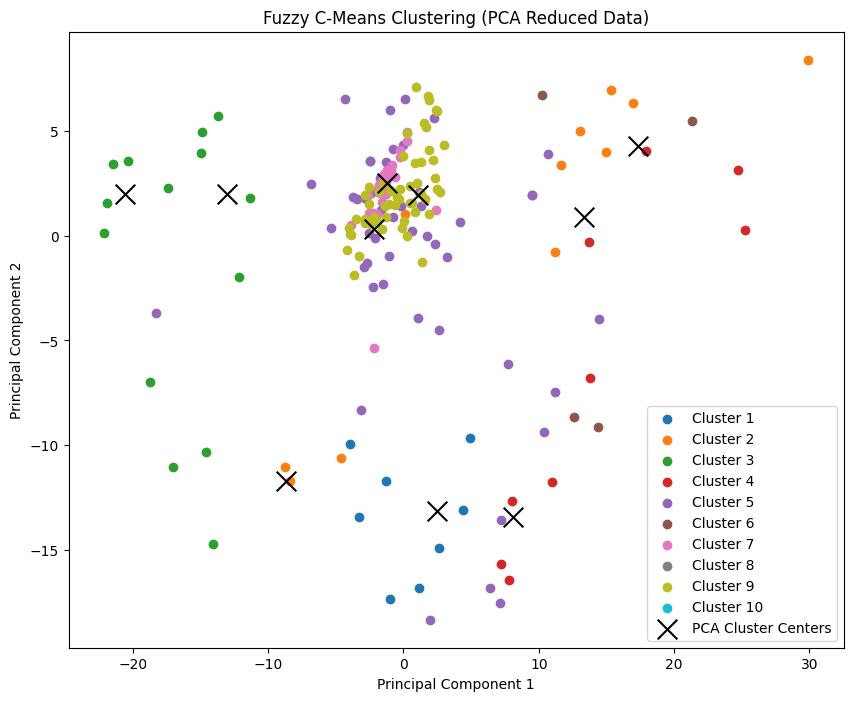

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.21689329122323647
Davies-Bouldin Score: 1.6769422208163278
Rand Score: 0.7595911949685534
Tested fpc: 0.3489493149534325
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  11


Processing:  75%|█████████████████████████████▎         | 3/4 [00:00<?, ?it/s]


11


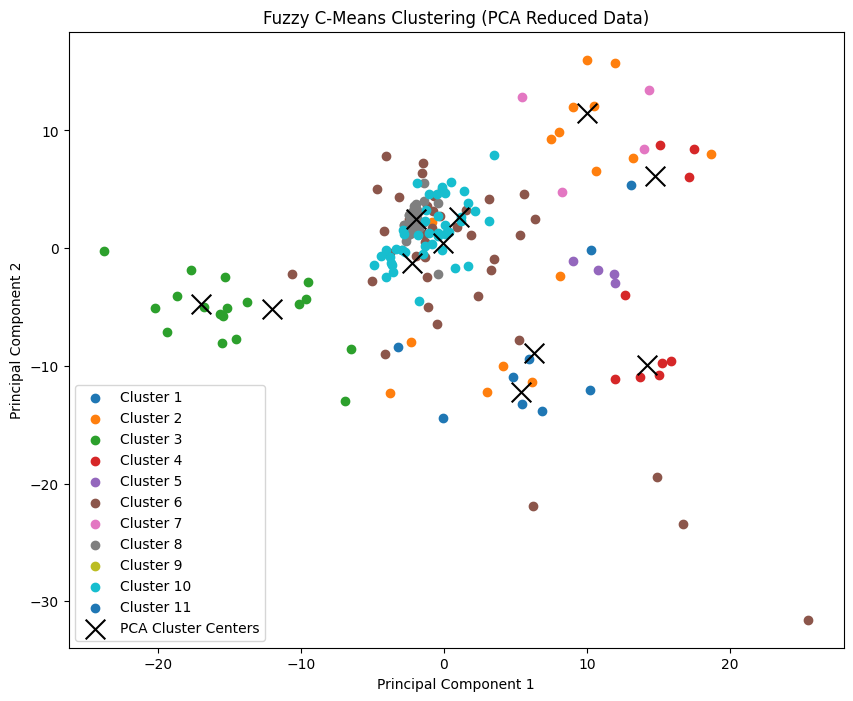

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.22741256463933665
Davies-Bouldin Score: 1.4964244654387455
Rand Score: 0.722562893081761
Tested fpc: 0.3888753811525788
Accuracy: 0.5
Precision:  0.3333333333333333
Recall:  0.5
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  11


Processing: 100%|███████████████████████████████████████| 4/4 [00:00<?, ?it/s]


11


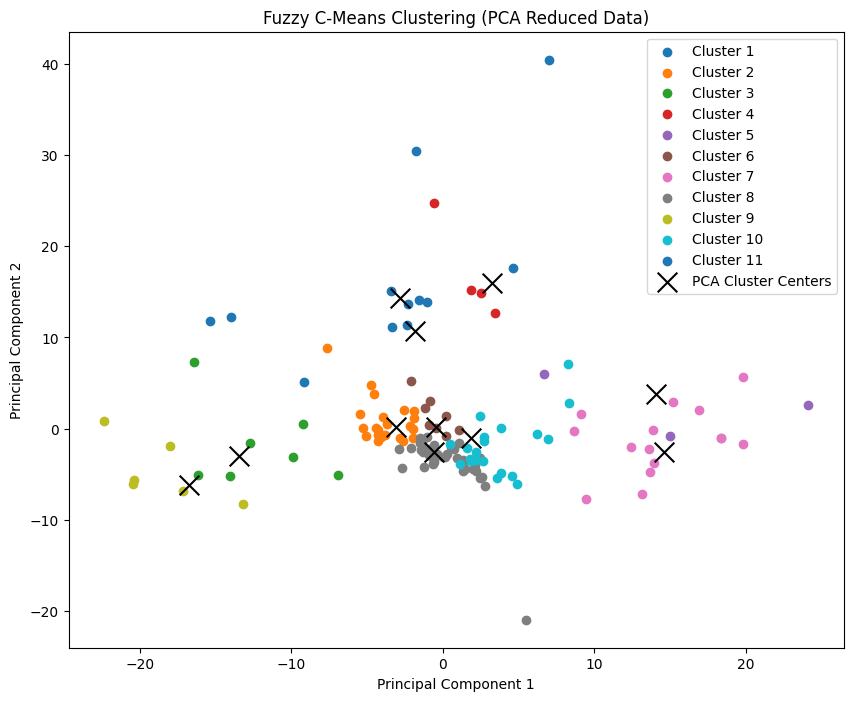

Cluster 0: counts = 3, summed_labels = 6.1606506257050695, fcm per point 2.0535502085683564 
Cluster 1: counts = 23, summed_labels = 22.422927159878576, fcm per point 0.9749098765164598 
Cluster 2: counts = 7, summed_labels = 7.614323463176442, fcm per point 1.0877604947394917 
Cluster 3: counts = 4, summed_labels = 4.917041087707283, fcm per point 1.2292602719268209 
Cluster 4: counts = 3, summed_labels = 4.916427769158092, fcm per point 1.6388092563860308 
Cluster 5: counts = 8, summed_labels = 19.191196687630686, fcm per point 2.398899585953836 
Cluster 6: counts = 15, summed_labels = 10.33862661209567, fcm per point 0.6892417741397113 
Cluster 7: counts = 62, summed_labels = 52.01579668412334, fcm per point 0.8389644626471506 
Cluster 8: counts = 6, summed_labels = 6.093809613207274, fcm per point 1.0156349355345455 
Cluster 9: counts = 20, summed_labels = 19.72838884787588, fcm per point 0.986419442393794 
Cluster 10: counts = 9, summed_labels = 6.60081144944167, fcm per point 0.7

In [58]:
diagnosis_chunk, diagnosis_iterations = dynamic_train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks_shuffled, chunks_y_shuffled, chunks_y_matrix_shuffled, chunks_test, chunks_test_y, clusters_for_each_class_shuffled.copy(), injection, m=m, visualise_data=True, init_centroids=init_centroids_shuffled.copy())

Historia danych ze względu na kolejne chunki


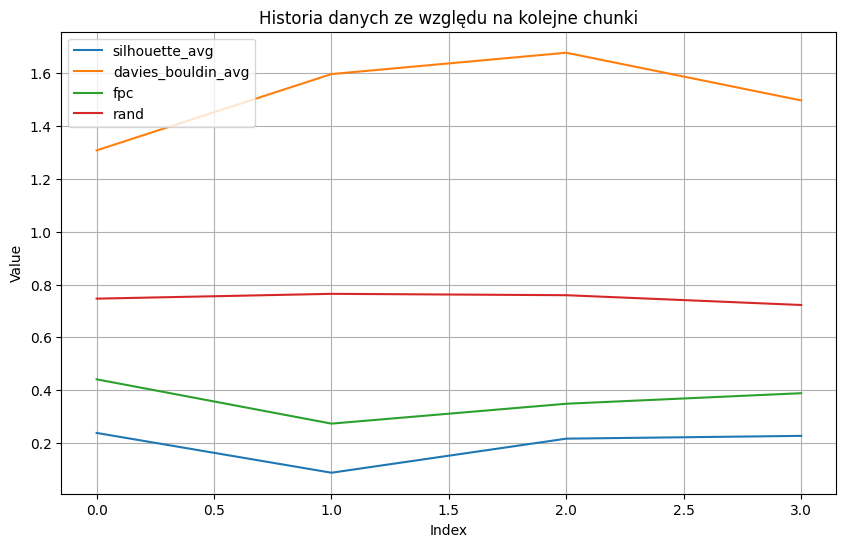

Historia statystyk ze względu na kolejne chunki


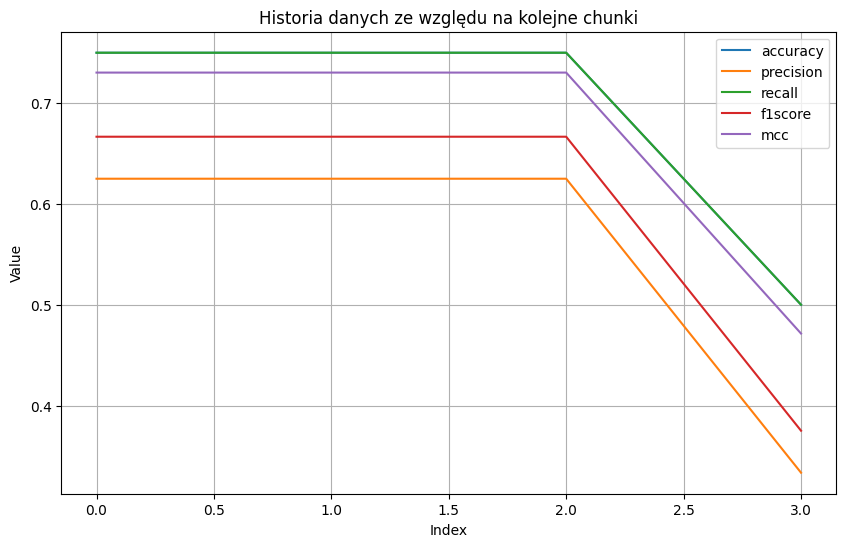

Historia danych wewnatrz iteracji dla pierwszego chunka


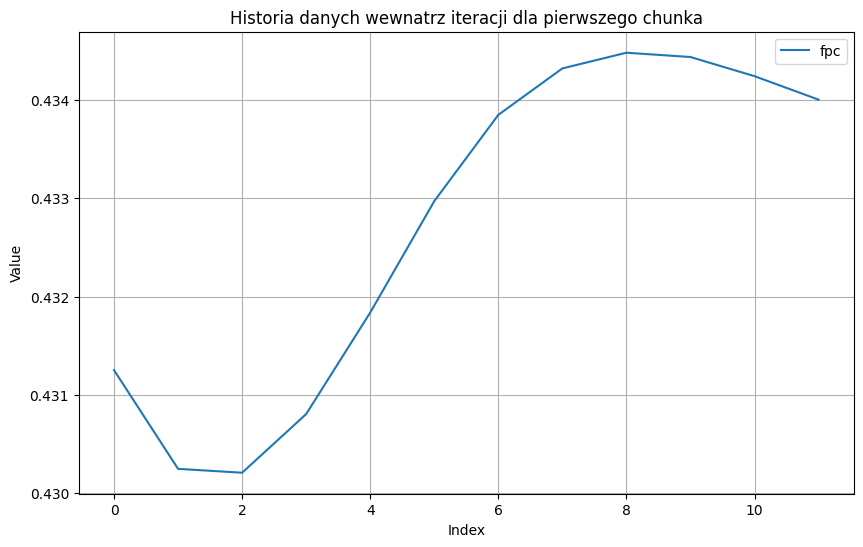

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


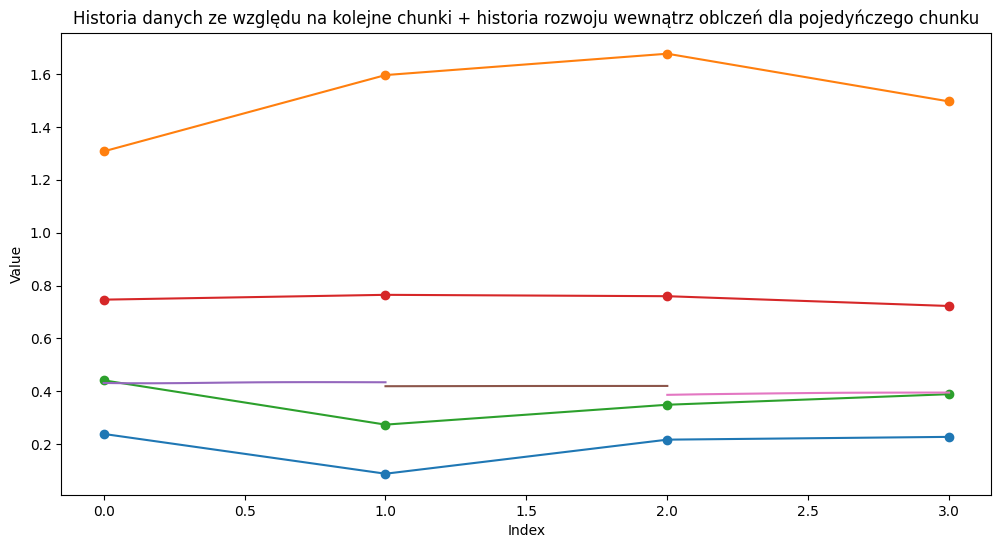

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


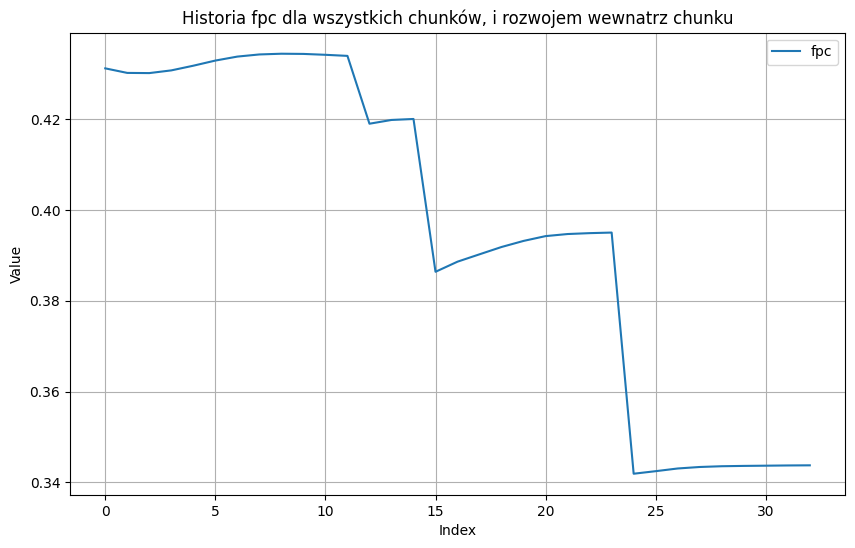

Historia centroidów ze względu na chunki


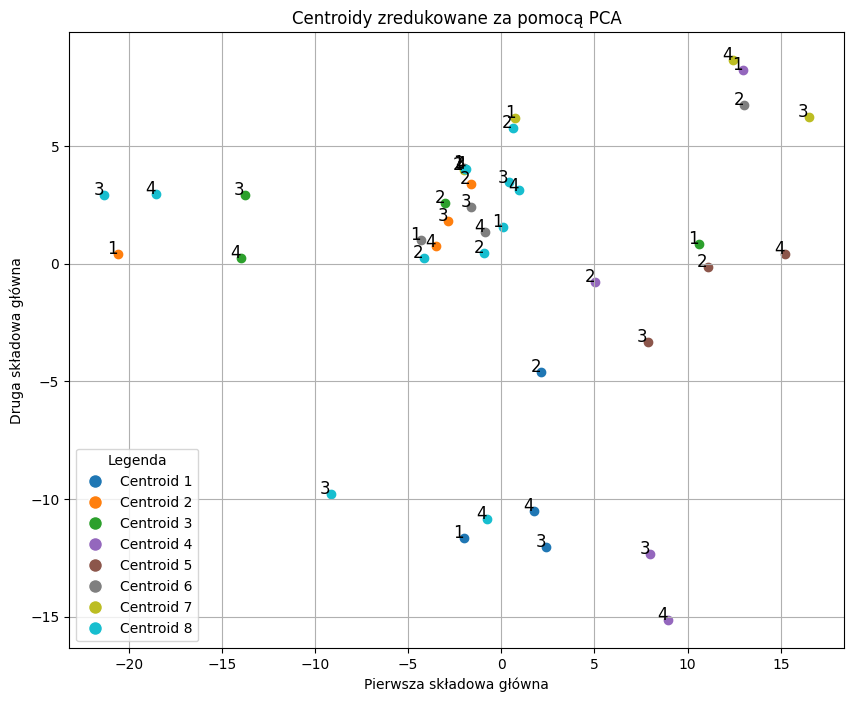

fpc last 0.3888753811525788
rand last 0.722562893081761


In [59]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

# Testowanie algorytmu IFCM

### Implementacja algorytmów

In [60]:
from tqdm import tqdm
from IPython.display import clear_output
import time
import sys
import statistics
from libraries.IFCM import incremental_fuzzy_cmeans
from libraries.IFCM import train_incremental_local_fuzzy_cmeans
from libraries.IFCM import train_incremental_fuzzy_cmeans
from libraries.IFCM import train_incremental_fuzzy_cmeans_extending_data
from libraries.IFCM import train_incremental_fuzzy_cmeans_extending_window_data

### Trenowanie przy pomocy iterowani się po chunkach, dodatkowo w danej iteracji liczone są tylko clustry z klasy danych ćwiczonych

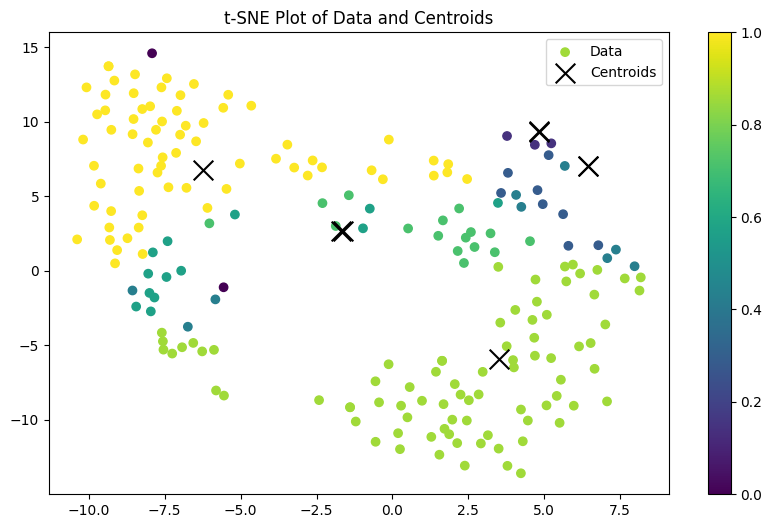

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.12134852424825608
Davies-Bouldin Score: 2.406397871187056
Rand Score: 0.7129716981132076
Tested fpc: 0.23830308313589751
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  0
Liczba klastrów:  8


Processing:  25%|█████████▊                             | 1/4 [00:00<?, ?it/s]


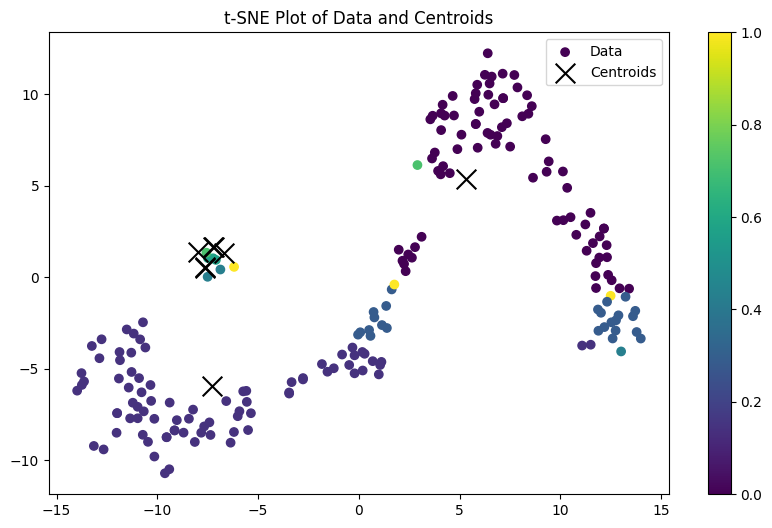

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.0014113732811498324
Davies-Bouldin Score: 1.8161964076406525
Rand Score: 0.7558962264150944
Tested fpc: 0.26427316757533587
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  8


Processing:  50%|███████████████████▌                   | 2/4 [00:00<?, ?it/s]


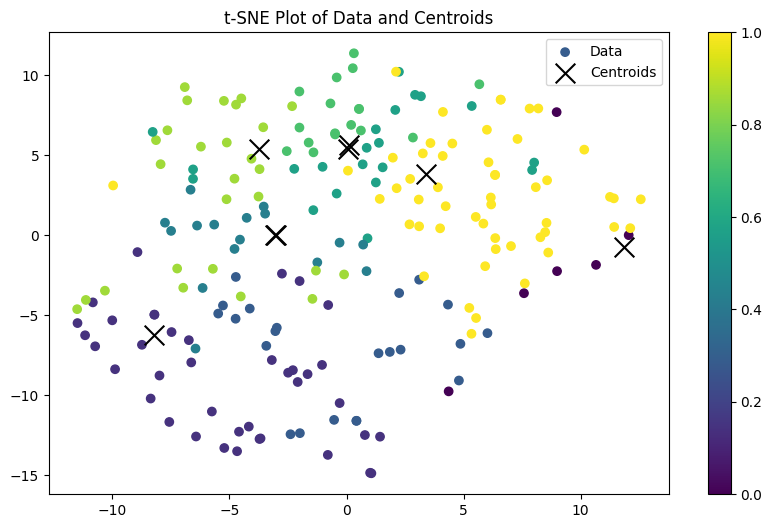

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.0003494685188826591
Davies-Bouldin Score: 1.8325618751299715
Rand Score: 0.7555817610062893
Tested fpc: 0.26408465185624097
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  8


Processing:  75%|█████████████████████████████▎         | 3/4 [00:00<?, ?it/s]


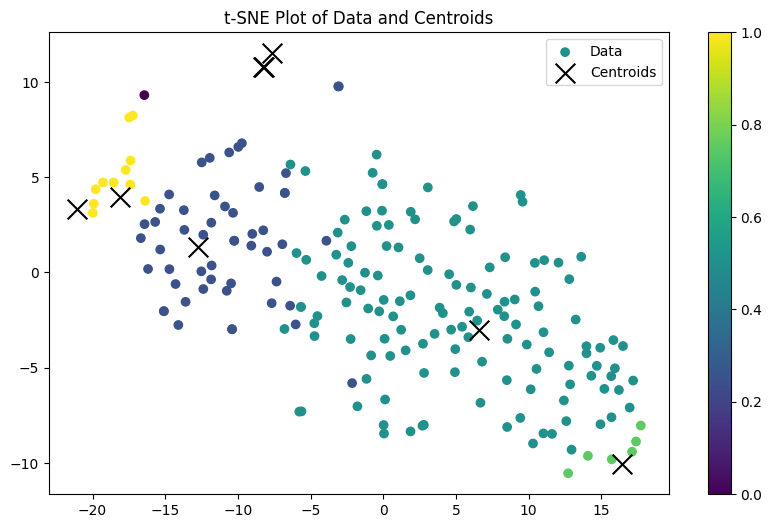

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.034657976881780336
Davies-Bouldin Score: 1.6340597660422898
Rand Score: 0.7570754716981132
Tested fpc: 0.2969102726563417
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  8


Processing: 100%|███████████████████████████████████████| 4/4 [00:00<?, ?it/s]


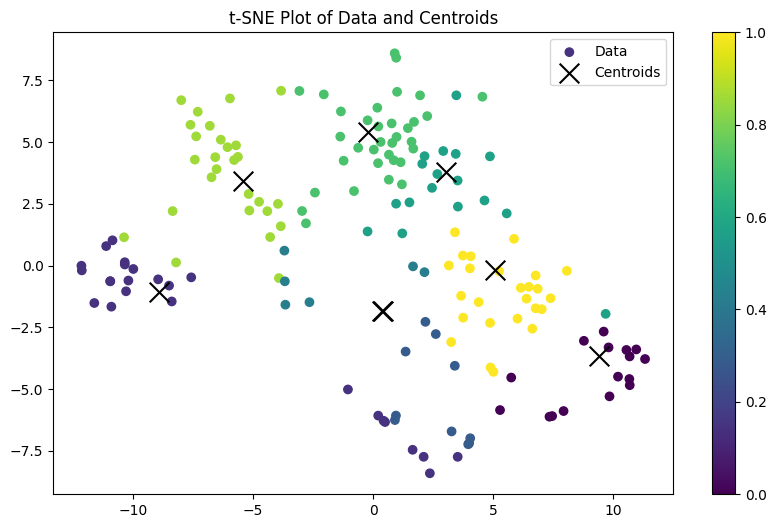

Cluster 0: counts = 16, summed_labels = 9.833372077038801, fcm per point 0.6145857548149251 
Cluster 1: counts = 25, summed_labels = 10.042601449363437, fcm per point 0.40170405797453745 
Cluster 2: counts = 10, summed_labels = 14.42245116268437, fcm per point 1.4422451162684369 
Cluster 3: counts = 6, summed_labels = 14.359999312036148, fcm per point 2.393333218672691 
Cluster 4: counts = 17, summed_labels = 30.05596427816866, fcm per point 1.7679978987158034 
Cluster 5: counts = 34, summed_labels = 37.35345879506766, fcm per point 1.0986311410314018 
Cluster 6: counts = 27, summed_labels = 21.696164180031857, fcm per point 0.8035616362974762 
Cluster 7: counts = 25, summed_labels = 22.235988745609088, fcm per point 0.8894395498243636 
Czas wykonania: 5.025973796844482 sekund


In [61]:
diagnosis_chunk, diagnosis_iterations = train_incremental_local_fuzzy_cmeans(n_clusters, chunks, chunks_y, chunks_test, chunks_test_y, visualise_data=True, plot_func=plot_tsne, clusters_for_each_class=clusters_for_each_class.copy(), init_centroids=init_centroids.copy())

Historia danych ze względu na kolejne chunki


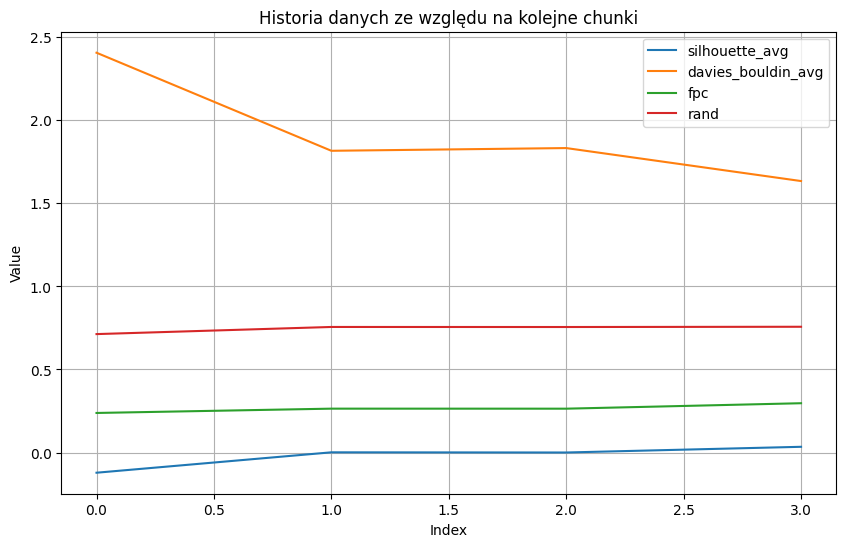

Historia statystyk ze względu na kolejne chunki


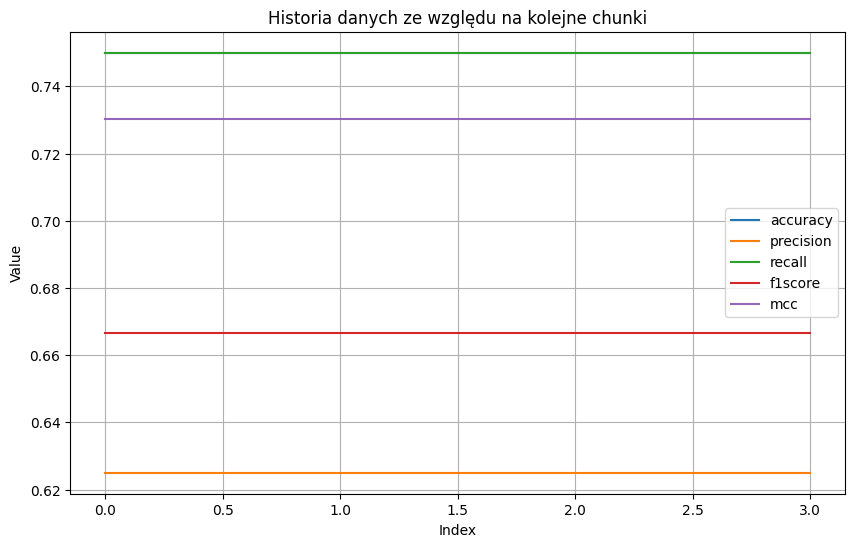

Historia danych wewnatrz iteracji dla pierwszego chunka


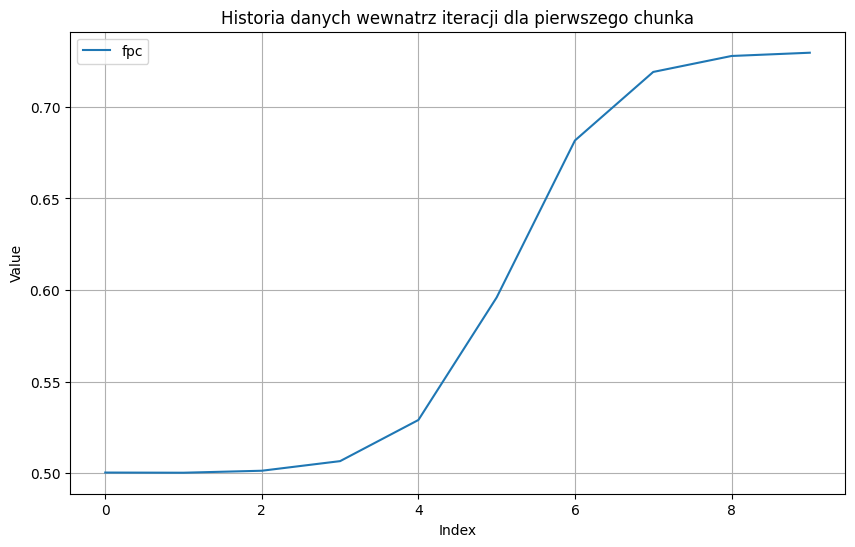

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


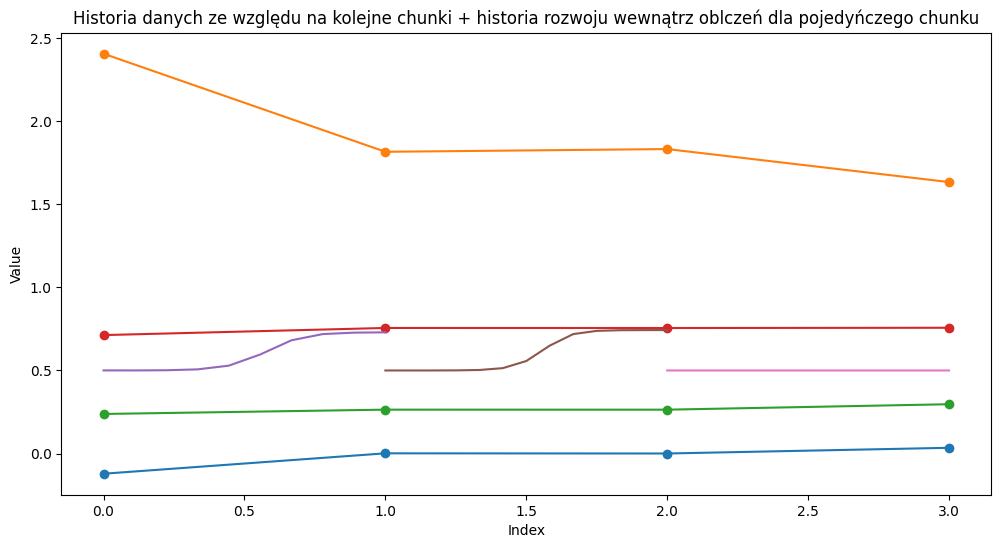

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


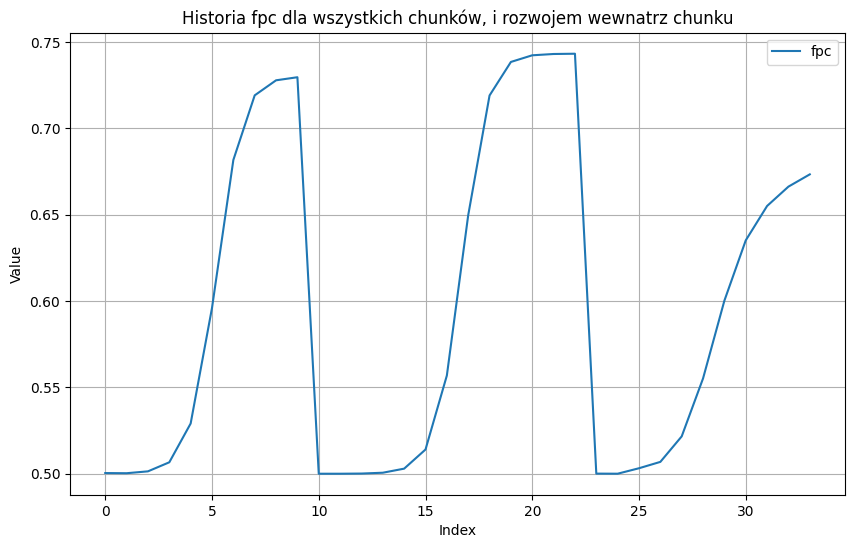

Historia centroidów ze względu na chunki


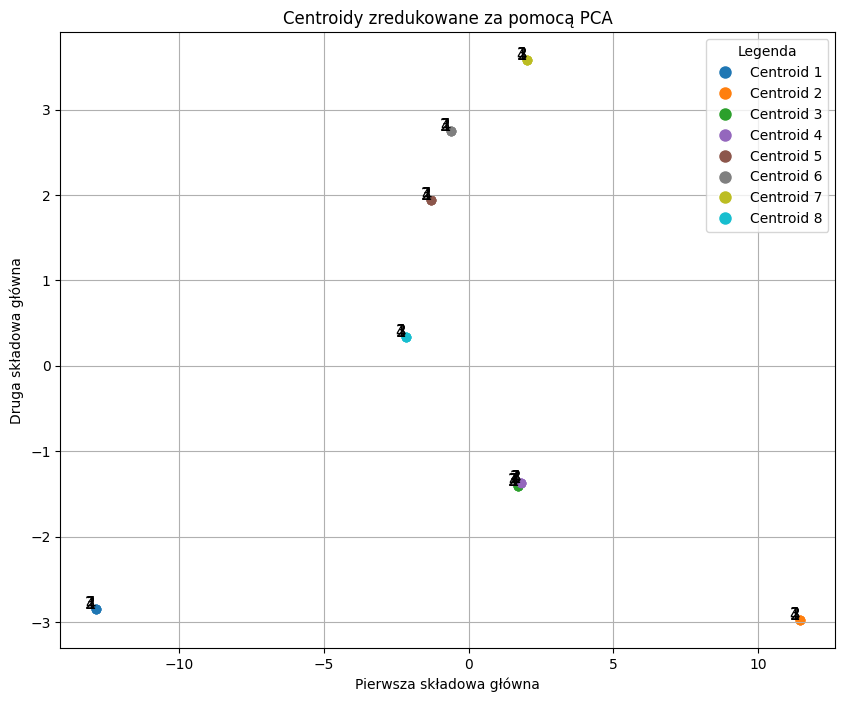

fpc last 0.2969102726563417
rand last 0.7570754716981132


In [62]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie przy pomocy iterowania się po chunkach

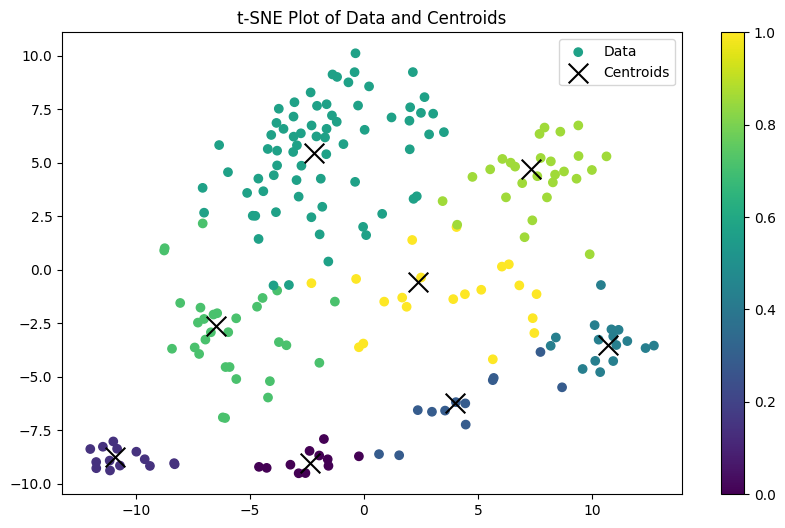

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.26993730667397176
Davies-Bouldin Score: 1.158972474919231
Rand Score: 0.7331761006289308
Tested fpc: 0.4593086437756858
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  0
Liczba klastrów:  8


Processing:  25%|█████████▊                             | 1/4 [00:00<?, ?it/s]


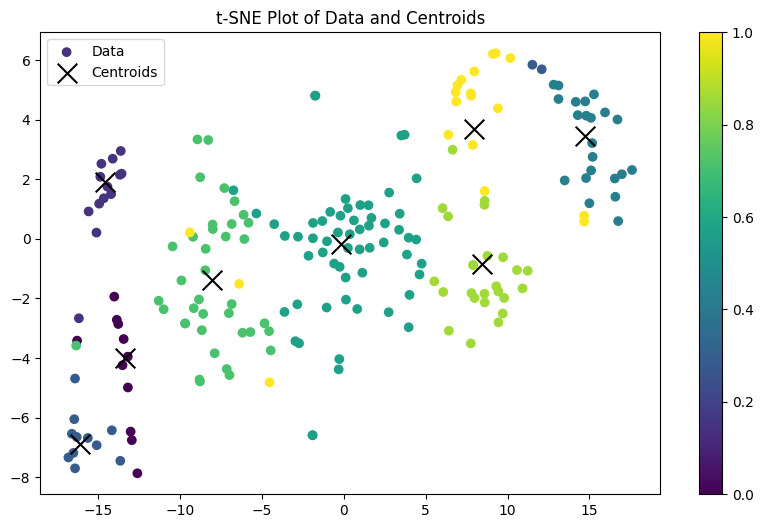

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.2579989402836408
Davies-Bouldin Score: 1.2701616922844279
Rand Score: 0.7435534591194969
Tested fpc: 0.4531986564483554
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  8


Processing:  50%|███████████████████▌                   | 2/4 [00:00<?, ?it/s]


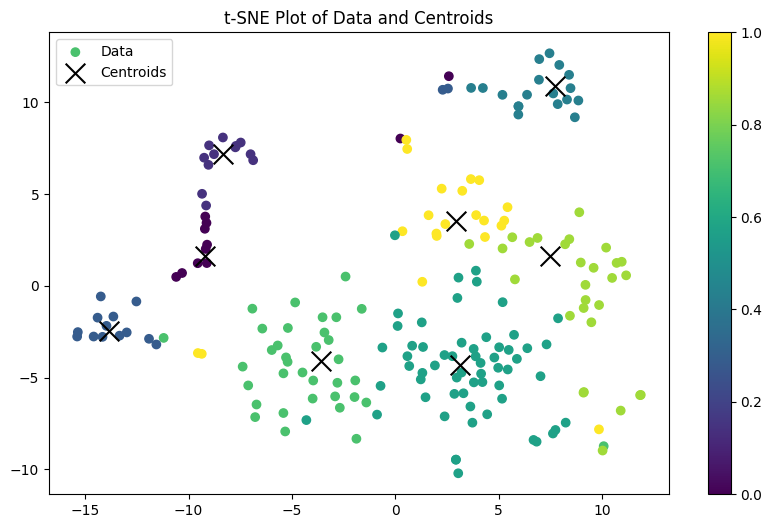

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.22272965357624983
Davies-Bouldin Score: 1.2814138935155728
Rand Score: 0.7513364779874214
Tested fpc: 0.41089929498198696
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  8


Processing:  75%|█████████████████████████████▎         | 3/4 [00:00<?, ?it/s]


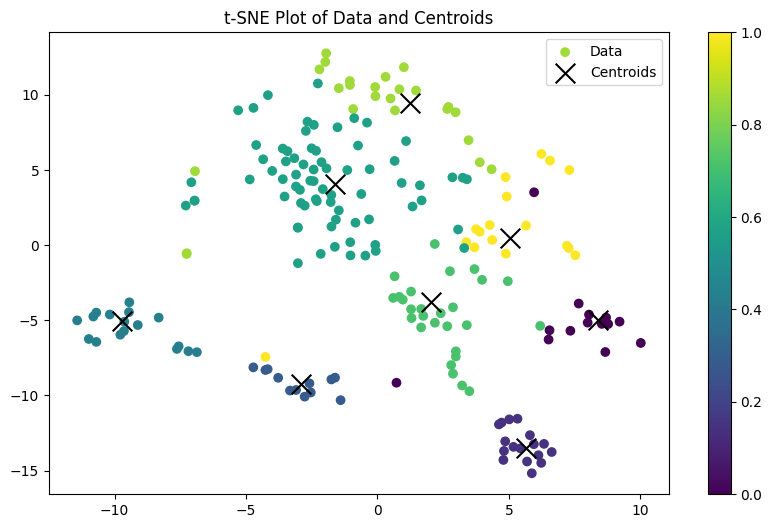

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.25825269498878944
Davies-Bouldin Score: 1.2392438172352318
Rand Score: 0.7538522012578617
Tested fpc: 0.44880419035938035
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  8


Processing: 100%|███████████████████████████████████████| 4/4 [00:00<?, ?it/s]

Czas wykonania: 3.897998571395874 sekund


In [63]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans(n_clusters, chunks_shuffled, chunks_test, chunks_test_y, visualise_data=True, plot_func=plot_tsne, init_centroids=init_centroids_shuffled.copy())

Historia danych ze względu na kolejne chunki


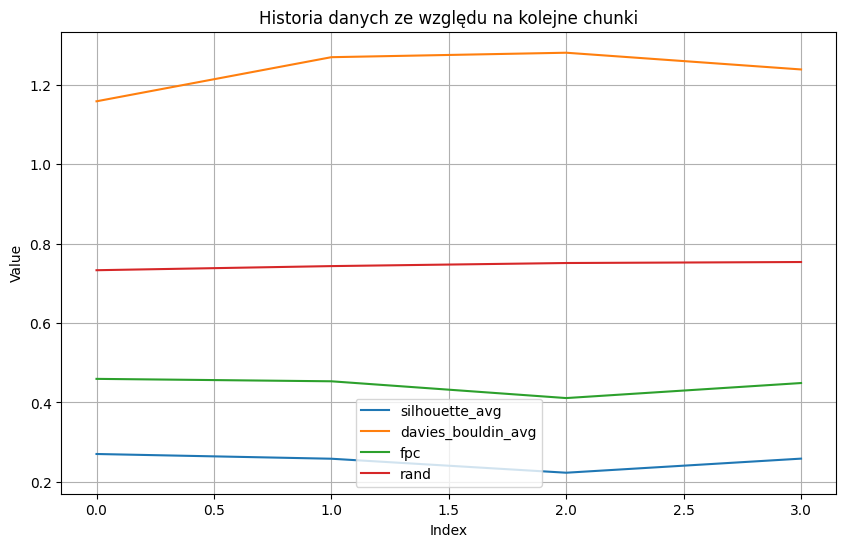

Historia statystyk ze względu na kolejne chunki


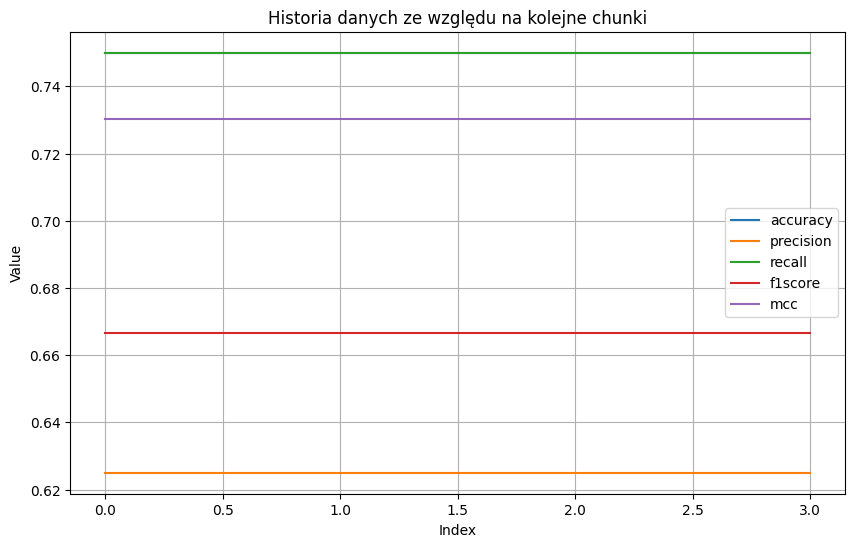

Historia danych wewnatrz iteracji dla pierwszego chunka


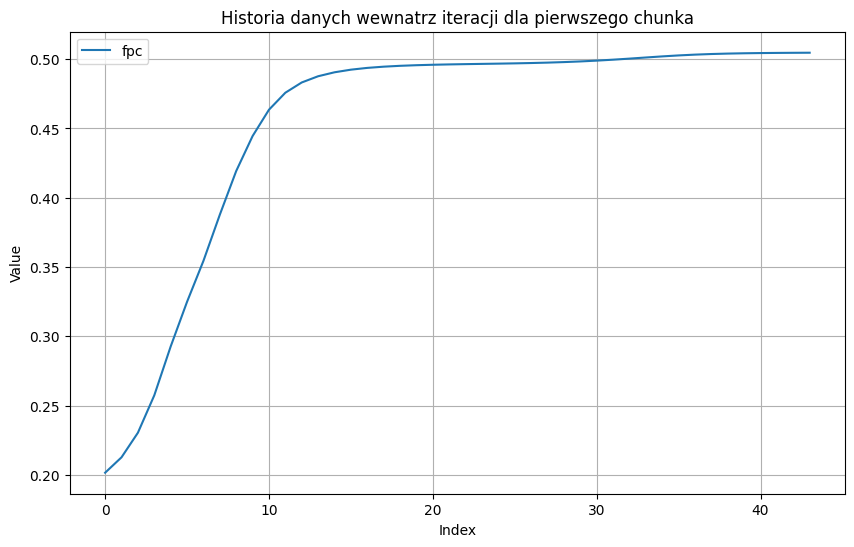

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


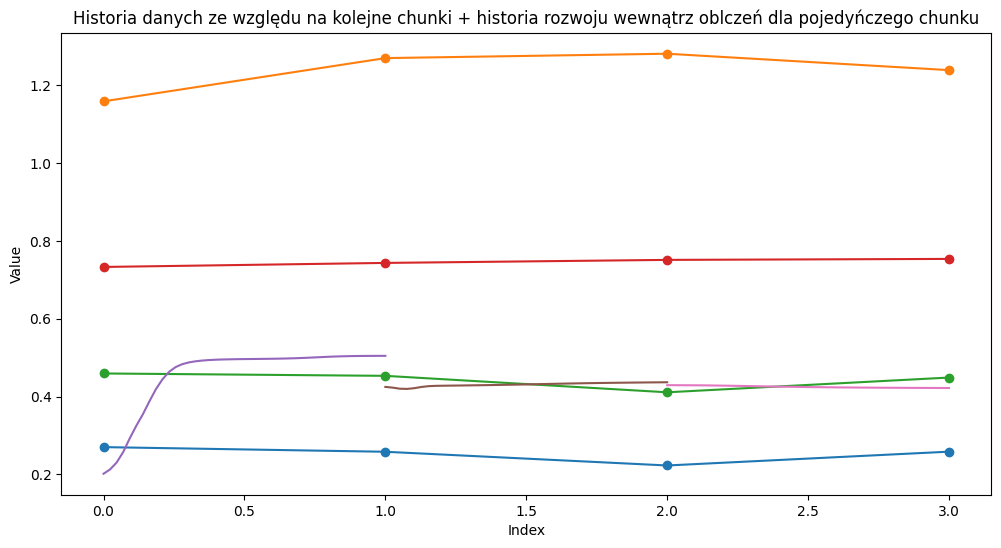

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


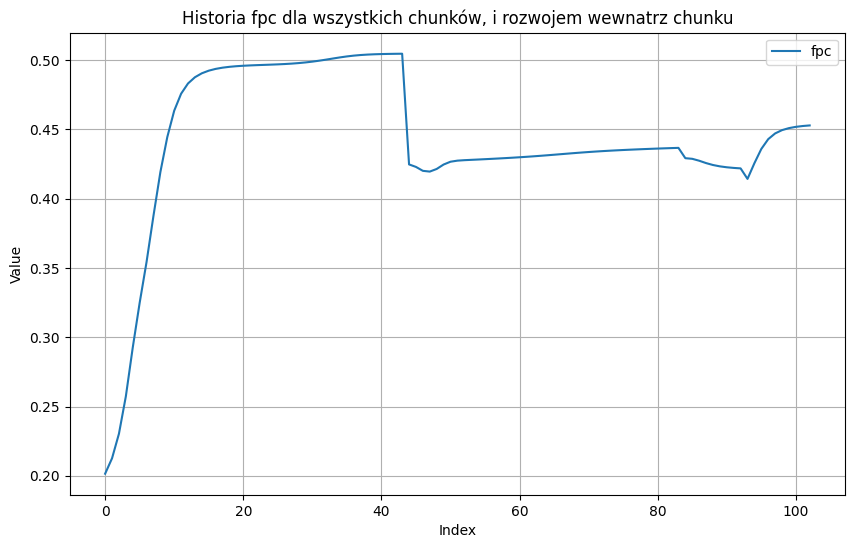

Historia centroidów ze względu na chunki


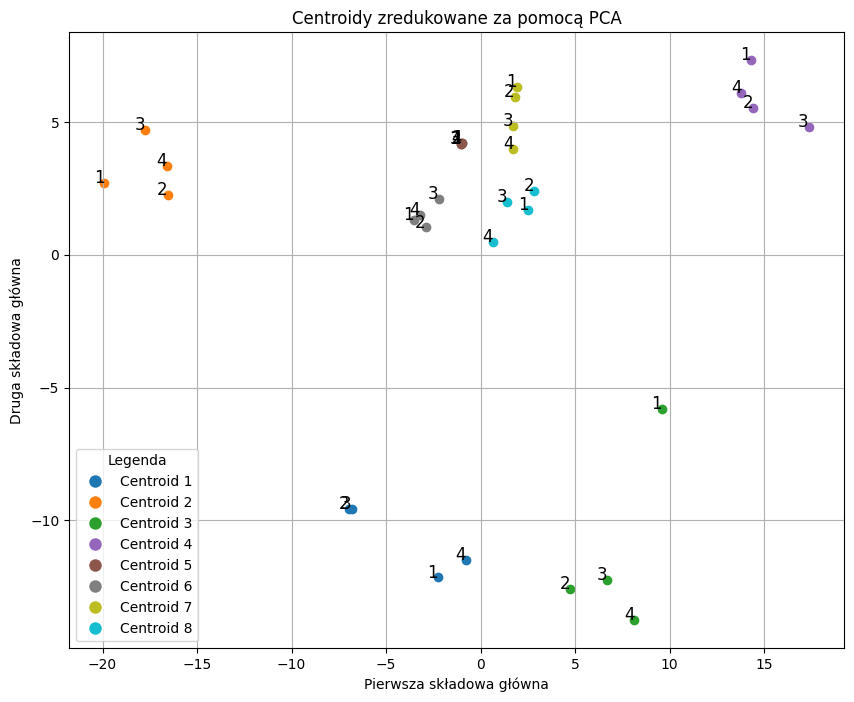

fpc last 0.44880419035938035
rand last 0.7538522012578617


In [64]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie przy pomocy iterowania się po chunkach z rozszerzającymi się danymi

PCA plot
8


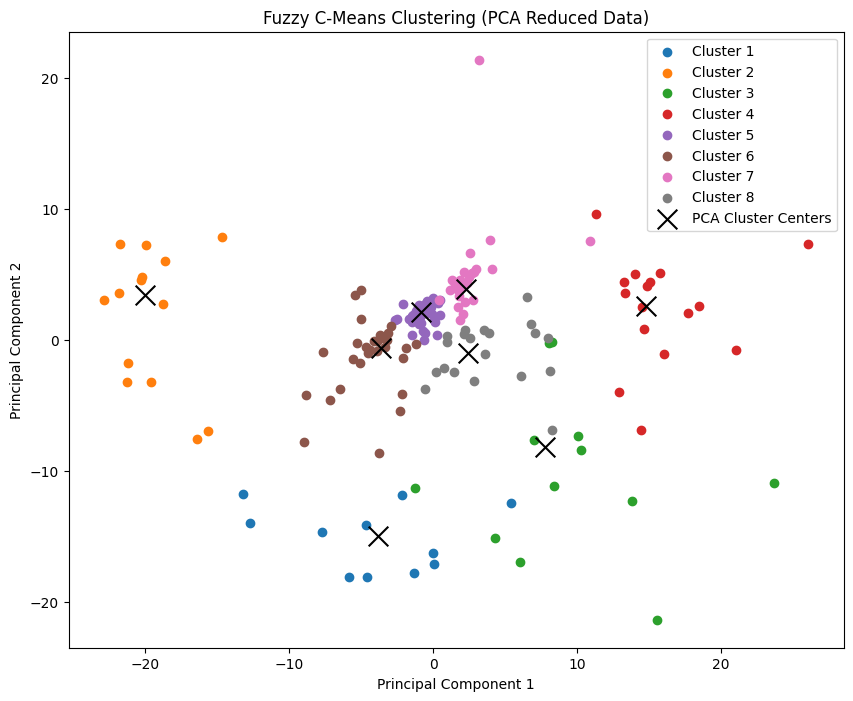

heatmap plot


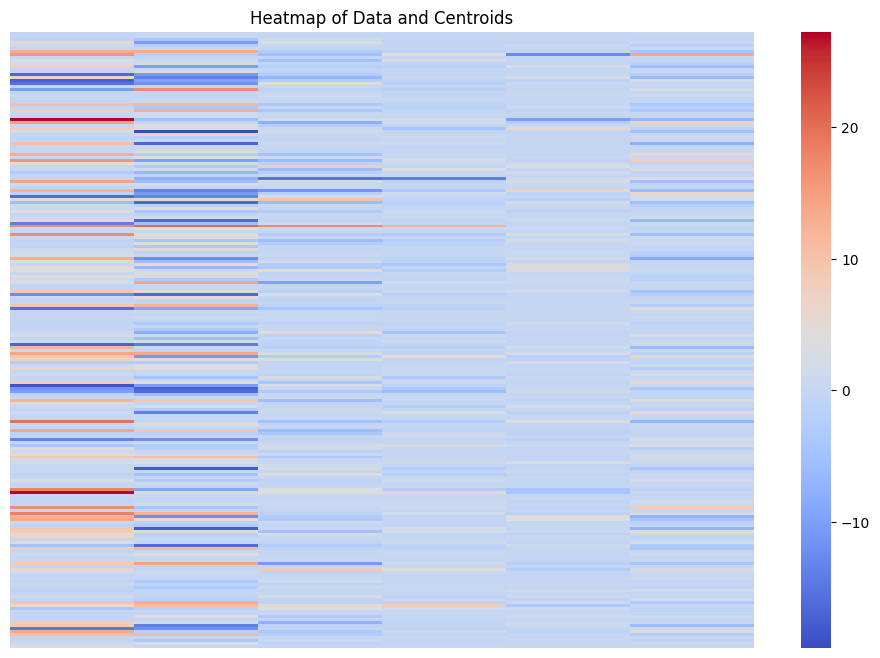

TSNE plot


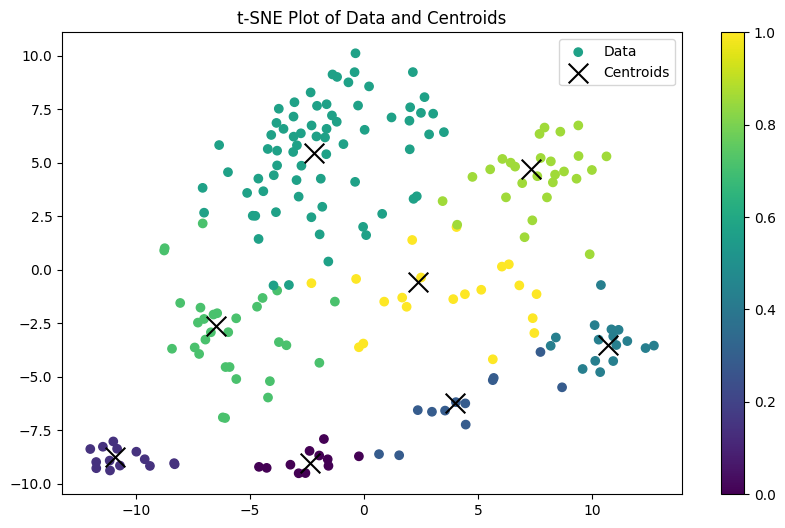

MDS plot


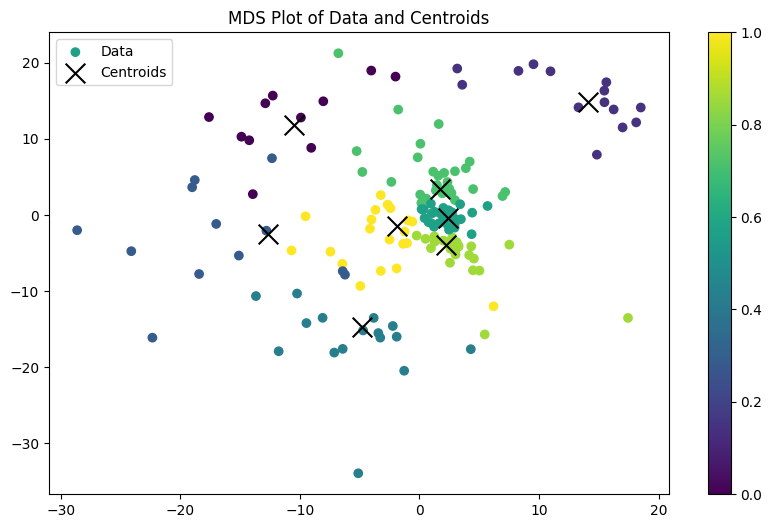

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.26993730667397176
Davies-Bouldin Score: 1.158972474919231
Rand Score: 0.7331761006289308
Tested fpc: 0.4593086437756858
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
8


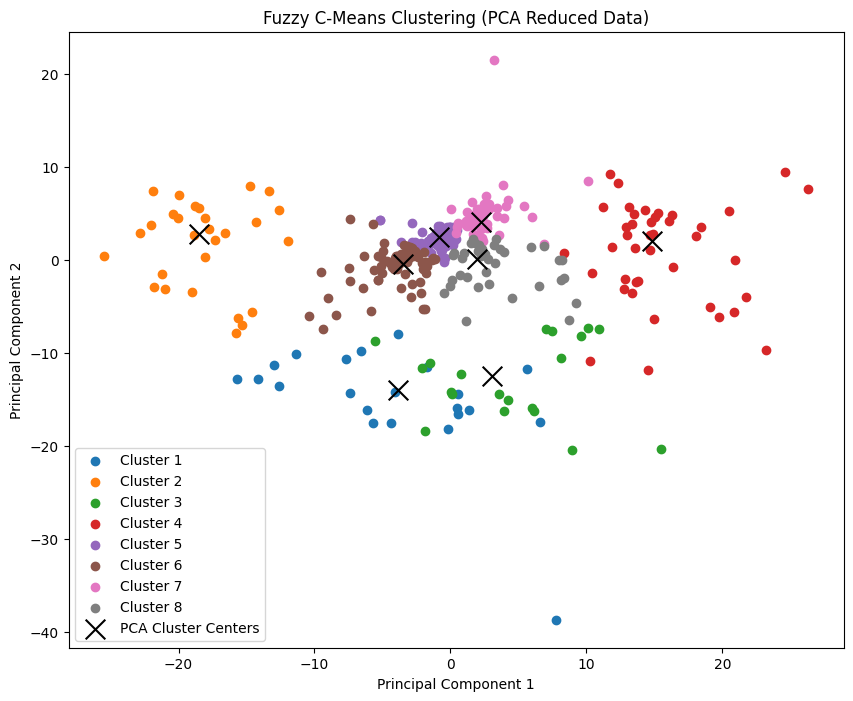

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.2599738625693254
Davies-Bouldin Score: 1.2022180946156693
Rand Score: 0.7413522012578616
Tested fpc: 0.46049739562156145
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  8


Processing:  50%|███████████████████▌                   | 2/4 [00:00<?, ?it/s]


8


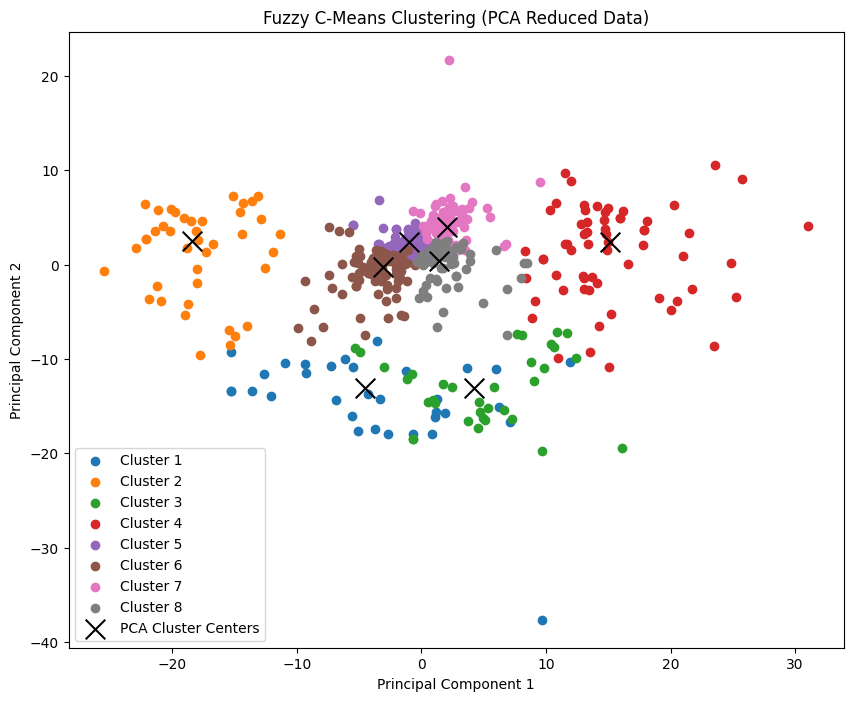

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.2552091241475619
Davies-Bouldin Score: 1.1669644724996668
Rand Score: 0.7503930817610063
Tested fpc: 0.44904692830209536
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  8


Processing:  75%|█████████████████████████████▎         | 3/4 [00:00<?, ?it/s]


8


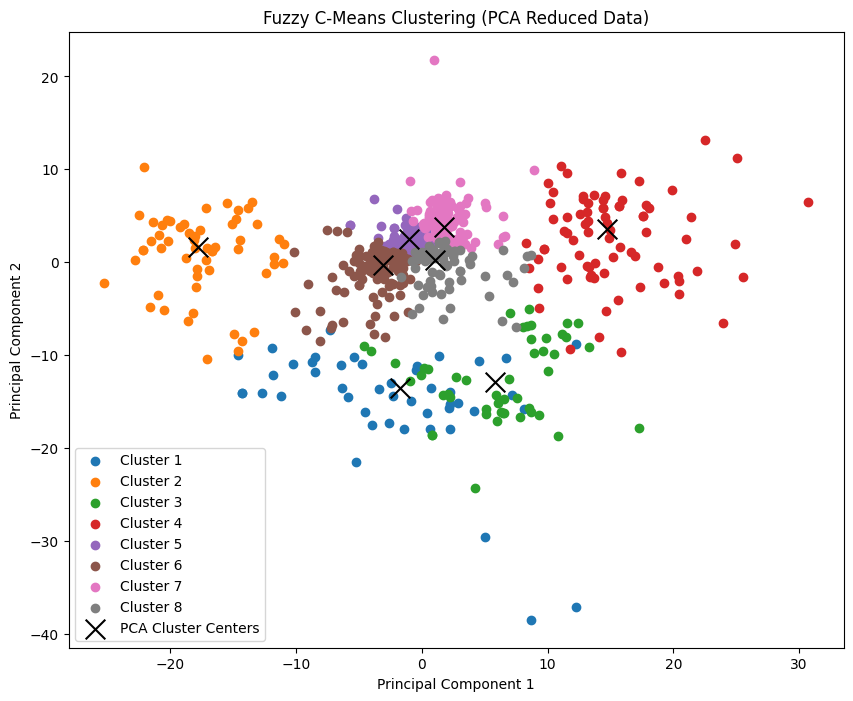

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.2603581502820714
Davies-Bouldin Score: 1.1628952900174228
Rand Score: 0.7467767295597484
Tested fpc: 0.44896269907815656
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  8


Processing: 100%|███████████████████████████████████████| 4/4 [00:00<?, ?it/s]

Czas wykonania: 2.7015910148620605 sekund


In [65]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans_extending_data(n_clusters, chunks_shuffled, chunks_test, chunks_test_y, visualise_data=True, init_centroids=init_centroids_shuffled.copy())

Historia danych ze względu na kolejne chunki


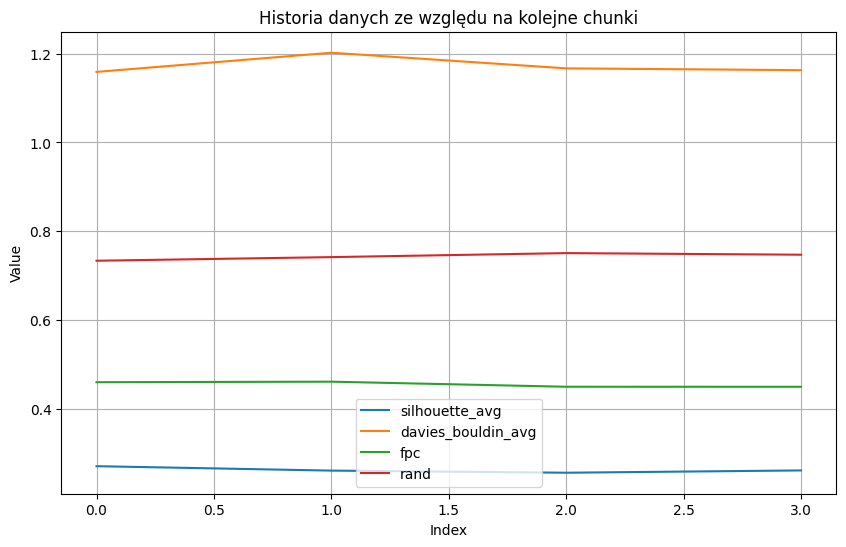

Historia statystyk ze względu na kolejne chunki


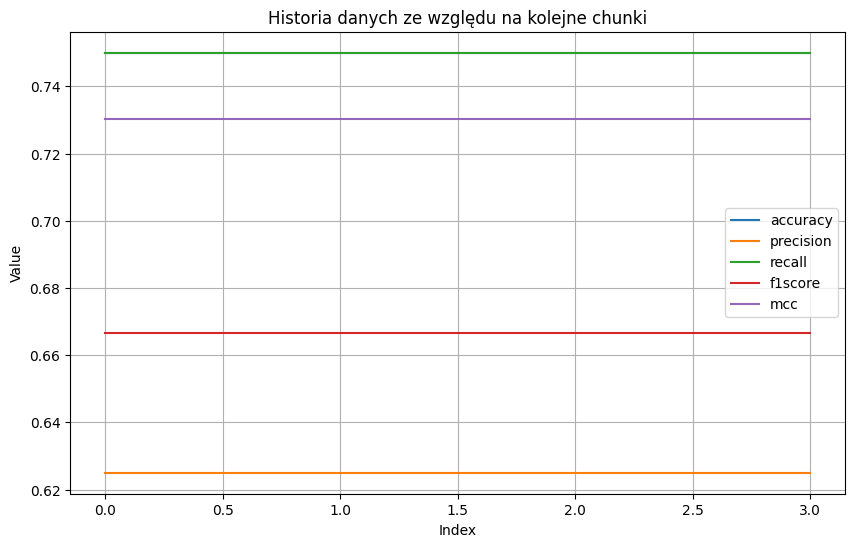

Historia danych wewnatrz iteracji dla pierwszego chunka


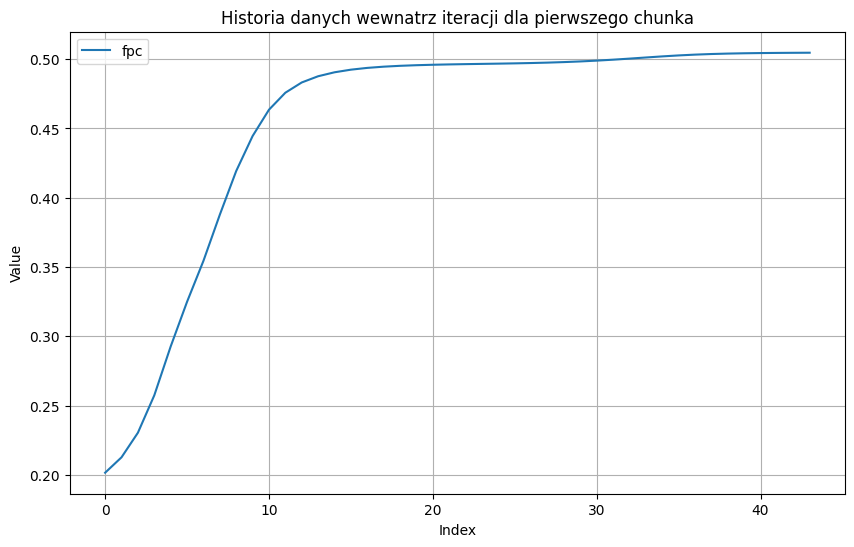

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


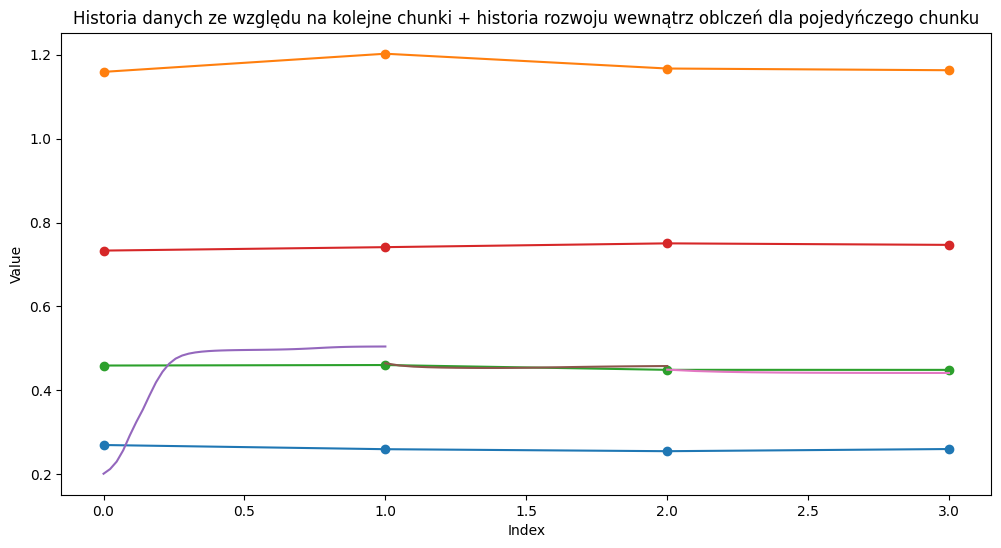

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


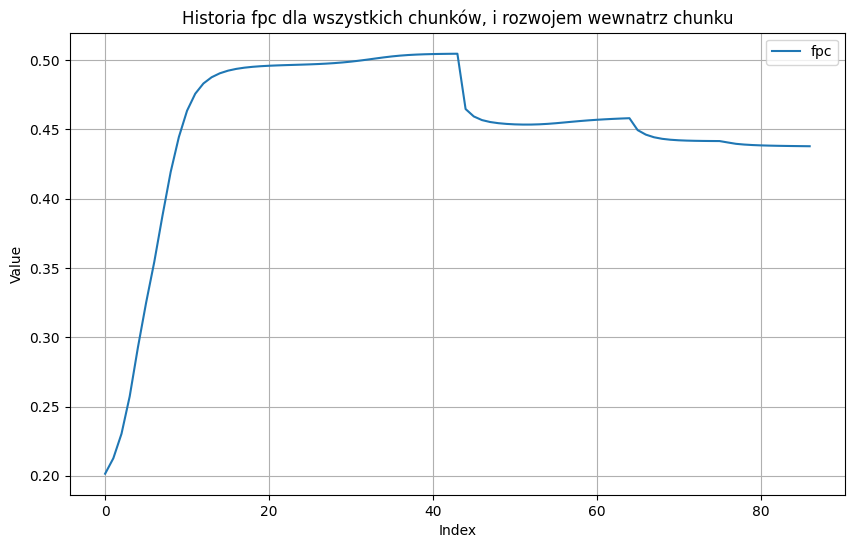

Historia centroidów ze względu na chunki


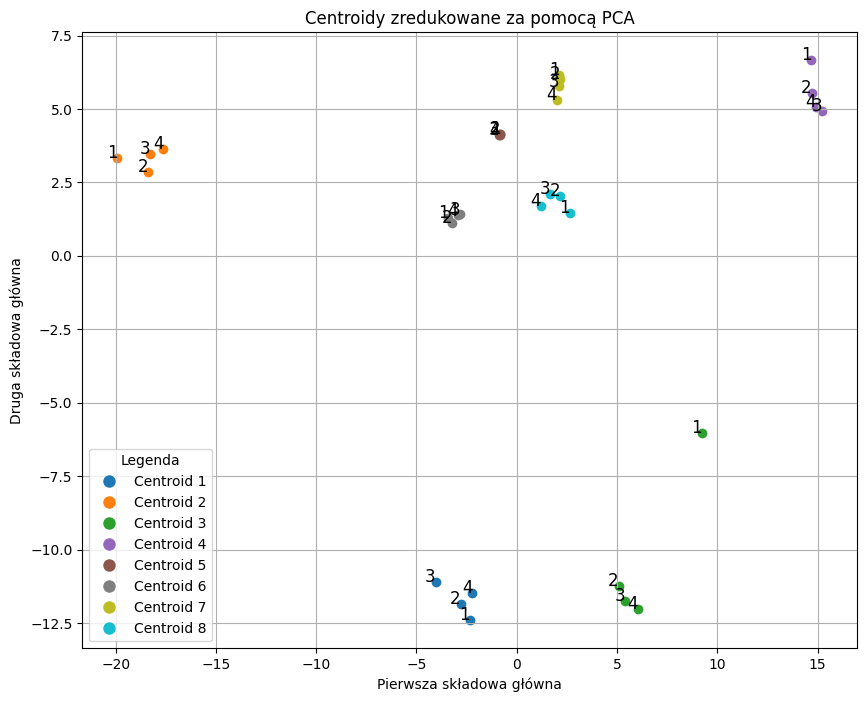

fpc last 0.44896269907815656
rand last 0.7467767295597484


In [66]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie przy pomocy iterowania się po chunkach z rozszerzającymi się danymi, przesuwającym się oknem

In [67]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans_extending_window_data(n_clusters, chunks_shuffled, chunks_test, chunks_test_y, init_centroids=init_centroids_shuffled.copy())

Rozważamy obecnie chunk numer:  3
Liczba klastrów:  8


Processing: 100%|███████████████████████████████████████| 4/4 [00:00<?, ?it/s]

Czas wykonania: 0.12309956550598145 sekund


Historia danych ze względu na kolejne chunki


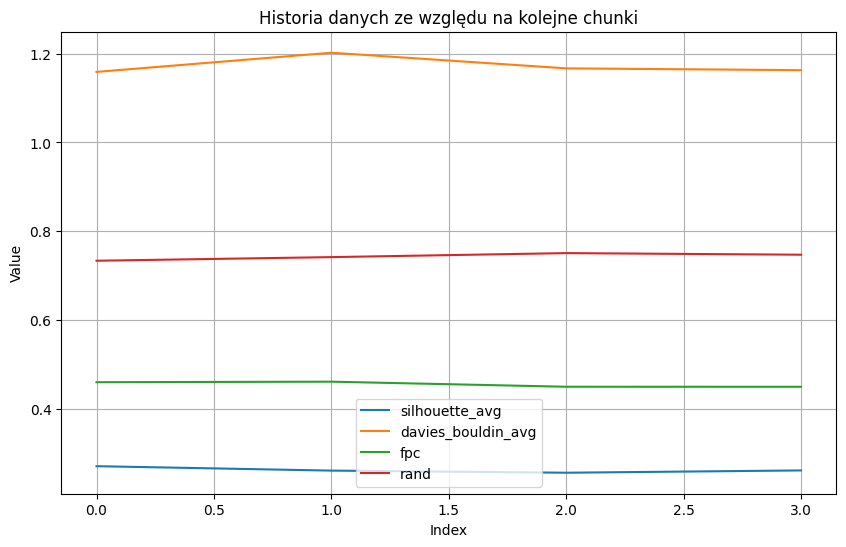

Historia statystyk ze względu na kolejne chunki


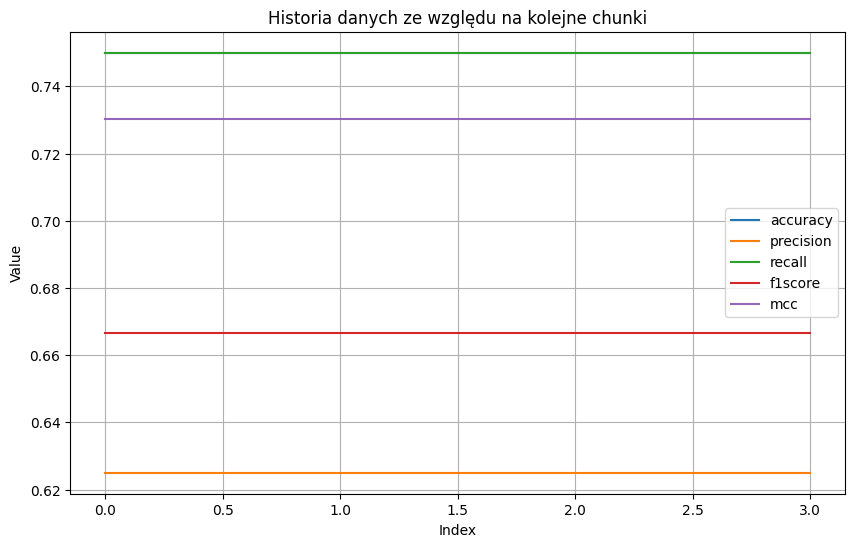

Historia danych wewnatrz iteracji dla pierwszego chunka


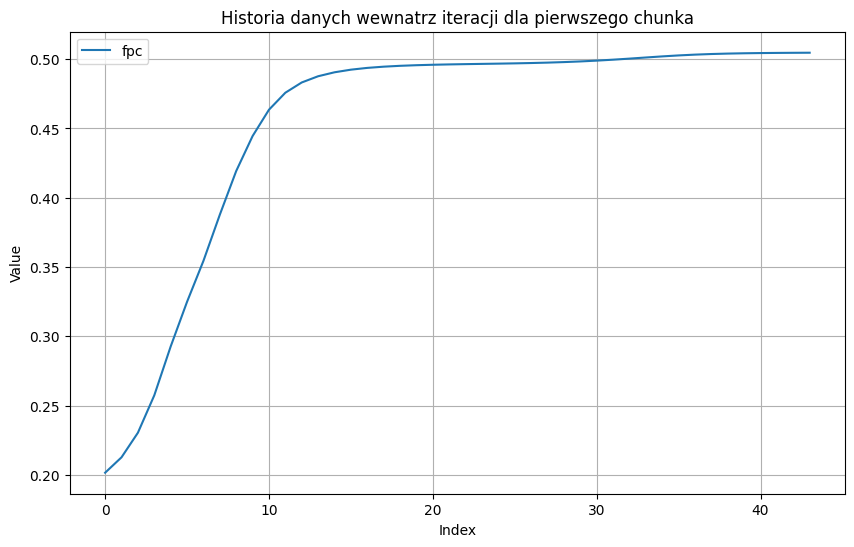

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


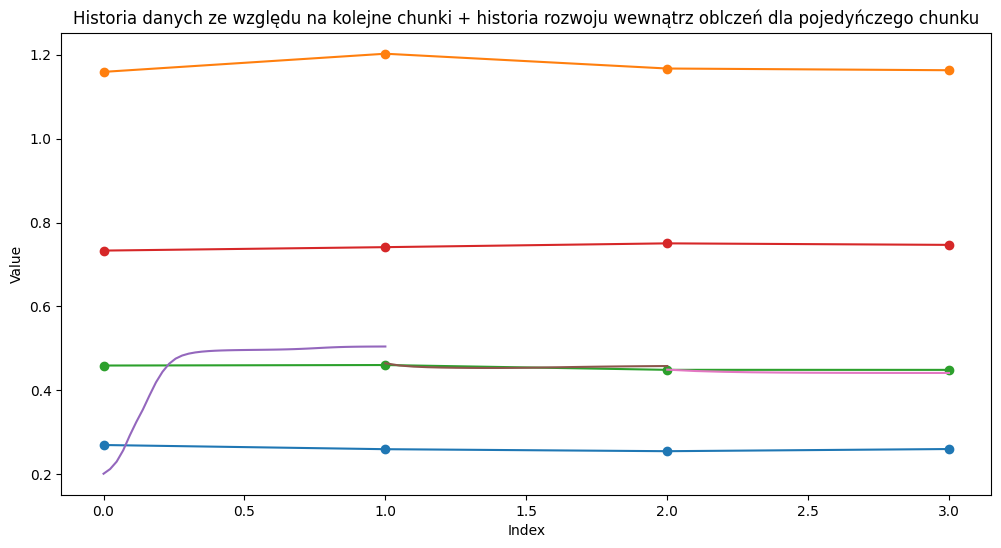

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


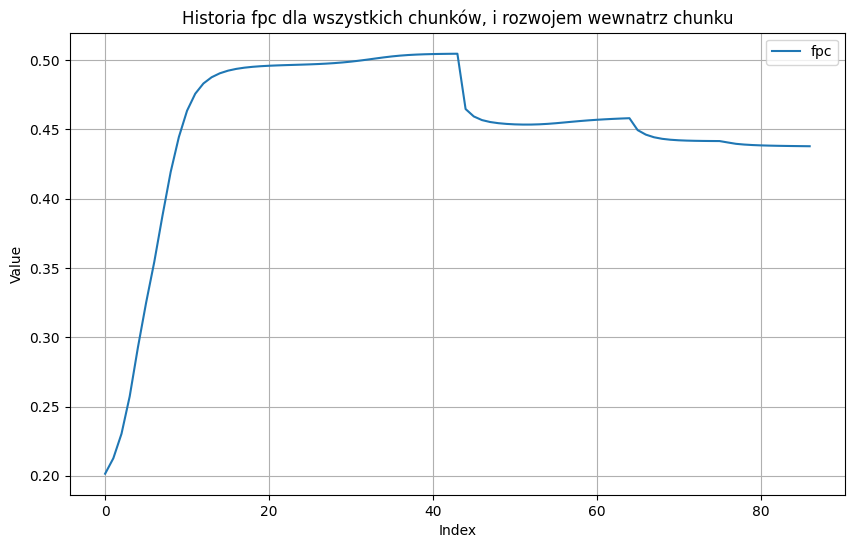

Historia centroidów ze względu na chunki


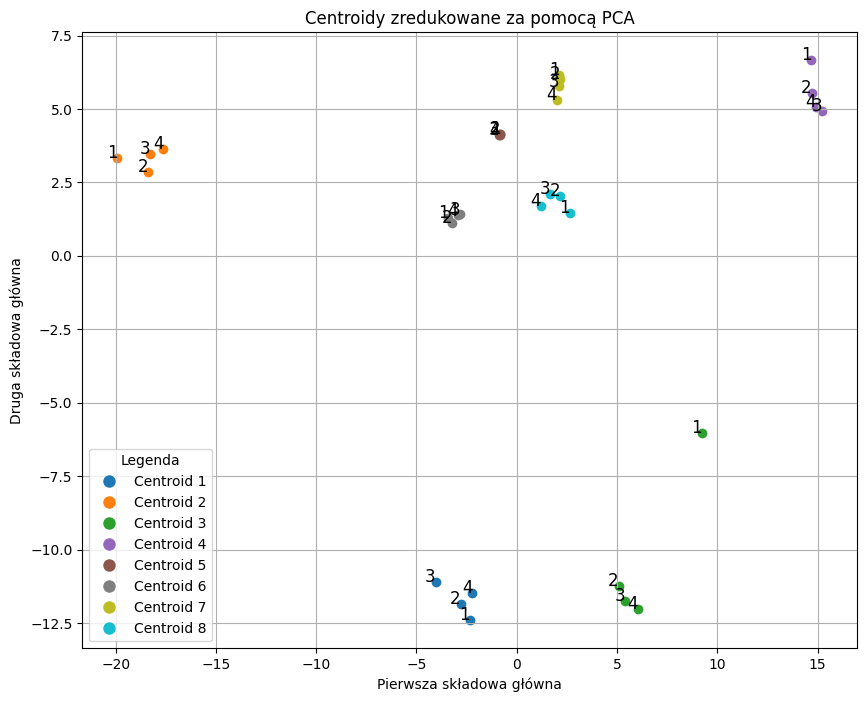

fpc last 0.44896269907815656
rand last 0.7467767295597484


In [68]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Badania zachowania się metody ze względu na liczbę clustrów



In [69]:
def find_optimal_number_of_clusters_ifcm(range_ = range(2,10)):
    output_data_chunk = []
    output_data_iter = []
    for n in range_:
        print('Rozważam: ', n)
        diagnosis_tools, diagnosis_iterations = train_incremental_fuzzy_cmeans(n, chunks, chunks_test, chunks_test_y)
        output_data_chunk.append(diagnosis_tools)
        output_data_iter.append(diagnosis_iterations)
    plot_statistic = DiagnosisTools()

    for n in range_:
        sil, dave, fpc, rand = output_data_chunk[n-2].get_avg()
        plot_statistic.add_elements(sil, dave, fpc, rand)

    plot_statistic.plot_lists()

    return plot_statistic, output_data_chunk, output_data_iter

#find_optimal_number_of_clusters_ifcm()

# Testowanie algorytmu ISSFCM

In [70]:
from libraries.ISSFCM import incremental_semi_supervised_fuzzy_cmeans
from libraries.ISSFCM import train_incremental_semi_supervised_fuzzy_cmeans, train_local_incremental_semi_supervised_fuzzy_cmeans

### Trenowanie ISSFCM

8


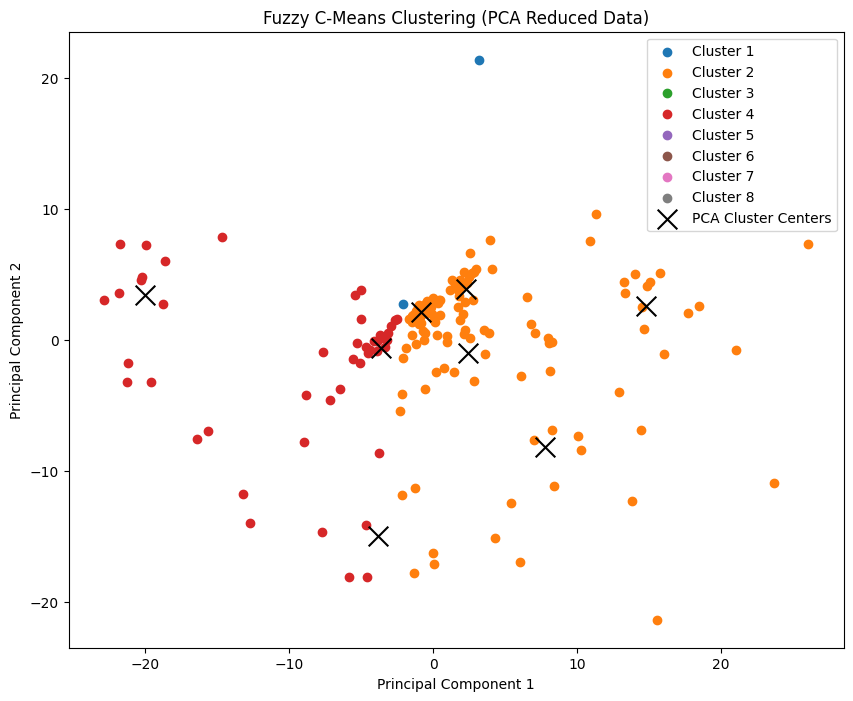

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.26993730667397176
Davies-Bouldin Score: 1.158972474919231
Rand Score: 0.7331761006289308
Tested fpc: 0.4593086437756858
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  0
Liczba klastrów:  8


Processing:  25%|█████████▊                             | 1/4 [00:00<?, ?it/s]


8


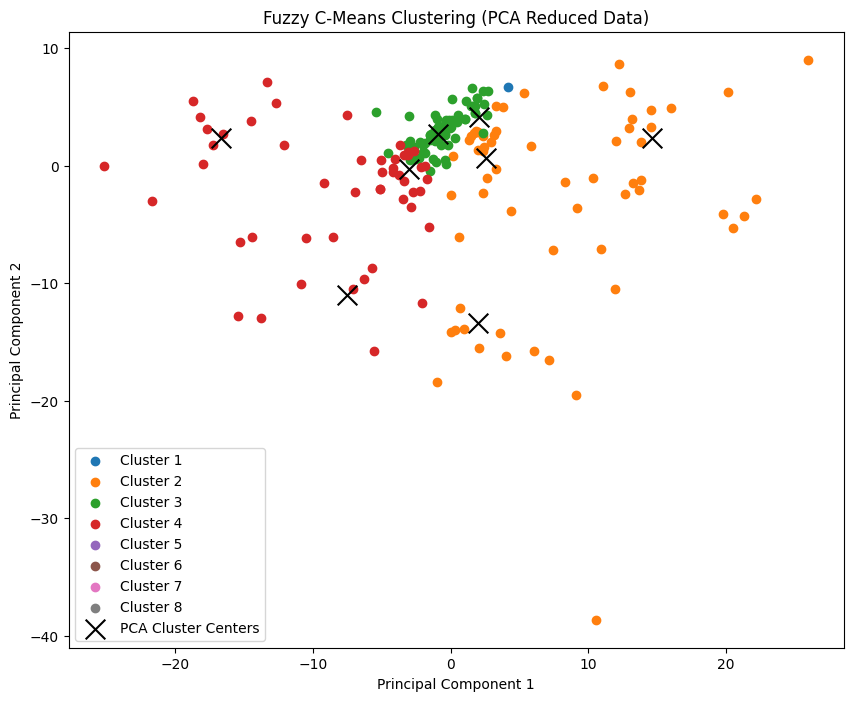

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.2579989402836408
Davies-Bouldin Score: 1.2701616922844279
Rand Score: 0.7435534591194969
Tested fpc: 0.45319865644835555
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  8


Processing:  50%|███████████████████▌                   | 2/4 [00:00<?, ?it/s]


8


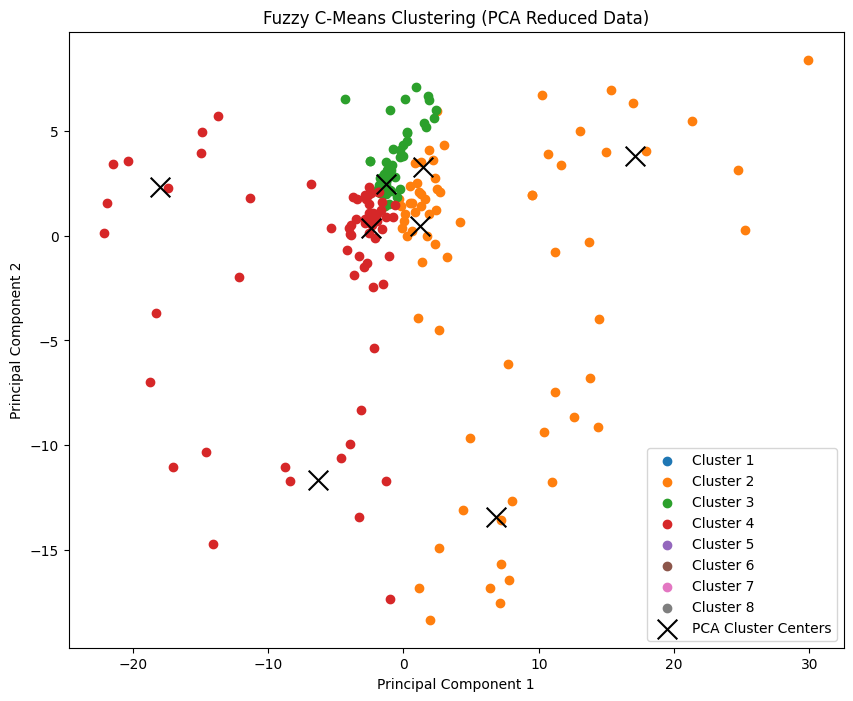

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.22272965357624983
Davies-Bouldin Score: 1.2814138935155728
Rand Score: 0.7513364779874214
Tested fpc: 0.41089929498198696
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  8


Processing:  75%|█████████████████████████████▎         | 3/4 [00:00<?, ?it/s]


8


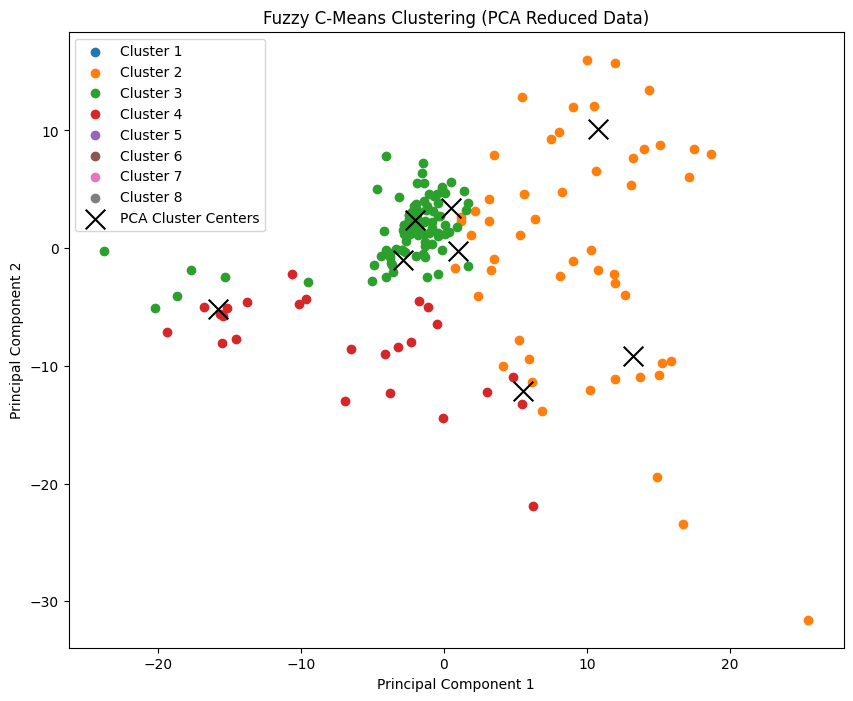

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.25825269498878944
Davies-Bouldin Score: 1.2392438172352318
Rand Score: 0.7538522012578617
Tested fpc: 0.4488041903593804
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  8


Processing: 100%|███████████████████████████████████████| 4/4 [00:00<?, ?it/s]

Czas wykonania: 1.1561493873596191 sekund


In [71]:
diagnosis_chunk, diagnosis_iterations = train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks_shuffled, chunks_y_shuffled, chunks_y_matrix, chunks_test, chunks_test_y, m=m, visualise_data=True, init_centroids=init_centroids_shuffled.copy())

Historia danych ze względu na kolejne chunki


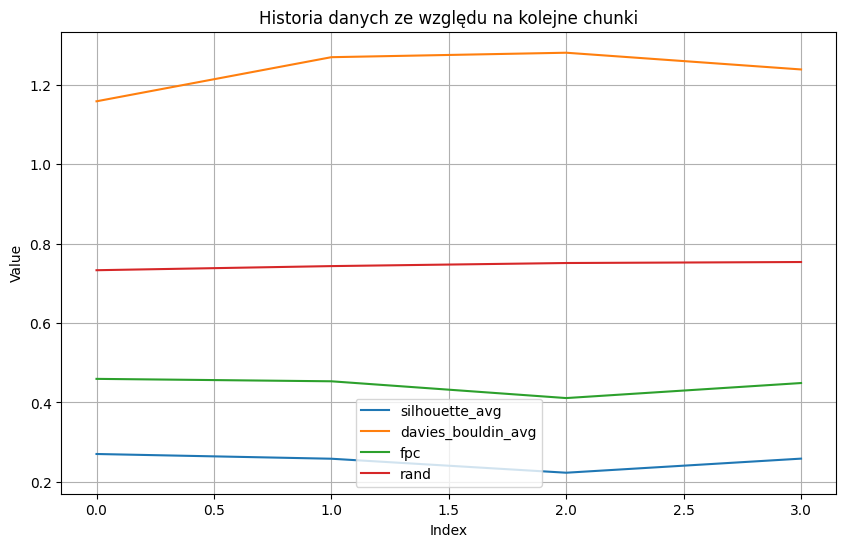

Historia statystyk ze względu na kolejne chunki


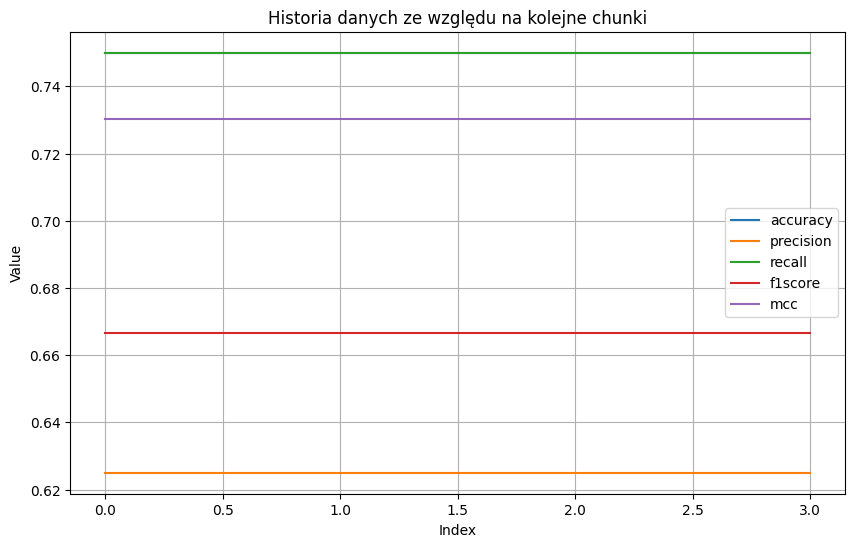

Historia danych wewnatrz iteracji dla pierwszego chunka


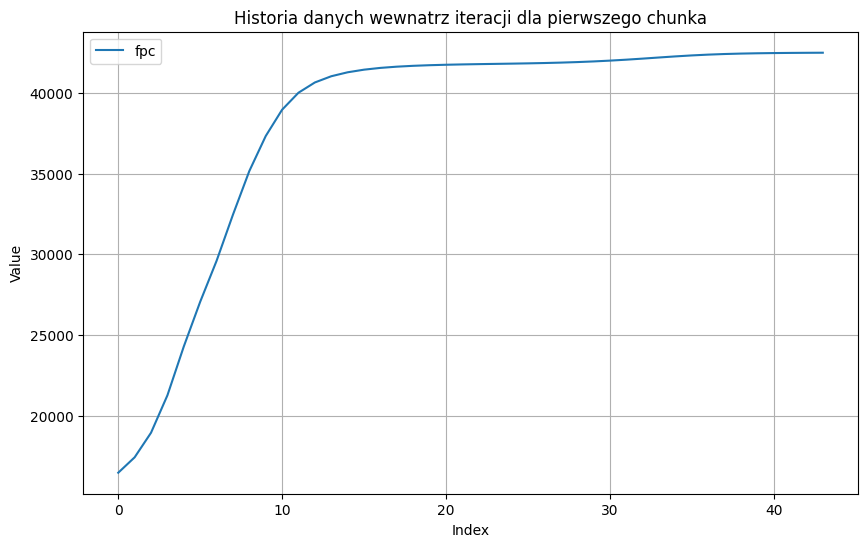

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


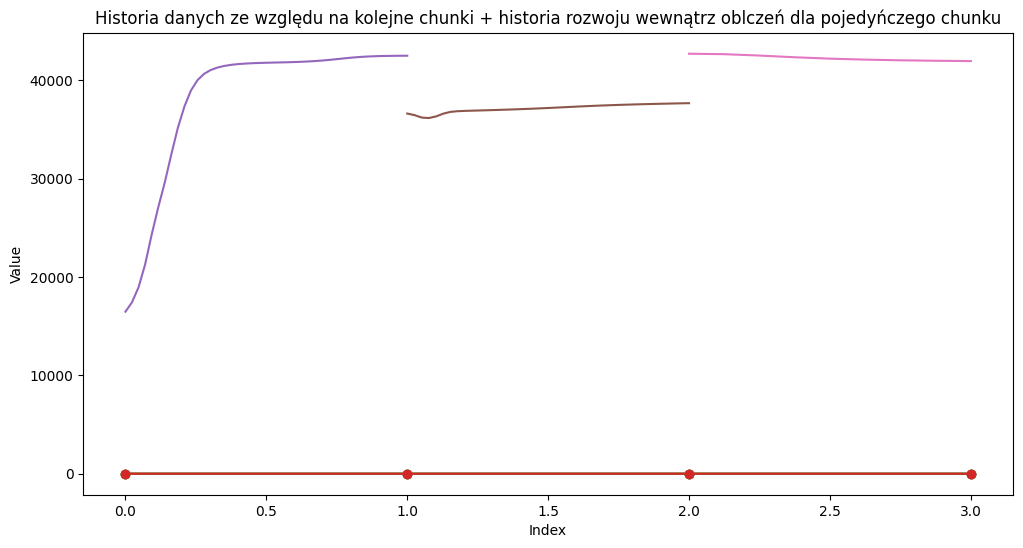

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


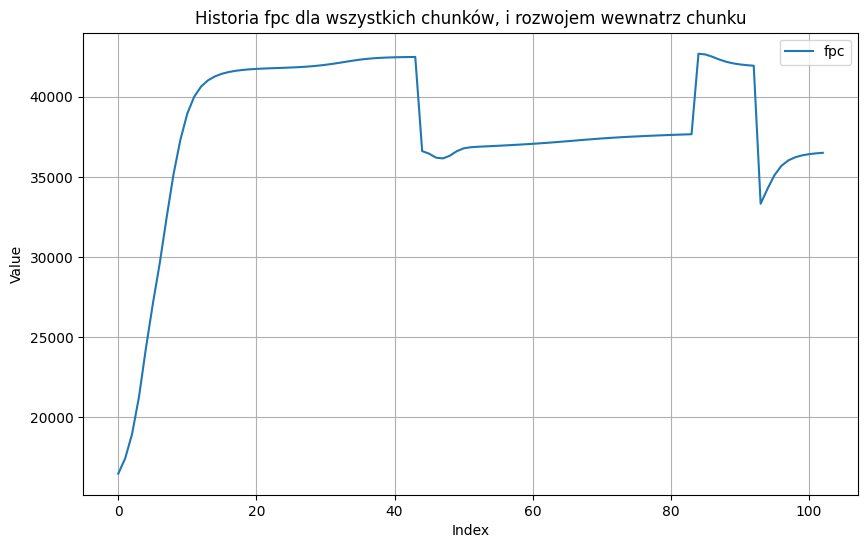

Historia centroidów ze względu na chunki


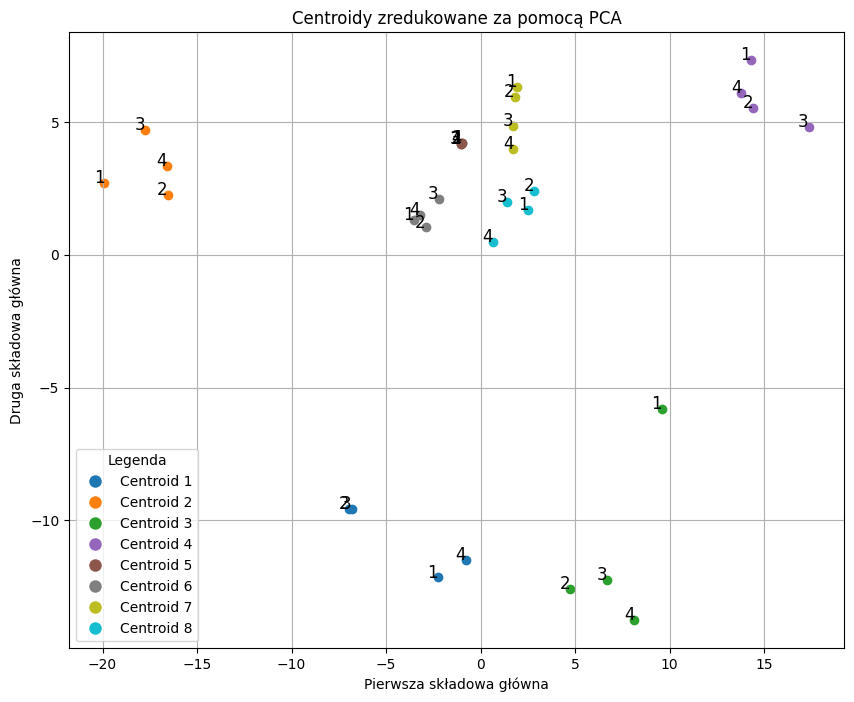

fpc last 0.4488041903593804
rand last 0.7538522012578617


In [72]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie ISSFCM tylko wybranych centroidów

8


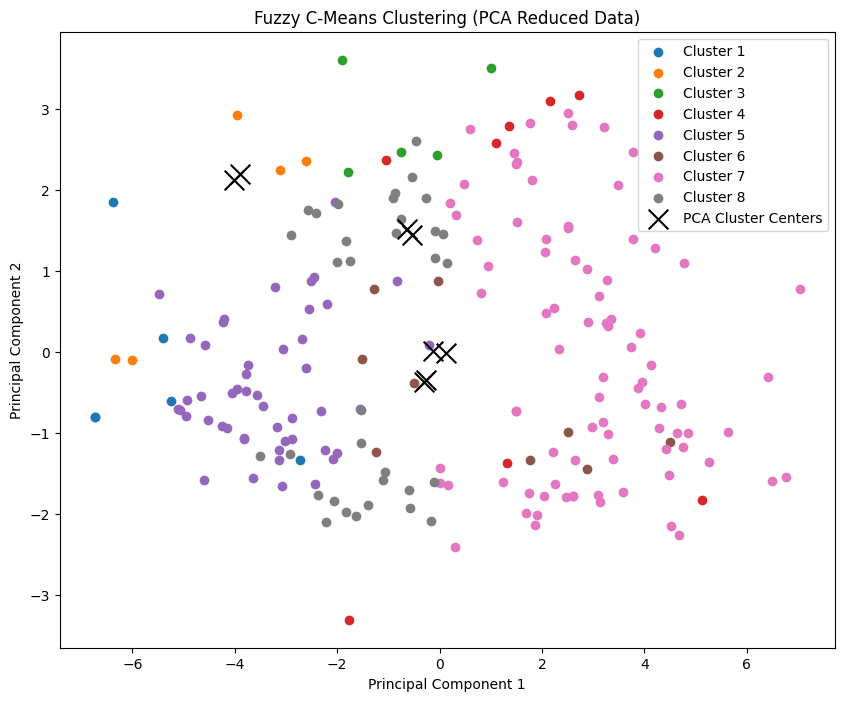

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.10744346322727145
Davies-Bouldin Score: 2.498273996752662
Rand Score: 0.7240566037735849
Tested fpc: 0.19151733312255087
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  0
Liczba klastrów:  8


Processing:  25%|█████████▊                             | 1/4 [00:00<?, ?it/s]


8


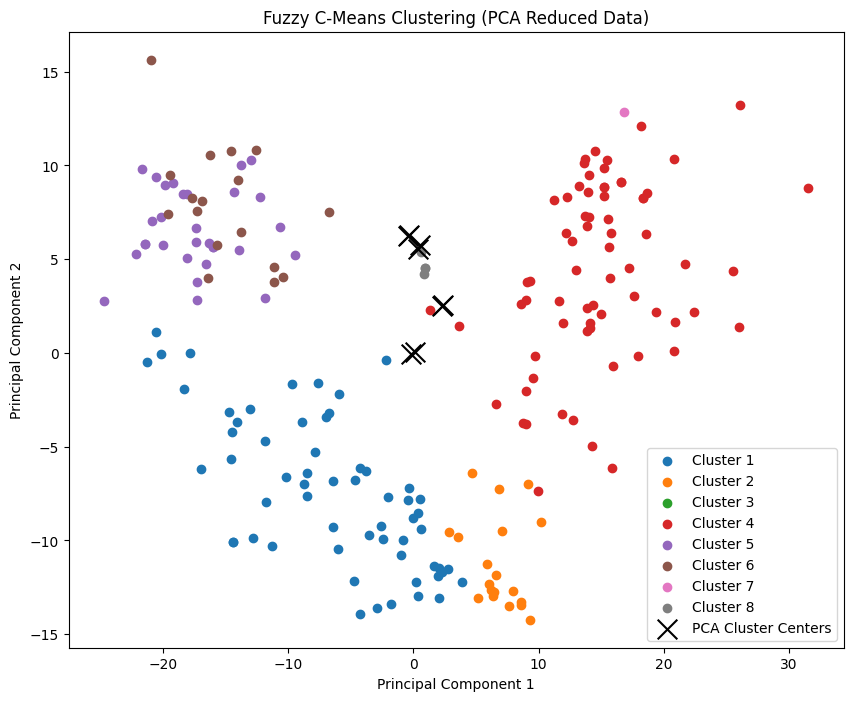

Silhouette Score: -0.09994363641917935
Davies-Bouldin Score: 2.17014295165026
Rand Score: 0.7234276729559749
Tested fpc: 0.191411348879217
Accuracy: 1.0
Precision:  1.0
Recall:  1.0
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  8


Processing:  50%|███████████████████▌                   | 2/4 [00:00<?, ?it/s]

8


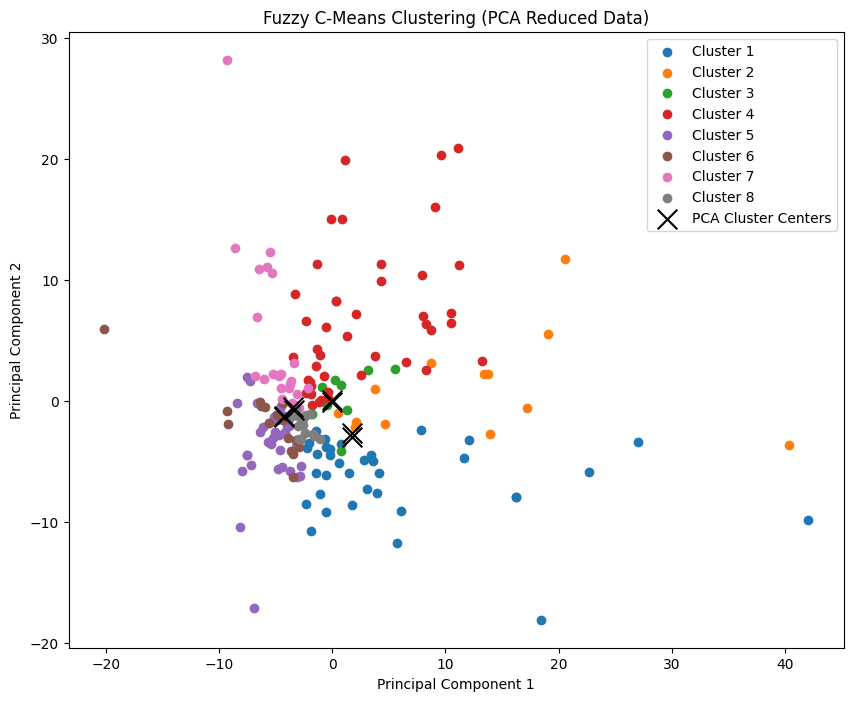

Silhouette Score: -0.12828373444476654
Davies-Bouldin Score: 2.145622641635944
Rand Score: 0.7220125786163522
Tested fpc: 0.1912974412282445
Accuracy: 1.0
Precision:  1.0
Recall:  1.0
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  8


Processing:  75%|█████████████████████████████▎         | 3/4 [00:00<?, ?it/s]

8


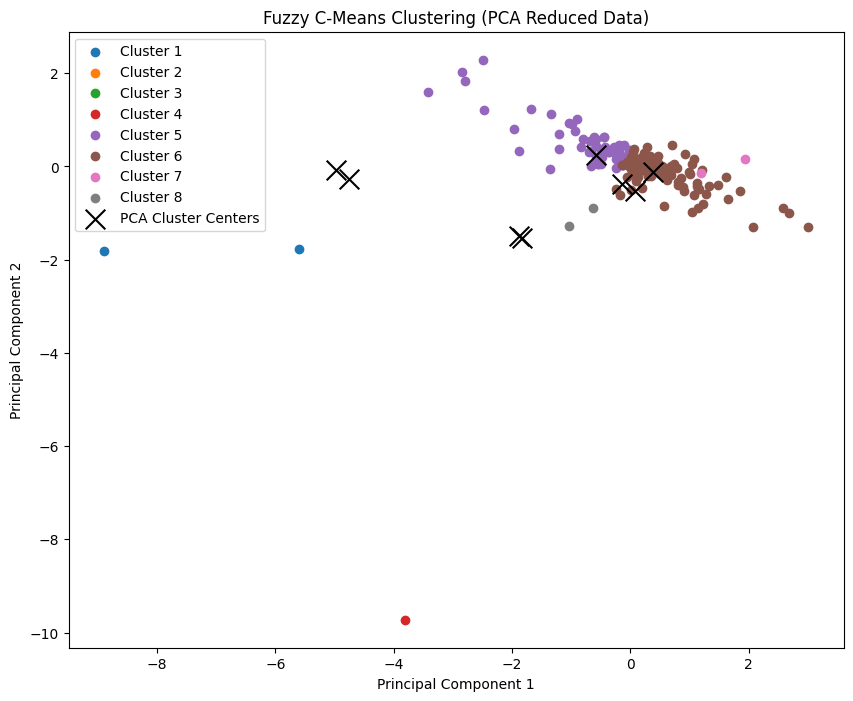

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.13366500485728755
Davies-Bouldin Score: 1.7187808062844412
Rand Score: 0.6999213836477988
Tested fpc: 0.2151931348548545
Accuracy: 0.75
Precision:  0.625
Recall:  0.75
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  8


Processing: 100%|███████████████████████████████████████| 4/4 [00:00<?, ?it/s]


8


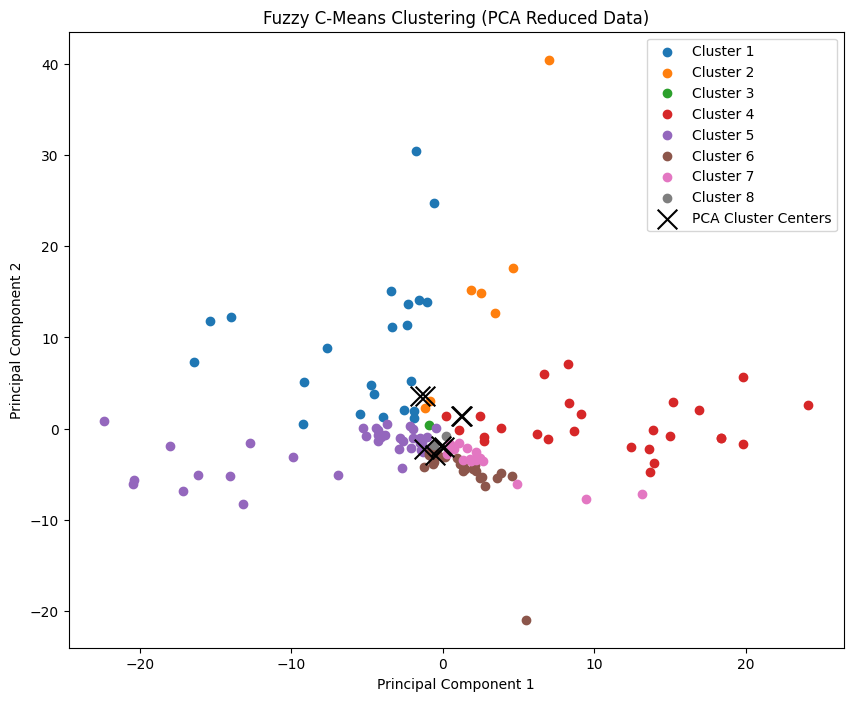

Cluster 0: counts = 22, summed_labels = 13.016714050681825, fcm per point 0.5916688204855375 
Cluster 1: counts = 7, summed_labels = 12.937022731720146, fcm per point 1.8481461045314496 
Cluster 2: counts = 1, summed_labels = 13.913000645527944, fcm per point 13.913000645527944 
Cluster 3: counts = 26, summed_labels = 13.876856749988308, fcm per point 0.5337252596149349 
Cluster 4: counts = 44, summed_labels = 28.53985123914652, fcm per point 0.6486329827078754 
Cluster 5: counts = 42, summed_labels = 34.00119998054263, fcm per point 0.8095523804891103 
Cluster 6: counts = 16, summed_labels = 21.767935109704677, fcm per point 1.3604959443565423 
Cluster 7: counts = 2, summed_labels = 21.947419492687956, fcm per point 10.973709746343978 
Czas wykonania: 1.494321346282959 sekund


In [73]:
diagnosis_chunk, diagnosis_iterations = train_local_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y, chunks_y_matrix, chunks_classification_train, chunks_test, chunks_test_y, clusters_for_each_class.copy(), m=m, visualise_data=True, init_centroids=init_centroids.copy())

Historia danych ze względu na kolejne chunki


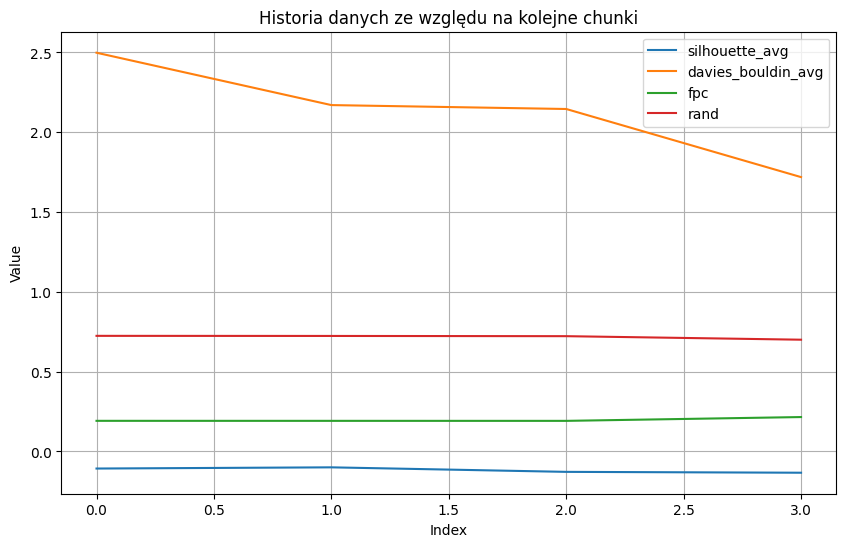

Historia statystyk ze względu na kolejne chunki


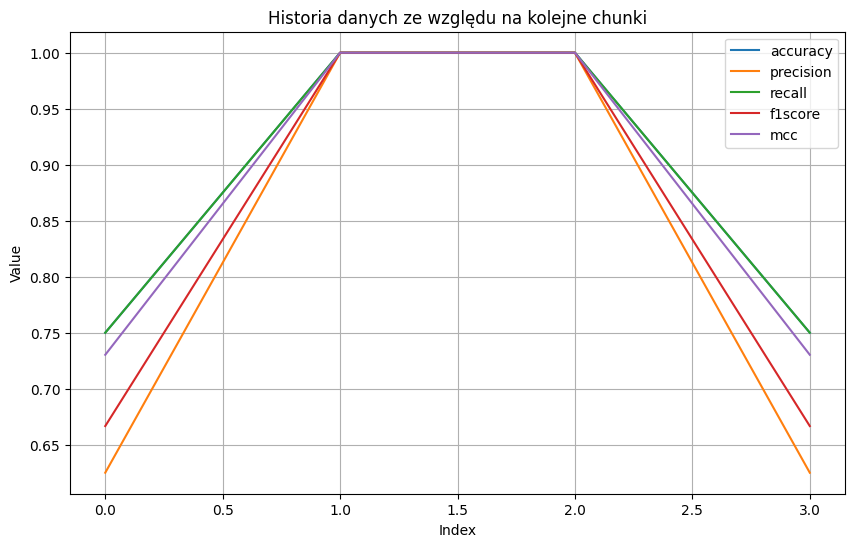

Historia danych wewnatrz iteracji dla pierwszego chunka


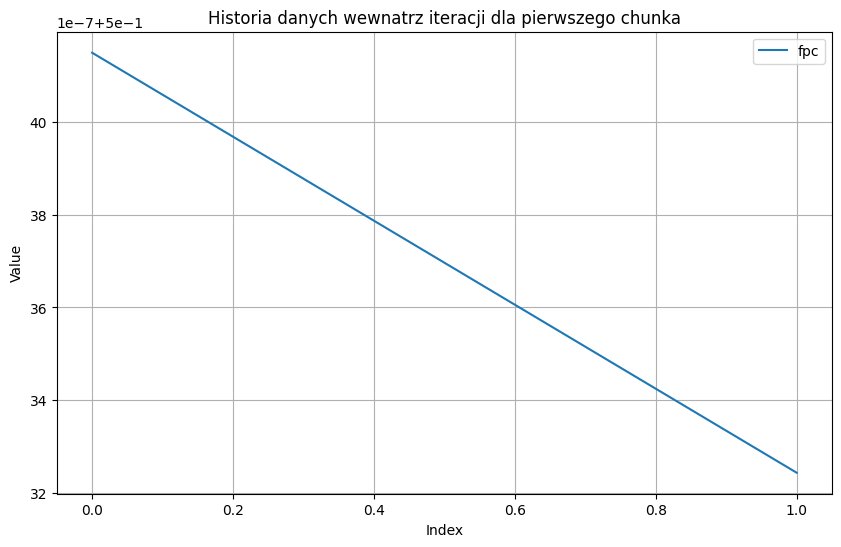

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


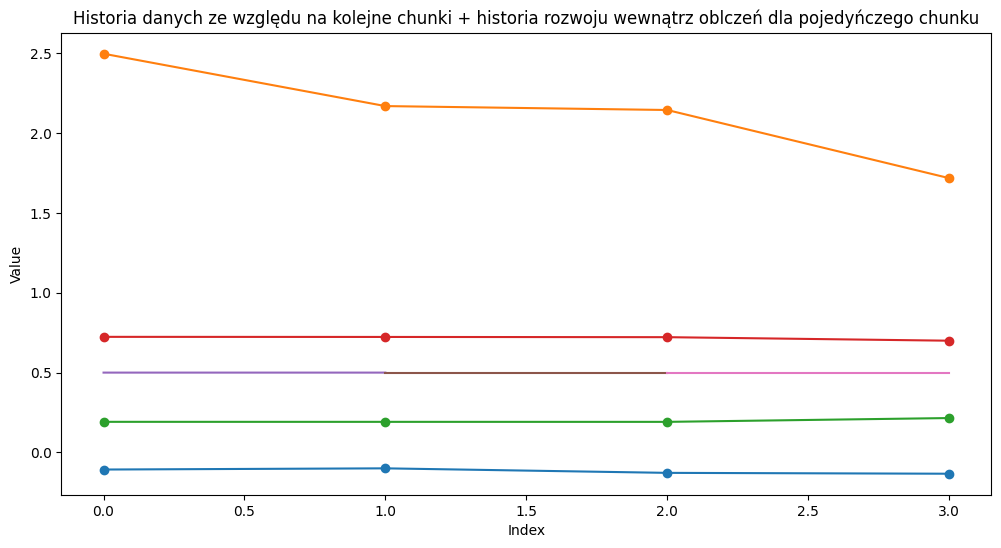

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


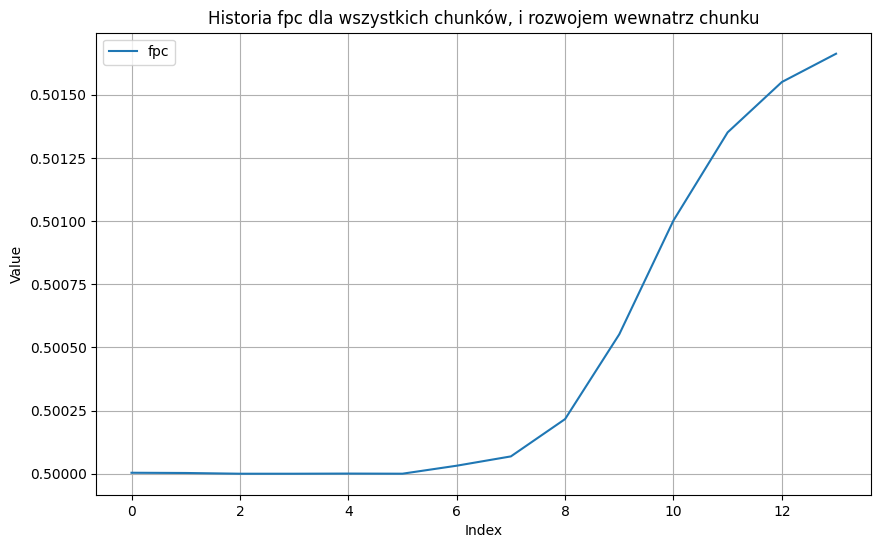

Historia centroidów ze względu na chunki


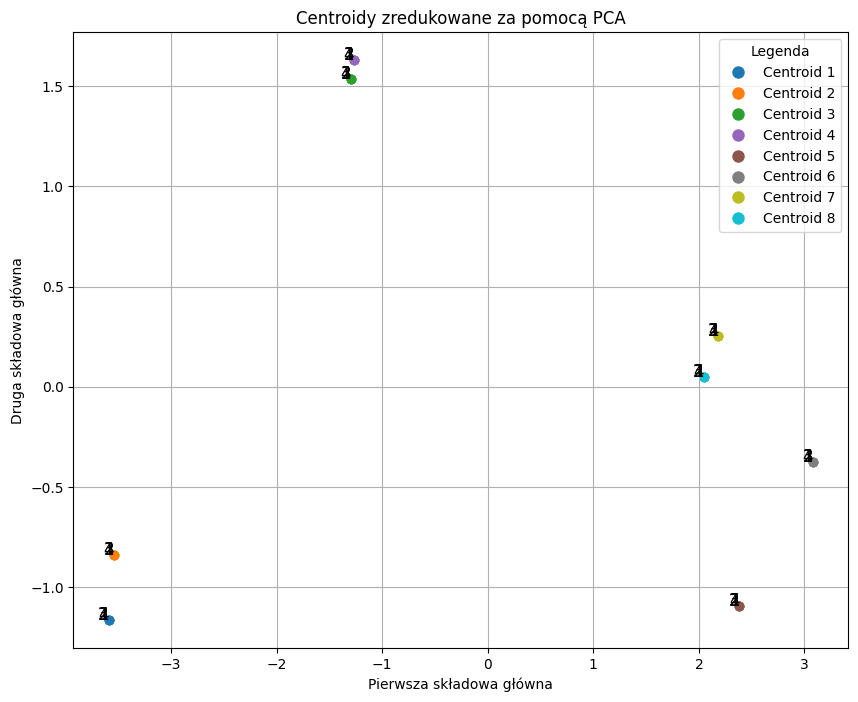

fpc last 0.2151931348548545
rand last 0.6999213836477988


In [74]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

In [75]:
def find_optimal_number_of_clusters_issfcm(range_ = range(n_clusters,16)):
    output_data_chunk = []
    output_data_iter = []
    
    for n in range_:
        print('Rozważam: ', n)
        y_train_matrix, init_centroids = create_semi_supervised_matrix(X_train, y_train, n)
        _, _, chunks_y_matrix = create_dataset_chunks(chunk_train_sizes, X_train, y_train, y_train_matrix)
        diagnosis_tools, diagnosis_iterations = train_incremental_semi_supervised_fuzzy_cmeans(n, chunks, chunks_y_matrix, chunks_test, chunks_test_y, init_centroids=init_centroids)
        output_data_chunk.append(diagnosis_tools)
        output_data_iter.append(diagnosis_iterations)
    
    plot_statistic = DiagnosisTools()
    
    for n in range_:
        sil, dave, fpc, rand = output_data_chunk[n-n_clusters].get_avg()
        plot_statistic.add_elements(sil, dave, fpc, rand)
        
    plot_statistic.plot_lists()

    return plot_statistics

In [76]:
#find_optimal_number_of_clusters_issfcm()